In [1]:
import os
import bye_cycle
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from beep.structure.cli import auto_load_processed

2022-08-08 14:51:45.671601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 14:51:45.853032: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-08-08 14:51:46.540966: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:/us

In [2]:
# structure_path = '/home/ec2-user/SageMaker/Amalie/competition/structured/'
structure_path = '/home/ec2-user/SageMaker/data_cache/structure/' # this is old LFP data
#Get all structured files with the correct prefix
names = [os.path.join(structure_path, n) for n in os.listdir(structure_path) if "FastCharge" in n]
#exclude stitched files
# excuded_cells = [str(_) for _ in list(range(292,295)) + list(range(297,307))]
# names = [n for n in names if (not "p2_structure" in n and ".gz" in n and not any(x in n for x in excuded_cells))]
N = len(names)

In [4]:
import pickle
structured_columns = ['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']
summary_columns = ['cycle_index', 'discharge_capacity', 'charge_capacity', 'discharge_energy',
                   'charge_energy', 'charge_throughput', 'energy_throughput']
exclude_count = 0
for i,n in enumerate(names):
    structured_data = []
    summary_data = []
    notes = []
    # check to see if the cell was aleady excluded
    exclude_checker = False
    with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r') as f:
        if n[46:-5] in f.read():
            exclude_checker = True
            print(f'Cell {n[46:-5]} is already excluded. Please check notes.txt for more details.')
#     print(n[46:-5])
#     print(n)
#     break   
    if not exclude_checker:
        if not os.path.exists(f'CACHED_DATA/pre_processed_pandas/LFP/{n[46:-5]}.pkl'):
            cell = auto_load_processed(n)
            manufacturding_nominal_discharge_capacity = 1.1
            # excluding cells that that have less than 50 cycles
            cycle_idx_threshold = 50
            max_cycle_idx = max(cell.structured_data['cycle_index'])
            if not max_cycle_idx < cycle_idx_threshold:
                nominal_discharge_capacity_drop = 1- cell.structured_summary['discharge_capacity'][1]/manufacturding_nominal_discharge_capacity
                # excluding cells that that have more that 80% drop in discharge capacity within 1st cycle
                nominal_discharge_capacity_drop_threshold = 0.8
                if nominal_discharge_capacity_drop < nominal_discharge_capacity_drop_threshold:
                    print(f'Pre-processing data for cell {n[46:-5]}.')
                    for c in tqdm(cell.structured_summary['cycle_index']):
                        clean_cell = bye_cycle.clean_cycle_data(cell, c, columns=structured_columns)
                        structured_data.append(clean_cell)
                    summary_data.append(cell.structured_summary[summary_columns])
        #             features.append(bye_cycle.prep_features_per_cell(cell, n_points,
        #                                                              interpol_kind='quadratic',
        #                                                              columns=['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']))

                    with open(f'CACHED_DATA/pre_processed_pandas/LFP/{n[46:-5]}.pkl','wb') as f: 
                        pickle.dump([structured_data, summary_data], f) 
                else:
                    if nominal_discharge_capacity_drop > nominal_discharge_capacity_drop_threshold:
                        add_txt = f'\n- Cell {n[46:-8]} was skipped as the nominal discharge capacity drop ({nominal_discharge_capacity_drop:.3f}) exceeds {nominal_discharge_capacity_drop_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)
                    if max_cycle_idx < cycle_idx_threshold:
                        add_txt = f'\n- Cell {n[46:-5]} was skipped as the cycle numbers ({max_cycle_idx}) is less than {cycle_idx_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)

In [8]:
# # run this for new LFP be Amalie
# import pickle
# structured_columns = ['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity','step_type', 'test_time']
# summary_columns = ['cycle_index', 'discharge_capacity', 'charge_capacity', 'discharge_energy',
#                    'charge_energy', 'charge_throughput', 'energy_throughput']
# exclude_count = 0
# for i,n in enumerate(names):
#     if n!='/home/ec2-user/SageMaker/Amalie/competition/structured/FastCharge_000017_CH33_structure.json':
#         structured_data = []
#         summary_data = []
#         notes = []
#         # check to see if the cell was aleady excluded
#         exclude_checker = False
#         with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/notes.txt', 'r') as f:
#             if n[46:-5] in f.read():
#                 exclude_checker = True
#                 print(f'Cell {n[55:-5]} is already excluded. Please check notes.txt for more details.')
#     #     print(n[46:-5])
#     #     print(n)
#     #     break   
#         if not exclude_checker:
#             if not os.path.exists(f'CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/{n[55:-5]}.pkl'):
#                 # excluding charge data

#                 cell = auto_load_processed(n)
#     #             a = a[a['step_type'] != 'charge'] 
#                 manufacturding_nominal_discharge_capacity = 1.1
#                 # excluding cells that that have less than 50 cycles
#                 cycle_idx_threshold = 50
#                 max_cycle_idx = max(cell.structured_data['cycle_index'])
#                 if not max_cycle_idx < cycle_idx_threshold:
#                     nominal_discharge_capacity_drop = 1- cell.structured_summary['discharge_capacity'][1]/manufacturding_nominal_discharge_capacity
#                     # excluding cells that that have more that 80% drop in discharge capacity within 1st cycle
#                     nominal_discharge_capacity_drop_threshold = 0.8
#                     if nominal_discharge_capacity_drop < nominal_discharge_capacity_drop_threshold:
#                         print(f'Pre-processing data for cell {n[55:-5]}.')
#                         for c in tqdm(cell.structured_summary['cycle_index']):
#                             clean_cell_structured_data = bye_cycle.clean_cycle_data(cell, c, columns=structured_columns, exclude_step_type='charge')
#                             clean_cell_structured_data = clean_cell_structured_data.sort_values('test_time', ascending=True)
#                             structured_data.append(clean_cell_structured_data)
#     #                         break
#                         summary_data.append(cell.structured_summary[summary_columns])
#             #             features.append(bye_cycle.prep_features_per_cell(cell, n_points,
#             #                                                              interpol_kind='quadratic',
#             #                                                              columns=['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']))

#                         with open(f'CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/{n[55:-5]}.pkl','wb') as f: 
#                             pickle.dump([structured_data, summary_data], f) 
#                     else:
#                         if nominal_discharge_capacity_drop > nominal_discharge_capacity_drop_threshold:
#                             add_txt = f'\n- Cell {n[55:-8]} was skipped as the nominal discharge capacity drop ({nominal_discharge_capacity_drop:.3f}) exceeds {nominal_discharge_capacity_drop_threshold}.\n'
#                             print(add_txt)
#                             with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/notes.txt', 'r+') as f:
#                                 lines_list = f.readlines()
#                                 if add_txt not in lines_list: 
#                                     f.write(add_txt)
#                         if max_cycle_idx < cycle_idx_threshold:
#                             add_txt = f'\n- Cell {n[55:-5]} was skipped as the cycle numbers ({max_cycle_idx}) is less than {cycle_idx_threshold}.\n'
#                             print(add_txt)
#                             with open('CACHED_DATA/pre_processed_pandas/LFP_new_structured_by_Amalie/notes.txt', 'r+') as f:
#                                 lines_list = f.readlines()
#                                 if add_txt not in lines_list: 
#                                     f.write(add_txt)

Pre-processing data for cell FastCharge_000016_CH17_structure.


100%|██████████| 527/527 [00:21<00:00, 23.97it/s]


Pre-processing data for cell FastCharge_000026_CH5_structure.


100%|██████████| 210/210 [00:03<00:00, 55.09it/s]


Pre-processing data for cell FastCharge_000051_CH16_structure.


100%|██████████| 720/720 [00:40<00:00, 17.79it/s]


Pre-processing data for cell FastCharge_000046_CH32_structure.


100%|██████████| 1015/1015 [01:19<00:00, 12.85it/s]


Pre-processing data for cell FastCharge_000007_CH39_structure.


100%|██████████| 859/859 [00:57<00:00, 15.06it/s]


Pre-processing data for cell FastCharge_000011_CH26_structure.


100%|██████████| 524/524 [00:21<00:00, 24.07it/s]


Pre-processing data for cell FastCharge_000015_CH44_structure.


100%|██████████| 1094/1094 [01:31<00:00, 12.00it/s]


Pre-processing data for cell FastCharge_000066_CH25_structure.


100%|██████████| 1018/1018 [01:19<00:00, 12.78it/s]


Pre-processing data for cell FastCharge_000019_CH29_structure.


100%|██████████| 732/732 [00:42<00:00, 17.36it/s]


Pre-processing data for cell FastCharge_000036_CH48_structure.


100%|██████████| 747/747 [00:43<00:00, 17.31it/s]


Pre-processing data for cell FastCharge_000015_CH20_structure.


100%|██████████| 818/818 [00:51<00:00, 15.77it/s]


Pre-processing data for cell FastCharge_000004_CH1_structure.


100%|██████████| 664/664 [00:34<00:00, 19.22it/s]


In [7]:
clean_cell_structured_data = bye_cycle.clean_cycle_data(cell, c, columns=structured_columns, exclude_step_type='charge')
clean_cell_structured_data = clean_cell_structured_data[clean_cell_structured_data['step_type'] != 'charge']
clean_cell_structured_data

Excluding cycles with step type charge.


voltage   current  cycle_index  discharge_capacity  charge_capacity  \
73000  2.000000 -0.031389           73            1.085064          1.08502   
73001  2.001602 -2.261051           73            1.074929          1.08502   
73002  2.003203 -4.399678           73            1.067871          1.08502   
73003  2.004805 -4.399776           73            1.067871          1.08502   
73004  2.006406 -4.399875           73            1.067871          1.08502   
...         ...       ...          ...                 ...              ...   
73987  3.580781 -0.905453           73            0.000007          1.08502   
73988  3.582382 -0.832098           73            0.000007          1.08502   
73989  3.583984 -0.758744           73            0.000007          1.08502   
73990  3.585586 -0.685389           73            0.000007          1.08502   
73991  3.587187 -0.612035           73            0.000007          1.08502   

       step_type      test_time  
73000  discharge  261744.192124  
73001  discharge  261522.510107  
73002  discharge  261472.446630  
73003  discharge  261472.386729  
73004  discharge  261472.326828  
...          ...            ...  
73987  discharge  260598.103304  
73988  discharge  260598.091799  
73989  discharge  260598.080293  
73990  discharge  260598.068788  
73991  discharge  260598.057283  

[992 rows x 7 columns]

In [ ]:
a=auto_load_processed(n)

In [10]:
a = cell.structured_data
a = a[a['step_type'] != 'charge'] 
a

voltage      test_time   current  charge_capacity  \
0        2.000000  103509.528233 -0.051301         0.882827   
1        2.001602  103107.101387 -3.353685         0.805902   
2        2.003203  102000.273743 -2.730370         0.523346   
3        2.004805  100477.158654 -1.306292         0.066239   
4        2.006406  101217.399273 -1.998303         0.288410   
...           ...            ...       ...              ...   
1638995  3.593594            NaN       NaN              NaN   
1638996  3.595195            NaN       NaN              NaN   
1638997  3.596797            NaN       NaN              NaN   
1638998  3.598398            NaN       NaN              NaN   
1638999  3.600000            NaN       NaN              NaN   

         discharge_capacity  charge_energy  discharge_energy  \
0                  1.374366       3.065041          4.221634   
1                  1.286930       2.797966          3.966070   
2                  1.001947       1.816978          3.099715   
3                  0.545519       0.229971          1.707365   
4                  0.767081       1.001315          2.383524   
...                     ...            ...               ...   
1638995                 NaN            NaN               NaN   
1638996                 NaN            NaN               NaN   
1638997                 NaN            NaN               NaN   
1638998                 NaN            NaN               NaN   
1638999                 NaN            NaN               NaN   

         internal_resistance  temperature  cycle_index  step_type  
0                   0.015648    34.695797            0  discharge  
1                   0.015648    35.932766            0  discharge  
2                   0.015648    34.678646            0  discharge  
3                   0.015648    32.426224            0  discharge  
4                   0.015648    33.520130            0  discharge  
...                      ...          ...          ...        ...  
1638995                  NaN          NaN         1638  discharge  
1638996                  NaN          NaN         1638  discharge  
1638997                  NaN          NaN         1638  discharge  
1638998                  NaN          NaN         1638  discharge  
1638999                  NaN          NaN         1638  discharge  

[1639000 rows x 11 columns]

In [2]:
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
# Disabling GPU
RUN_ON_GPU = True
if not RUN_ON_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
structure_path = '/home/ec2-user/SageMaker/data_cache/structure/'
#Get all structured files with the correct prefix
names = [os.path.join(structure_path, n) for n in os.listdir(structure_path) if "FastCharge" in n]
#exclude stitched files
excuded_cells = [str(_) for _ in list(range(292,295)) + list(range(297,307))]
# names = [n for n in names if (not "p2_structure" in n and ".gz" in n and not any(x in n for x in excuded_cells))]
N = len(names)

In [127]:
structure_path = '/home/ec2-user/SageMaker/Amalie/competition/structured/'
names = [os.path.join(structure_path, n) for n in os.listdir(structure_path) if "FastCharge" in n]
a = auto_load_processed(names[0])

In [95]:
a.structured_data

voltage     test_time   current  charge_capacity  \
0        2.000000  1.041957e+05 -0.106850         1.071074   
1        2.001602  1.024979e+05 -2.680700         0.635530   
2        2.003203  1.036308e+05 -4.132346         0.984168   
3        2.004805  1.027588e+05 -3.345201         0.728698   
4        2.006406  1.018868e+05 -2.558055         0.473228   
...           ...           ...       ...              ...   
1865995  3.557257  2.665751e+06  0.109998         1.756637   
1865996  3.573670  2.665809e+06  0.109998         1.758403   
1865997  3.592805  2.665867e+06  0.110000         1.760168   
1865998  3.600016  2.665967e+06  0.077403         1.761934   
1865999       NaN           NaN       NaN         1.763699   

         discharge_capacity  charge_energy  discharge_energy  \
0                  1.567604       3.735271          4.804385   
1                  1.120013       2.216354          3.454894   
2                  1.465139       3.432194          4.508781   
3                  1.210349       2.541267          3.732740   
4                  0.955560       1.650339          2.956699   
...                     ...            ...               ...   
1865995            0.879837       6.016382          2.525013   
1865996            0.879837       6.022676          2.525013   
1865997            0.879837       6.029002          2.525013   
1865998            0.879837       6.035356          2.525013   
1865999                 NaN            NaN               NaN   

         internal_resistance  temperature  cycle_index  step_type  
0                   0.016300    33.235085            0  discharge  
1                   0.016300    33.709293            0  discharge  
2                   0.016300    34.805790            0  discharge  
3                   0.016300    34.016071            0  discharge  
4                   0.016300    33.226353            0  discharge  
...                      ...          ...          ...        ...  
1865995             0.019742    31.024267          932     charge  
1865996             0.019742    31.050282          932     charge  
1865997             0.019742    31.060114          932     charge  
1865998             0.019742    30.991980          932     charge  
1865999                  NaN          NaN          932     charge  

[1866000 rows x 11 columns]

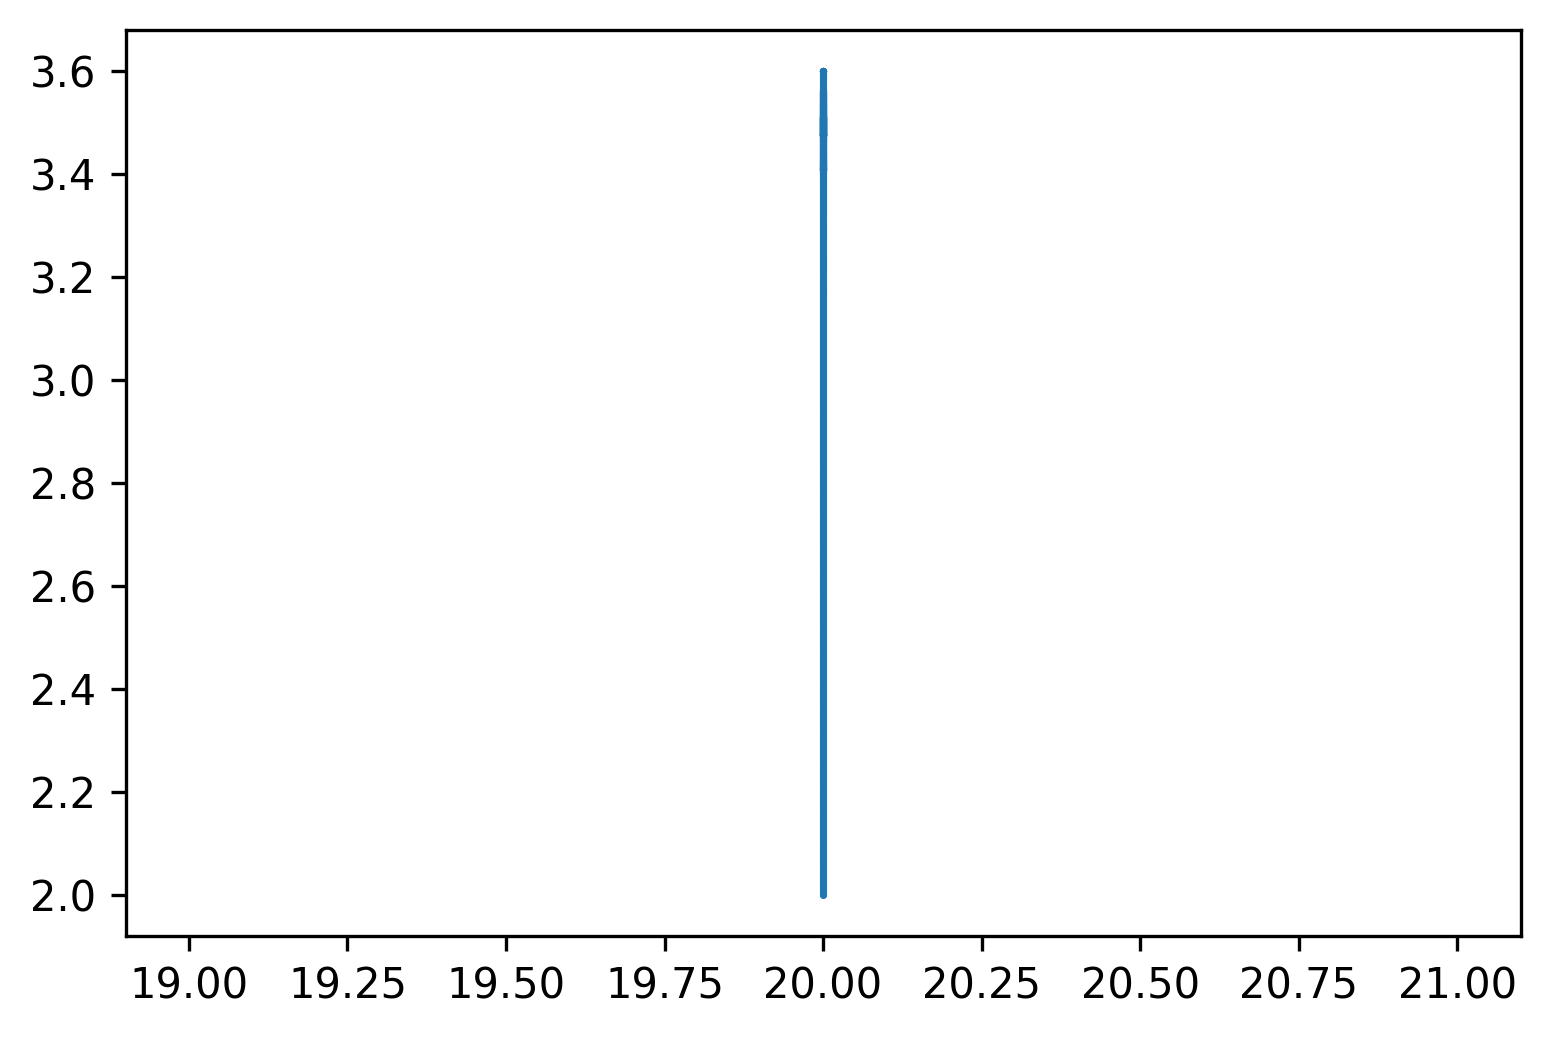

In [125]:
plt.figure(dpi=300)
cycle_zero = a.structured_data[a.structured_data["cycle_index"] == 20]
plt.scatter(cycle_zero['cycle_index'], cycle_zero['voltage'], s=0.5)

In [100]:
 a.structured_data['voltage']

0          2.000000
1          2.001602
2          2.003203
3          2.004805
4          2.006406
             ...   
1865995    3.557257
1865996    3.573670
1865997    3.592805
1865998    3.600016
1865999         NaN
Name: voltage, Length: 1866000, dtype: float32

In [5]:
import pickle
structured_columns = ['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']
summary_columns = ['cycle_index', 'discharge_capacity', 'charge_capacity', 'discharge_energy',
                   'charge_energy', 'charge_throughput', 'energy_throughput']
exclude_count = 0
for i,n in enumerate(names):
    structured_data = []
    summary_data = []
    notes = []
    # check to see if the cell was aleady excluded
    exclude_checker = False
    with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r') as f:
        if n[46:-5] in f.read():
            exclude_checker = True
            print(f'Cell {n[46:-5]} is already excluded. Please check notes.txt for more details.')
#     print(n[46:-5])
#     print(n)
#     break   
    if not exclude_checker:
        if not os.path.exists(f'CACHED_DATA/pre_processed_pandas/LFP/{n[46:-5]}.pkl'):
            cell = auto_load_processed(n)
            manufacturding_nominal_discharge_capacity = 1.1
            # excluding cells that that have less than 50 cycles
            cycle_idx_threshold = 50
            max_cycle_idx = max(cell.structured_data['cycle_index'])
            if not max_cycle_idx < cycle_idx_threshold:
                nominal_discharge_capacity_drop = 1- cell.structured_summary['discharge_capacity'][1]/manufacturding_nominal_discharge_capacity
                # excluding cells that that have more that 80% drop in discharge capacity within 1st cycle
                nominal_discharge_capacity_drop_threshold = 0.8
                if nominal_discharge_capacity_drop < nominal_discharge_capacity_drop_threshold:
                    print(f'Pre-processing data for cell {n[46:-5]}.')
                    for c in tqdm(cell.structured_summary['cycle_index']):
                        clean_cell = bye_cycle.clean_cycle_data(cell, c, columns=structured_columns)
                        structured_data.append(clean_cell)
                    summary_data.append(cell.structured_summary[summary_columns])
        #             features.append(bye_cycle.prep_features_per_cell(cell, n_points,
        #                                                              interpol_kind='quadratic',
        #                                                              columns=['voltage', 'current', 'cycle_index', 'discharge_capacity', 'charge_capacity']))

                    with open(f'CACHED_DATA/pre_processed_pandas/LFP/{n[46:-5]}.pkl','wb') as f: 
                        pickle.dump([structured_data, summary_data], f) 
                else:
                    if nominal_discharge_capacity_drop > nominal_discharge_capacity_drop_threshold:
                        add_txt = f'\n- Cell {n[46:-8]} was skipped as the nominal discharge capacity drop ({nominal_discharge_capacity_drop:.3f}) exceeds {nominal_discharge_capacity_drop_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)
                    if max_cycle_idx < cycle_idx_threshold:
                        add_txt = f'\n- Cell {n[46:-5]} was skipped as the cycle numbers ({max_cycle_idx}) is less than {cycle_idx_threshold}.\n'
                        print(add_txt)
                        with open('CACHED_DATA/pre_processed_pandas/LFP/notes.txt', 'r+') as f:
                            lines_list = f.readlines()
                            if add_txt not in lines_list: 
                                f.write(add_txt)

In [90]:
import pandas as pd
pd.set_option('display.max_rows', 200000)
structured_data_list[0][0]

voltage   current  cycle_index  discharge_capacity  charge_capacity
0       2.800000 -2.681218            0            1.111980         0.640942
1       2.800701 -3.168592            0            1.255529         0.788229
2       2.801401 -3.655966            0            1.399078         0.935516
3       2.802102 -4.143340            0            1.542627         1.082804
4       2.802803 -4.124979            0            1.537155         1.077255
5       2.803504 -3.542286            0            1.365396         0.901161
6       2.804204 -2.959593            0            1.193637         0.725067
7       2.804905 -2.376900            0            1.021878         0.548973
8       2.805606 -1.794207            0            0.850119         0.372879
9       2.806306 -1.211514            0            0.678360         0.196785
10      2.807007 -0.628820            0            0.506601         0.020691
11      2.807708 -1.000036            0            0.615682         0.132878
12      2.808408 -1.498240            0            0.762149         0.283443
13      2.809109 -1.996444            0            0.908616         0.434007
14      2.809810 -2.494648            0            1.055084         0.584572
15      2.810510 -2.992853            0            1.201551         0.735136
16      2.811211 -3.491057            0            1.348018         0.885701
17      2.811912 -3.989261            0            1.494486         1.036265
18      2.812613 -4.282854            0            1.588140         1.131729
19      2.813313 -3.611884            0            1.432828         0.967438
20      2.814014 -2.940915            0            1.277516         0.803147
21      2.814715 -2.269945            0            1.122203         0.638857
22      2.815415 -1.598976            0            0.966891         0.474566
23      2.816116 -0.928006            0            0.811579         0.310275
24      2.816817 -0.257036            0            0.656267         0.145985
25      2.817518 -0.504290            0            0.502497         0.013695
26      2.818218 -0.409746            0            0.531152         0.036784
27      2.818919 -0.315203            0            0.559806         0.059872
28      2.819620 -0.220660            0            0.588461         0.082961
29      2.820320 -0.126117            0            0.617116         0.106049
30      2.821021 -1.319488            0            0.901120         0.406106
31      2.821722 -2.777654            0            1.237624         0.763108
32      2.822423 -4.235819            0            1.574127         1.120110
33      2.823123 -2.890154            0            1.263477         0.790650
34      2.823824 -1.186998            0            0.870314         0.373666
35      2.824525 -0.149885            0            0.609553         0.100249
36      2.825225 -0.258340            0            0.576519         0.073763
37      2.825926 -0.366795            0            0.543485         0.047276
38      2.826627 -0.475251            0            0.510450         0.020790
39      2.827327 -0.502443            0            0.502128         0.014149
40      2.828028 -0.233196            0            0.583952         0.079901
41      2.828729 -0.110002            0            0.621361         0.109987
42      2.829429 -0.110005            0            0.621306         0.109987
43      2.830130 -0.110007            0            0.621251         0.109987
44      2.830831 -0.110009            0            0.621196         0.109987
45      2.831532 -0.110011            0            0.621141         0.109987
46      2.832232 -0.110014            0            0.621085         0.109987
47      2.832933 -3.982681            0            1.512617         1.058261
48      2.833634 -3.151424            0            1.321188         0.854718
49      2.834334 -2.320166            0            1.129758         0.651174
50      2.835035 -1.488909            0            0.938329         0.447630
51   

In [6]:
def drop_increasing_column(cycle_dataframe, column='discharge_capacity'):
    cycle_data = cycle_dataframe.copy()
#     print(len(cycle_data))
    diff = cycle_data[column] - cycle_data[column].shift(1)
    drop_indices = np.where(diff > 0)[0]
#     print(len(drop_indices))
    drop_cycle_indices = list(cycle_data['cycle_index'].iloc[drop_indices])
    cycle_data.drop(cycle_data.index[drop_indices], axis=0, inplace=True)
    return cycle_data, drop_cycle_indices

# drop_increasing_column(summary_data[0])['discharge_capacity'].is_monotonic_decreasing 
# test = summary_data[0]
def decrease_monotonically(cycle_dataframe, column='discharge_capacity', renumber_cycle_index=True):
    cycle_indices_dropped = []
#     row_wise_difference = (cycle_dataframe[column].shift(1) - cycle_dataframe[column])[1:]
#     print(row_wise_difference)

    while not cycle_dataframe[column].is_monotonic_decreasing:
        cycle_dataframe, _ = drop_increasing_column(cycle_dataframe, column=column)
#         print(len(cycle_dataframe))
        cycle_indices_dropped.append(_)
    cycle_indices_dropped = [x for xs in cycle_indices_dropped for x in xs]
    if renumber_cycle_index:
        cycle_dataframe['cycle_index'] = cycle_dataframe.reset_index(drop=True).index
    return cycle_dataframe, cycle_indices_dropped
# a = decrease_monotonically(summary_data[0])

In [7]:
# read CACHED data 
# excluding all diagnostic cycles and those with increase in discharge cap, renumber 
input_window_size = 50
output_window_size = 50
skip_window_after_diagnostic = 50
structured_data_list = []
summary_data_list = []
nominal_cell_capacity = 1.1
drop_following_diagnostic = False

for i,cell_file in enumerate(tqdm(os.listdir('CACHED_DATA/pre_processed_pandas/LFP/'))):
    print(i, cell_file)
    if cell_file.startswith("Fast"):
        with open(f'CACHED_DATA/pre_processed_pandas/LFP/{cell_file}', 'rb') as f:
            structured_data, summary_data = pickle.load(f)
#         a = find_renumbedred_index(structured_data)
#         print(len(summary_data[0]))
#         break
#         equivalent_cycle_index = summary_data[0]['charge_throughput']/nominal_cell_capacity
#         summary_data[0]['cycle_index'] = equivalent_cycle_index
#         print(summary_data[0]['cycle_index'])
#         print(len(summary_data[0]))
#         break
        if not drop_following_diagnostic:
            cycle_indices_dropped = []
        else:
            summary_data[0], cycle_indices_dropped = decrease_monotonically(summary_data[0])
            print(cycle_indices_dropped)
#         print(len(summary_data[0]))
        # getting equivalent cycle index

#         break
#         print(len(summary_data[0]))
#         skipped_cycles = [list(range(m+1,m+skip_window_after_diagnostic+1)) for m in a]
#         flatten_skipped_cycles = [x for xs in skipped_cycles for x in xs]
        # check if the cell has enough cycles based on the $window_cycles_size
        if len(summary_data[0]) >= input_window_size * 2:
            cycle_list = []
            new_cycle_indices = []
            j = 0
            for cycle in structured_data:
                if len(cycle) > 2:
                    cycle_index_value = np.unique(cycle['cycle_index'])[0]
                    if  cycle_index_value not in cycle_indices_dropped:
                        cycle.loc[:,'cycle_index'] = j
                        cycle_list.append(cycle)
                        new_cycle_indices.append(j)
                        j += 1
#                 else:
#                     print(f'TIME-SERIES THRESHOLD ALEERT FOR {i, cell_file}')
            structured_data_list.append(cycle_list)
#             summary_data[0][summary_data[0]['summary_data[0]'] != flatten_skipped_cycles]
#             summary_data[0] = summary_data[0][~summary_data[0]['cycle_index'].isin(flatten_skipped_cycles)]
#             summary_data[0]['cycle_index'] = new_cycle_indices
            summary_data_list.append(summary_data[0])
#             print(len(summary_data_list[i]), len(structured_data_list[i]))
        else:
            print(f'NUMBER OF CYCLES THRESHOLD ALEERT FOR {i, cell_file}')
#         dat.append(cell_data)
#     if i ==2:
#         break
print('CACHED data is loaded.')

  0%|          | 0/141 [00:00<?, ?it/s]

0 FastCharge_000039_CH28_structure.pkl


  1%|          | 1/141 [00:00<01:13,  1.89it/s]

1 FastCharge_000060_CH29_structure.pkl


  1%|▏         | 2/141 [00:00<00:48,  2.86it/s]

2 FastCharge_000017_CH25_structure.pkl


  2%|▏         | 3/141 [00:01<01:10,  1.96it/s]

3 FastCharge_000040_CH32_structure.pkl


  3%|▎         | 4/141 [00:01<01:01,  2.23it/s]

4 FastCharge_000004_CH2_structure.pkl


  4%|▎         | 5/141 [00:02<00:59,  2.29it/s]

5 FastCharge_000008_CH47_structure.pkl


  4%|▍         | 6/141 [00:02<00:51,  2.61it/s]

6 FastCharge_000029_CH10_structure.pkl


  5%|▍         | 7/141 [00:02<00:47,  2.85it/s]

7 FastCharge_000022_CH24_structure.pkl


  6%|▌         | 8/141 [00:02<00:40,  3.27it/s]

8 FastCharge_000013_CH13_structure.pkl


  6%|▋         | 9/141 [00:03<00:50,  2.61it/s]

9 FastCharge_000017_CH9_structure.pkl


  7%|▋         | 10/141 [00:04<01:05,  2.00it/s]

10 FastCharge_000036_CH48_structure.pkl


  8%|▊         | 11/141 [00:04<00:58,  2.24it/s]

11 FastCharge_000037_CH22_structure.pkl


  9%|▊         | 12/141 [00:05<00:56,  2.30it/s]

12 FastCharge_000028_CH19_structure.pkl


  9%|▉         | 13/141 [00:05<01:01,  2.07it/s]

13 FastCharge_000012_CH23_structure.pkl


 11%|█         | 15/141 [00:06<00:47,  2.67it/s]

14 FastCharge_000062_CH47_structure.pkl
15 FastCharge_000007_CH24_structure.pkl


 11%|█▏        | 16/141 [00:06<00:47,  2.64it/s]

16 FastCharge_000006_CH8_structure.pkl


 12%|█▏        | 17/141 [00:07<00:48,  2.57it/s]

17 FastCharge_000047_CH21_structure.pkl


 13%|█▎        | 18/141 [00:07<00:42,  2.92it/s]

18 .ipynb_checkpoints
19 FastCharge_000037_CH21_structure.pkl


 14%|█▍        | 20/141 [00:07<00:33,  3.60it/s]

20 FastCharge_000015_CH28_structure.pkl


 15%|█▍        | 21/141 [00:08<00:47,  2.54it/s]

21 FastCharge_000019_CH30_structure.pkl


 16%|█▌        | 22/141 [00:08<00:45,  2.64it/s]

22 FastCharge_000052_CH41_structure.pkl


 16%|█▋        | 23/141 [00:08<00:39,  2.97it/s]

23 FastCharge_000058_CH46_structure.pkl


 17%|█▋        | 24/141 [00:09<00:37,  3.12it/s]

24 FastCharge_000014_CH24_structure.pkl


 18%|█▊        | 26/141 [00:09<00:33,  3.42it/s]

25 FastCharge_000053_CH42_structure.pkl
26 FastCharge_000024_CH45_structure.pkl


 19%|█▉        | 27/141 [00:10<00:30,  3.75it/s]

27 FastCharge_000015_CH44_structure.pkl


 20%|█▉        | 28/141 [00:10<00:37,  3.04it/s]

28 FastCharge_000063_CH6_structure.pkl


 21%|██        | 29/141 [00:11<00:53,  2.10it/s]

29 FastCharge_000002_CH7_structure.pkl


 21%|██▏       | 30/141 [00:11<00:52,  2.12it/s]

30 FastCharge_000009_CH7_structure.pkl


 22%|██▏       | 31/141 [00:11<00:43,  2.55it/s]

31 FastCharge_000015_CH14_structure.pkl


 23%|██▎       | 32/141 [00:12<00:44,  2.42it/s]

32 FastCharge_000006_CH3_structure.pkl


 23%|██▎       | 33/141 [00:12<00:44,  2.42it/s]

33 FastCharge_000039_CH27_structure.pkl


 24%|██▍       | 34/141 [00:13<00:42,  2.50it/s]

34 FastCharge_000001_CH38_structure.pkl


 25%|██▍       | 35/141 [00:13<00:37,  2.85it/s]

35 FastCharge_000004_CH1_structure.pkl


 26%|██▌       | 36/141 [00:13<00:34,  3.04it/s]

36 FastCharge_000015_CH36_structure.pkl


 26%|██▌       | 37/141 [00:14<00:48,  2.12it/s]

37 FastCharge_000029_CH9_structure.pkl


 27%|██▋       | 38/141 [00:14<00:45,  2.26it/s]

38 FastCharge_000016_CH17_structure.pkl


 28%|██▊       | 39/141 [00:15<00:38,  2.66it/s]

39 FastCharge_000006_CH27_structure.pkl


 28%|██▊       | 40/141 [00:15<00:43,  2.30it/s]

40 FastCharge_000002_CH2_structure.pkl


 29%|██▉       | 41/141 [00:16<00:41,  2.43it/s]

41 FastCharge_000021_CH28_structure.pkl


 30%|██▉       | 42/141 [00:16<00:34,  2.84it/s]

42 FastCharge_000012_CH29_structure.pkl


 30%|███       | 43/141 [00:16<00:39,  2.51it/s]

43 FastCharge_000058_CH45_structure.pkl


 31%|███       | 44/141 [00:17<00:36,  2.69it/s]

44 FastCharge_000001_CH30_structure.pkl


 32%|███▏      | 45/141 [00:17<00:34,  2.76it/s]

45 FastCharge_000017_CH17_structure.pkl


 33%|███▎      | 46/141 [00:18<00:58,  1.62it/s]

46 FastCharge_000032_CH22_structure.pkl


 34%|███▍      | 48/141 [00:19<00:37,  2.50it/s]

47 FastCharge_000035_CH12_structure.pkl
48 FastCharge_000012_CH15_structure.pkl


 35%|███▍      | 49/141 [00:19<00:35,  2.57it/s]

49 FastCharge_000012_CH21_structure.pkl


 35%|███▌      | 50/141 [00:19<00:36,  2.53it/s]

50 FastCharge_000017_CH46_structure.pkl


 36%|███▌      | 51/141 [00:20<00:41,  2.18it/s]

51 FastCharge_000034_CH27_structure.pkl


 37%|███▋      | 52/141 [00:20<00:34,  2.57it/s]

52 FastCharge_000063_CH5_structure.pkl


 38%|███▊      | 53/141 [00:21<00:37,  2.33it/s]

53 FastCharge_000017_CH33_structure.pkl


 38%|███▊      | 54/141 [00:22<01:04,  1.35it/s]

54 FastCharge_000006_CH19_structure.pkl


 39%|███▉      | 55/141 [00:23<00:56,  1.53it/s]

55 FastCharge_000051_CH16_structure.pkl


 40%|███▉      | 56/141 [00:23<00:47,  1.80it/s]

56 FastCharge_000012_CH37_structure.pkl


 40%|████      | 57/141 [00:23<00:42,  2.00it/s]

57 FastCharge_000057_CH35_structure.pkl


 41%|████      | 58/141 [00:24<00:37,  2.24it/s]

58 FastCharge_000070_CH46_structure.pkl


 43%|████▎     | 60/141 [00:24<00:26,  3.07it/s]

59 FastCharge_000056_CH11_structure.pkl
60 FastCharge_000066_CH25_structure.pkl


 43%|████▎     | 61/141 [00:24<00:28,  2.77it/s]

61 FastCharge_000002_CH42_structure.pkl


 44%|████▍     | 62/141 [00:25<00:33,  2.37it/s]

62 FastCharge_000005_CH18_structure.pkl


 45%|████▍     | 63/141 [00:25<00:28,  2.77it/s]

63 FastCharge_000002_CH47_structure.pkl


 45%|████▌     | 64/141 [00:26<00:38,  1.97it/s]

64 FastCharge_000008_CH48_structure.pkl


 46%|████▌     | 65/141 [00:26<00:33,  2.29it/s]

65 FastCharge_000066_CH26_structure.pkl


 47%|████▋     | 66/141 [00:27<00:44,  1.69it/s]

66 FastCharge_000015_CH4_structure.pkl


 48%|████▊     | 67/141 [00:28<00:38,  1.93it/s]

67 FastCharge_000026_CH5_structure.pkl
68 FastCharge_000009_CH8_structure.pkl


 49%|████▉     | 69/141 [00:28<00:25,  2.87it/s]

69 FastCharge_000012_CH13_structure.pkl


 50%|████▉     | 70/141 [00:28<00:27,  2.61it/s]

70 FastCharge_000015_CH20_structure.pkl


 50%|█████     | 71/141 [00:29<00:26,  2.65it/s]

71 FastCharge_000006_CH35_structure.pkl


 51%|█████     | 72/141 [00:29<00:27,  2.55it/s]

72 FastCharge_000045_CH3_structure.pkl


 52%|█████▏    | 73/141 [00:30<00:28,  2.38it/s]

73 FastCharge_000041_CH10_structure.pkl
74 FastCharge_000061_CH43_structure.pkl


 53%|█████▎    | 75/141 [00:30<00:19,  3.35it/s]

75 FastCharge_000054_CH15_structure.pkl


 54%|█████▍    | 76/141 [00:30<00:18,  3.54it/s]

76 FastCharge_000073_CH35_structure.pkl


 55%|█████▍    | 77/141 [00:31<00:17,  3.70it/s]

77 FastCharge_000044_CH12_structure.pkl


 55%|█████▌    | 78/141 [00:31<00:16,  3.78it/s]

78 FastCharge_000001_CH16_structure.pkl


 57%|█████▋    | 80/141 [00:31<00:15,  3.99it/s]

79 FastCharge_000038_CH13_structure.pkl
80 FastCharge_000055_CH20_structure.pkl


 57%|█████▋    | 81/141 [00:31<00:14,  4.06it/s]

81 FastCharge_000002_CH34_structure.pkl


 58%|█████▊    | 82/141 [00:32<00:16,  3.58it/s]

82 FastCharge_000017_CH41_structure.pkl


 59%|█████▉    | 83/141 [00:33<00:39,  1.48it/s]

83 FastCharge_000065_CH33_structure.pkl


 60%|█████▉    | 84/141 [00:34<00:33,  1.71it/s]

84 FastCharge_000023_CH38_structure.pkl


 60%|██████    | 85/141 [00:34<00:27,  2.01it/s]

85 FastCharge_000068_CH38_structure.pkl


 61%|██████    | 86/141 [00:34<00:22,  2.40it/s]

86 FastCharge_000069_CH25_structure.pkl


 62%|██████▏   | 87/141 [00:35<00:19,  2.77it/s]

87 FastCharge_000006_CH11_structure.pkl


 62%|██████▏   | 88/141 [00:35<00:20,  2.55it/s]

88 FastCharge_000042_CH36_structure.pkl


 63%|██████▎   | 89/141 [00:35<00:17,  2.96it/s]

89 FastCharge_000002_CH18_structure.pkl


 64%|██████▍   | 90/141 [00:36<00:17,  2.90it/s]

90 FastCharge_000067_CH42_structure.pkl


 65%|██████▍   | 91/141 [00:36<00:16,  3.09it/s]

91 FastCharge_000025_CH7_structure.pkl


 65%|██████▌   | 92/141 [00:36<00:17,  2.76it/s]

92 FastCharge_000019_CH29_structure.pkl


 66%|██████▌   | 93/141 [00:37<00:16,  2.83it/s]

93 FastCharge_000015_CH12_structure.pkl


 67%|██████▋   | 94/141 [00:37<00:19,  2.42it/s]

94 FastCharge_000045_CH1_structure.pkl


 67%|██████▋   | 95/141 [00:38<00:20,  2.29it/s]

95 FastCharge_000046_CH32_structure.pkl


 68%|██████▊   | 96/141 [00:38<00:19,  2.26it/s]

96 FastCharge_000023_CH37_structure.pkl


 69%|██████▉   | 97/141 [00:38<00:17,  2.46it/s]

97 FastCharge_000012_CH45_structure.pkl


 70%|██████▉   | 98/141 [00:39<00:17,  2.47it/s]

98 FastCharge_000045_CH2_structure.pkl


 70%|███████   | 99/141 [00:40<00:28,  1.50it/s]

99 FastCharge_000027_CH31_structure.pkl


 71%|███████   | 100/141 [00:40<00:21,  1.88it/s]

100 FastCharge_000050_CH40_structure.pkl


 72%|███████▏  | 101/141 [00:41<00:18,  2.13it/s]

101 FastCharge_000017_CH6_structure.pkl


 72%|███████▏  | 102/141 [00:41<00:21,  1.84it/s]

102 FastCharge_000048_CH43_structure.pkl


 73%|███████▎  | 103/141 [00:42<00:19,  1.96it/s]

103 FastCharge_000057_CH36_structure.pkl


 74%|███████▍  | 104/141 [00:42<00:17,  2.11it/s]

104 FastCharge_000018_CH18_structure.pkl


 74%|███████▍  | 105/141 [00:43<00:15,  2.28it/s]

105 FastCharge_000059_CH33_structure.pkl


 75%|███████▌  | 106/141 [00:43<00:13,  2.67it/s]

106 FastCharge_000051_CH15_structure.pkl


 76%|███████▌  | 107/141 [00:43<00:12,  2.67it/s]

107 FastCharge_000048_CH44_structure.pkl


 77%|███████▋  | 108/141 [00:44<00:13,  2.50it/s]

108 FastCharge_000007_CH39_structure.pkl


 77%|███████▋  | 109/141 [00:44<00:12,  2.56it/s]

109 FastCharge_000046_CH31_structure.pkl


 78%|███████▊  | 110/141 [00:44<00:12,  2.54it/s]

110 FastCharge_000000_CH19_structure.pkl


 79%|███████▊  | 111/141 [00:45<00:10,  2.95it/s]

111 FastCharge_000071_CH40_structure.pkl


 79%|███████▉  | 112/141 [00:45<00:08,  3.32it/s]

112 FastCharge_000002_CH10_structure.pkl


 80%|████████  | 113/141 [00:45<00:09,  2.92it/s]

113 FastCharge_000026_CH6_structure.pkl


 81%|████████  | 114/141 [00:46<00:08,  3.29it/s]

114 FastCharge_000020_CH23_structure.pkl


 82%|████████▏ | 115/141 [00:46<00:07,  3.54it/s]

115 FastCharge_000014_CH23_structure.pkl


 82%|████████▏ | 116/141 [00:46<00:07,  3.27it/s]

116 FastCharge_000065_CH34_structure.pkl


 83%|████████▎ | 117/141 [00:46<00:07,  3.06it/s]

117 FastCharge_000013_CH14_structure.pkl


 84%|████████▎ | 118/141 [00:47<00:07,  2.98it/s]

118 FastCharge_000028_CH20_structure.pkl


 84%|████████▍ | 119/141 [00:48<00:14,  1.56it/s]

119 FastCharge_000064_CH39_structure.pkl


 85%|████████▌ | 120/141 [00:48<00:10,  1.95it/s]

120 FastCharge_000017_CH1_structure.pkl


 86%|████████▌ | 121/141 [00:49<00:09,  2.02it/s]

121 FastCharge_000050_CH32_structure.pkl


 87%|████████▋ | 122/141 [00:49<00:09,  2.09it/s]

122 FastCharge_000030_CH30_structure.pkl


 87%|████████▋ | 123/141 [00:50<00:07,  2.49it/s]

123 FastCharge_000003_CH39_structure.pkl


 88%|████████▊ | 124/141 [00:50<00:06,  2.62it/s]

124 FastCharge_000044_CH11_structure.pkl


 89%|████████▊ | 125/141 [00:50<00:05,  2.96it/s]

125 FastCharge_000033_CH14_structure.pkl


 89%|████████▉ | 126/141 [00:50<00:04,  3.33it/s]

126 FastCharge_000004_CH3_structure.pkl


 90%|█████████ | 127/141 [00:51<00:04,  2.92it/s]

127 FastCharge_000049_CH37_structure.pkl


 91%|█████████ | 128/141 [00:51<00:04,  3.18it/s]

128 notes.txt
129 FastCharge_000012_CH5_structure.pkl


 92%|█████████▏| 130/141 [00:51<00:02,  4.01it/s]

130 FastCharge_000067_CH41_structure.pkl


 93%|█████████▎| 131/141 [00:52<00:02,  3.98it/s]

131 FastCharge_000072_CH34_structure.pkl


 94%|█████████▍| 133/141 [00:52<00:01,  4.62it/s]

132 FastCharge_000031_CH9_structure.pkl
133 FastCharge_000010_CH44_structure.pkl


 95%|█████████▌| 134/141 [00:52<00:01,  4.67it/s]

134 FastCharge_000006_CH43_structure.pkl


 96%|█████████▌| 135/141 [00:53<00:01,  3.37it/s]

135 FastCharge_000011_CH26_structure.pkl


 96%|█████████▋| 136/141 [00:53<00:01,  3.60it/s]

136 FastCharge_000009_CH4_structure.pkl


 97%|█████████▋| 137/141 [00:53<00:01,  3.83it/s]

137 FastCharge_000015_CH22_structure.pkl


 98%|█████████▊| 138/141 [00:53<00:00,  3.45it/s]

138 FastCharge_000006_CH48_structure.pkl


 99%|█████████▊| 139/141 [00:54<00:00,  2.83it/s]

139 FastCharge_000043_CH16_structure.pkl


 99%|█████████▉| 140/141 [00:54<00:00,  3.06it/s]

140 FastCharge_000003_CH40_structure.pkl


100%|██████████| 141/141 [00:55<00:00,  2.56it/s]

CACHED data is loaded.


(0.8, 1.2)

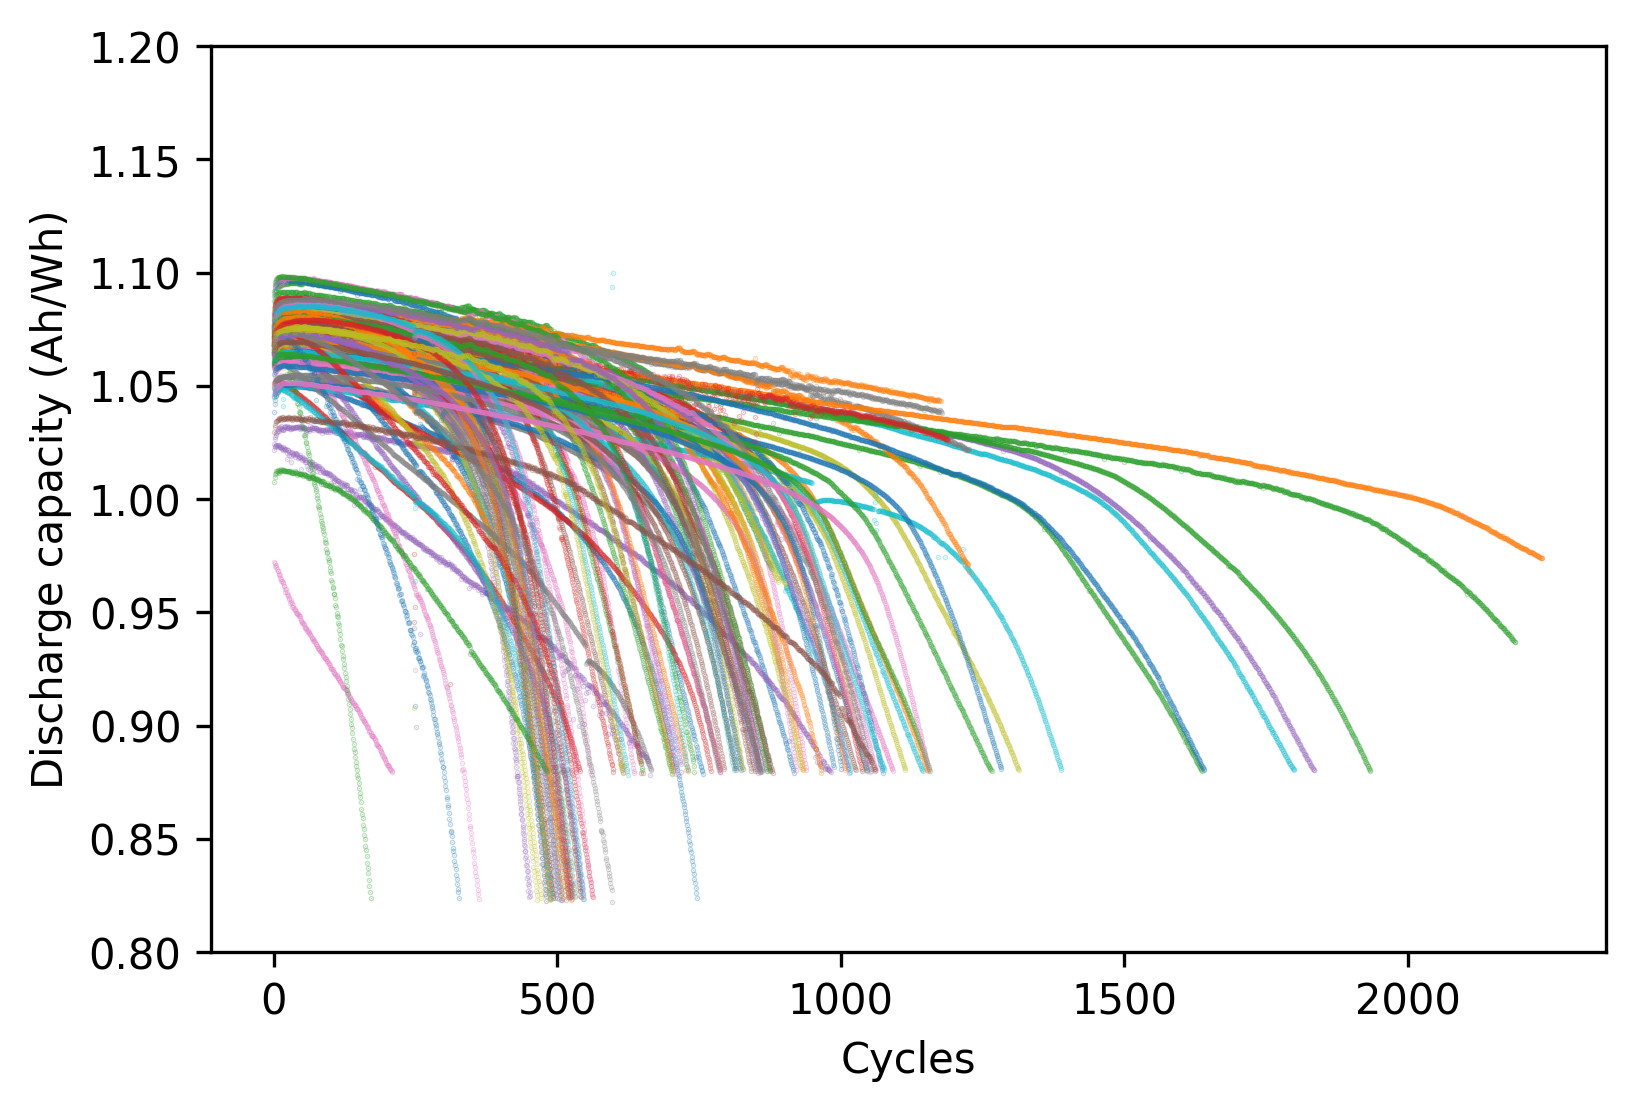

In [18]:
plt.figure(dpi=300, facecolor='white')
for i,c in enumerate(summary_data_list):
    plt.scatter(c['cycle_index'][1:], c['discharge_capacity'][1:], 
                s=0.1, color=f'C{i}', label='actual cycle_index', alpha=0.3)
plt.xlabel('Cycles')
plt.ylabel('Discharge capacity (Ah/Wh)')
plt.ylim([0.8, 1.2])
# plt.savefig(f'media/LFP/LFP_dataset.png', dpi=400, transparent=False)

In [9]:
def index_convoluter(cell, input_window_size=20, output_window_size=20, overlap_cycle_window=False,
                     overlap_size=5, skip_diagnostic_in_window=False):
    '''This function generates a nested list of indices by convolting the cycles based on cycle_window_size. 
        You can choose to have your window of cycles overlap, or skipp the windows that involve diagnostic cycles in between.
    '''
    max_cycle_index = len(cell) #30 #
    print(max_cycle_index)
    if input_window_size < overlap_size:
        raise ValueError(f'If overlapping, overlap_size ({overlap_size}) should be samller than cycle_window_size ({input_window_size}). Please check inputs.')
    if not input_window_size < max_cycle_index:
        raise ValueError(f'cycle_window_size ({input_window_size}) should be samller than maximum number of cycles in cell ({max_cycle_index}). Please check inputs.')
    if overlap_cycle_window:
        non_overlap =  input_window_size - overlap_size
    else:
        non_overlap = input_window_size
    intervals = range(0, max_cycle_index, non_overlap)
    if not skip_diagnostic_in_window:
        input_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size]
    else:
#         skipped_indices = [5, 6, 7, 20]
        skipped_indices = find_renumbedred_index(cell)
        input_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size
                             and not (set(list(range(x, x + cycle_window_size))[:-1]) & set(skipped_indices))]
    output_covolutions = [list(range(x[-1]+1, x[-1] + output_window_size +1)) for x in input_covolutions if x[-1] < max_cycle_index- output_window_size]
        
    return input_covolutions[:len(output_covolutions)], output_covolutions

In [61]:
# input_covolutions, output_covolutions  = index_convoluter(cell, overlap_cycle_window=False, 
#                                              overlap_size=10, input_window_size=50, output_window_size=100,
#                                                        skip_diagnostic_in_window=skip_diagnostic_in_window)
# # print(output_covolutions)

In [10]:
def find_slope(cycle_window_label):
    mid_window_index = len(cycle_window_label)//2
    low = np.array(cycle_window_label)[0]
    mid = np.array(cycle_window_label)[mid_window_index]
    high = np.array(cycle_window_label)[-1]
#     print(low[0], mid[0], high[0])
    slope_1 = (mid[1] - low[1]) / (mid[0] - low[0]) # mid_window_index #
    slope_2 = (high[1] - mid[1]) / (mid[0] - low[0]) # mid_window_index
    return slope_1, slope_2

import pickle as pkl
pkl_f_l_filename = f'CACHED_DATA/pickled_cycle_windows/LFP/fearures_labels_inputs_window_{input_window_size}_outputs_window_{output_window_size}.pkl'

# test_conv = True
if not os.path.exists(pkl_f_l_filename):

    skip_diagnostic_in_window = False

    features_columns = ['cycle_index','voltage', 'current']
    label_columns = ['cycle_index', 'discharge_capacity']
    # features = np.empty([0, None,100, 3])
    monitored_cycles_discharge_capacity = []
    labels = np.empty([0, 2])
    cell_features = []
    cell_labels = []
    cell_discharge_caps = []
    initial_discharge_cap_windows = []
    for i, cell in enumerate(tqdm(structured_data_list)):
    #     print(i)
    #     n = len(cell)//cycle_numbers
        cycle_window_features = []
        cycle_window_labels = []
        initial_discharge_cap = []
        cell_cycle_indices = summary_data_list[i]['cycle_index'].values
        input_covolutions, output_covolutions  = index_convoluter(cell, overlap_cycle_window=False, 
                                             overlap_size=10, input_window_size=input_window_size,
                                                                  output_window_size=output_window_size,
                                                       skip_diagnostic_in_window=skip_diagnostic_in_window)
    #     print(len(index_convolution))
#         for j, index_list in enumerate(index_convolution):
        for j, (input_index_list, output_index_list) in enumerate(zip(input_covolutions, output_covolutions)):
    #         if (j < len(index_convolution)-1):
                cycle_window_features.append(list(zip(*[(bye_cycle.interpol_cycle(cell[cycle_index], columns=features_columns, n_points=100)
                                                         , len(cell[cycle_index]))
                                     for cycle_index in input_index_list])))
        #         break
        #         print (index_list)
        #         print(summary_data_list[i][label_columns])
        #         discharge_cap_cycle_window = np.array(summary_data_list[i][label_columns])[index_list]
    #             print(index_convolution[j])
                discharge_cap_cycle_window = np.array(summary_data_list[i][label_columns])[output_index_list]
#                 print(j, discharge_cap_cycle_window )

                cycle_window_labels.append(list([find_slope(discharge_cap_cycle_window), discharge_cap_cycle_window]))
    #         if j == 0:
    #             initial_discharge_cap.append(np.array(summary_data_list[i][label_columns])[index_convolution[j]])
        #         cycle_window_labels.append(discharge_cap_cycle_window)
        #     break
        cell_features.append(cycle_window_features)
        cell_labels.append(cycle_window_labels)
    #     initial_discharge_cap_windows.append(initial_discharge_cap)
#     with open(pkl_f_l_filename, 'wb') as f:
#         pkl.dump([cell_features, cell_labels], f)
else:
    print('Loaded CACHED pickled files for features and labels.')
    with open(pkl_f_l_filename, 'rb') as f:
        [cell_features, cell_labels] = pkl.load(f)  

Loaded CACHED pickled files for features and labels.


In [63]:
# cell = structured_data_list[0]

# def index_convoluter(cell, input_window_size=20, output_window_size=20, overlap_cycle_window=False, 
#                      overlap_size=5, skip_diagnostic_in_window=False):
#     '''This function generates a nested list of indices by convolting the cycles based on cycle_window_size. 
#         You can choose to have your window of cycles overlap, or skipp the windows that involve diagnostic cycles in between.
#     '''
# #     input_window_size = 20
#     output_window_size = 40
#     max_cycle_index = len(cell) #30 #
#     print(max_cycle_index)
#     if cycle_window_size < overlap_size:
#         raise ValueError(f'If overlapping, overlap_size ({overlap_size}) should be samller than cycle_window_size ({input_window_size}). Please check inputs.')
#     if not cycle_window_size < max_cycle_index:
#         raise ValueError(f'cycle_window_size ({input_window_size}) should be samller than maximum number of cycles in cell ({max_cycle_index}). Please check inputs.')
#     if overlap_cycle_window:
#         non_overlap =  input_window_size - overlap_size
#     else:
#         non_overlap = input_window_size
#     intervals = range(0, max_cycle_index, non_overlap)
#     if not skip_diagnostic_in_window:
#         index_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size]
#     else:
# #         skipped_indices = [5, 6, 7, 20]
#         skipped_indices = find_renumbedred_index(cell)
#         index_covolutions = [list(range(x, x + input_window_size)) for x in intervals if x <= max_cycle_index-input_window_size
#                              and not (set(list(range(x, x + cycle_window_size))[:-1]) & set(skipped_indices))]
#     output_covolutions = [list(range(x[-1]+1, x[-1] + output_window_size +1)) for x in index_covolutions if x[-1] < max_cycle_index- output_window_size]
        
#     return index_covolutions[:len(output_covolutions)], output_covolutions

# input_window_size = 20
# output_window_size = 50
# index_convolution, output_covolution = index_convoluter(cell, overlap_cycle_window=False, 
#                                      overlap_size=10, input_window_size=input_window_size,
#                                                skip_diagnostic_in_window=False)
# # print(index_convolution)

In [64]:
# # print(index_convolution[-1])
# for m,n in zip(index_convolution, output_covolution):
#     print(m,n)

In [65]:
# from sklearn.model_selection import KFold
# # kf = KFold(n_splits=5)
# kf = KFold(n_splits=5, random_state=1, shuffle=True)
# for train_index, test_index in kf.split(prepared_data):
#     train_size = 0.9
#     n_train = int(train_size*len(train_index))
#     val_index = train_index[n_train:]
#     train_index = train_index[:n_train]
#     print(len(train_index), len(val_index), len(test_index))
#     print(type(prepared_data))
# #     test_cells = prepared_data[list(test_index)]
#     train_cells = [prepared_data[c] for c in train_index]
#     val_cells = [prepared_data[c] for c in val_index]
#     test_cells = [prepared_data[c] for c in test_index]
#     print(len(test_cells))
#     break
#     print(len(test_index))
#     print(len(test_index))
#     print(len(train_index))
#     break

In [11]:
import random
prepared_data = list(zip(cell_features, cell_labels))

random.seed(0)
shuffled_indices = list(range(len(prepared_data)))
random.shuffle(prepared_data)

train_size = 0.9
val_size = 0.2
N_train = int(train_size *len(prepared_data))
N_val = int(val_size * N_train)
train_cells = prepared_data[:N_train]
test_cells = prepared_data[N_train:]

val_cells = train_cells[:N_val]
train_cells = train_cells[N_val:]
print(len(train_cells), len(val_cells), len(test_cells), len(train_cells)+len(test_cells)+len(val_cells))

100 25 14 139


In [12]:
def scale(inputs, scaler=None):
    from sklearn import preprocessing
    inputs_shape = inputs.shape
    if scaler is None:
        scaler = preprocessing.StandardScaler().fit(inputs.reshape(-1, inputs_shape[-1]))
    scaled_input = scaler.transform(inputs.reshape(-1, inputs_shape[-1])).reshape(inputs_shape)
    return scaler, scaled_input

def rev_scale(scaled_inputs, scaler):
    scaled_inputs_shape = scaled_inputs.shape
    origin_inputs = scaler.inverse_transform(scaled_X_train_time_series.reshape(-1, scaled_inputs_shape[-1]))
    return origin_inputs.reshape(scaled_inputs_shape)



def standardize_train(inputs):
    fstd = np.std(inputs, axis=0)
    fmean = np.mean(inputs, axis=0)
    std_features = (inputs - fmean) / fstd
    return std_features, fmean, fstd

def standardize_non_train(inputs, fmean_train, fstd_train):
    std_features = (inputs - fmean_train) / fstd_train
    return std_features

def de_standardize_non_train(inputs, fmean_train, fstd_train):
    return inputs*fstd_train + fmean_train

def make_feature_arrays(data):
    X_dt_values = []
    X_time_series = []
    for X in data:
        X_dt_values.append(X[1])
        X_time_series.append(X[0])
#         break
    return np.array(X_time_series), np.array(X_dt_values)

def make_label_arrays(data):
    slopes = []
    discharge_cap = []
    for Y in data:
        discharge_cap.append(Y[1])
        slopes.append(Y[0])
    return np.array(discharge_cap), np.array(slopes)

X_train = [x for xs in train_cells for x in xs[0]]
# Y_train = np.array([x for xs in train_cells for x in xs[1]])
Y_train = [x for xs in train_cells for x in xs[1]]
dc_train, slopes_train = make_label_arrays(Y_train)
X_train_time_series, X_train_dt = make_feature_arrays(X_train)
# print(X_train_time_series[-1][-1])
print(dc_train[-1][0])
# print(X_train_time_series[0])
# import random
# random.seed(0)
# indices = list(range(len(X_train_time_series)))
# random.shuffle(indices)
print(f'len features {len(X_train_time_series)}')
# X_train_time_series = X_train_time_series[indices]
# X_train_dt = X_train_dt[indices]


# slopes_train = slopes_train[indices]
# standardized_train_slopes, mean_train_slopes, std_train_slopes= standardize_train(slopes_train)
# dc_train = dc_train[indices]
print(X_train_time_series[0,0,0,0])
print(dc_train[0][0])

X_val = [x for xs in val_cells for x in xs[0]]
# Y_val= np.array([x for xs in val_cells for x in xs[1]])
Y_val = [x for xs in val_cells for x in xs[1]]
dc_val, slopes_val = make_label_arrays(Y_val)
# standardized_val_slopes= standardize_non_train(slopes_val, mean_train_slopes, std_train_slopes)
X_val_time_series, X_val_dt = make_feature_arrays(X_val)

X_test = [x for xs in test_cells for x in xs[0]]
# Y_test= np.array([x for xs in test_cells for x in xs[1]])
Y_test = [x for xs in test_cells for x in xs[1]]
dc_test, slopes_test = make_label_arrays(Y_test)
# standardized_test_slopes= standardize_non_train(slopes_test, mean_train_slopes, std_train_slopes)
X_test_time_series, X_test_dt = make_feature_arrays(X_test)

f_scaler, scaled_X_train_time_series = scale(X_train_time_series[...,1:])
_ , scaled_X_val_time_series = scale(X_val_time_series[...,1:], f_scaler)
_ , scaled_X_test_time_series = scale(X_test_time_series[...,1:], f_scaler)
# scaled_X_val_time_series = scaler.transform(X_val_time_series[...,1:])

l_scaler, scaled_slopes_train = scale(slopes_train)
_ , scaled_slopes_val = scale(slopes_val, l_scaler)
_ , scaled_slopes_test = scale(slopes_test, l_scaler)

[850.      0.971]
len features 1514
0.0
[50.     1.091]


In [14]:
# for i,x in enumerate(X_train_time_series):
#     print(x.shape)
#     break
def prepare_self_supervised_data(time_series_data):
    input_shape = time_series_data.shape
    if input_shape[0] % 2 != 0:
        time_series_data = time_series_data[:-1]
#         input_shape = time_series_data.shape

    time_shape = input_shape[1] * input_shape[2]
    features_1 = time_series_data[::2]
    labels_1 = time_series_data[1::2]
   
    features_2 = time_series_data[1:][::2][:-1]
    labels_2 =  time_series_data[1:][1::2]
#     print(features_2[-1])
#     print('\n \n \n \n')
#     print(labels_2[-1])
    time_series_features = np.concatenate([features_1, features_2]).reshape(-1, time_shape, input_shape[-1])
    time_series_labels = np.concatenate([labels_1, labels_2]).reshape(-1,time_shape, 3)
    print(time_series_features.shape, time_series_labels.shape)
    return time_series_features, time_series_labels

train_features, train_labels = prepare_self_supervised_data(X_train_time_series)
val_features, val_labels = prepare_self_supervised_data(X_val_time_series)
test_features, test_labels = prepare_self_supervised_data(X_test_time_series)


f_scaler, scaled_train_features = scale(train_features[...,1:])
_ , scaled_train_labels = scale(train_labels[...,1:], f_scaler)

_ , scaled_val_features = scale(val_features[...,1:], f_scaler)
_ , scaled_val_labels = scale(val_labels[...,1:], f_scaler)

_ , scaled_test_features = scale(test_features[...,1:], f_scaler)
_ , scaled_test_labels = scale(test_labels[...,1:], f_scaler)

(1513, 5000, 3) (1513, 5000, 3)
(395, 5000, 3) (395, 5000, 3)
(165, 5000, 3) (165, 5000, 3)


In [15]:
L = None
T = 100
def build_model(L, T, cycle_window_size=10, reg_strength=0, num_features=2):
    inputs = tf.keras.Input(shape=(cycle_window_size*T,num_features))
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(inputs)
    x = tf.keras.layers.Dense(cycle_window_size*T*num_features
                         ,activation=None,
                             kernel_regularizer=tf.keras.regularizers.L2(l2=reg_strength))(x)  # kernel_initializer=tf.initializers.zeros()
    yhat = tf.keras.layers.Reshape([cycle_window_size*T, num_features])(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat)
    return model
model = build_model(L, T, cycle_window_size=input_window_size, reg_strength=0.01)
opt = tf.optimizers.Adam(1e-3)
model.compile(opt, loss='mae')
model.summary()

2022-08-08 15:07:09.797825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 15:07:09.799500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 15:07:09.801138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 15:07:09.802743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 15:07:09.804368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 2)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               8960      
 l)                                                              
                                                                 
 dense (Dense)               (None, 10000)             650000    
                                                                 
 reshape (Reshape)           (None, 5000, 2)           0         
                                                                 
Total params: 658,960
Trainable params: 658,960
Non-trainable params: 0
_________________________________________________________________


In [16]:
result = model.fit( 
#     balanced_X_train_time_series, balanced_slopes_train, # standardize

    scaled_train_features, scaled_train_labels, # standardize
    validation_data=(scaled_val_features, scaled_val_labels), 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=5)],
    epochs=200, batch_size=16)

Epoch 1/200


2022-08-08 15:07:32.744254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


95/95 [==============================] - 85s 841ms/step - loss: 0.8959 - val_loss: 0.7090 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 79s 832ms/step - loss: 0.6830 - val_loss: 0.6328 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 79s 833ms/step - loss: 0.6174 - val_loss: 0.5660 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - 79s 834ms/step - loss: 0.5568 - val_loss: 0.5035 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 79s 833ms/step - loss: 0.5059 - val_loss: 0.4548 - lr: 0.0010
Epoch 6/200
95/95 [==============================] - 79s 833ms/step - loss: 0.4655 - val_loss: 0.4135 - lr: 0.0010
Epoch 7/200
95/95 [==============================] - 79s 833ms/step - loss: 0.4329 - val_loss: 0.3822 - lr: 0.0010
Epoch 8/200
95/95 [==============================] - 79s 832ms/step - loss: 0.4069 - val_loss: 0.3546 - lr: 0.0010
Epoch 9/200
95/95 [==============================] - 79s 832ms/step - loss: 0.3837 - val_los

48/48 [==============================] - 21s 447ms/step - loss: 0.2777


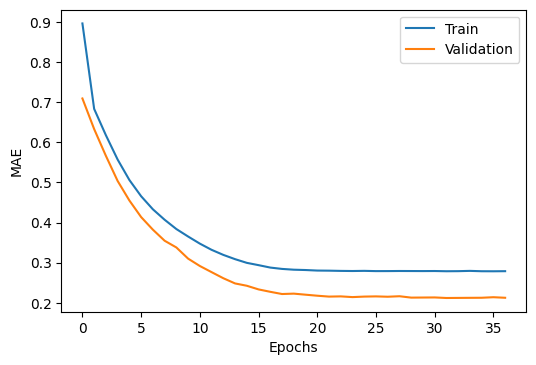

In [17]:
plt.figure(dpi=100, facecolor='white')
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')
slope_mae = model.evaluate(scaled_train_features, scaled_train_labels)
# plt.savefig(f'media/LFP/img/gen_loss_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

In [68]:
# loading trained slopes model
# output_window_size = 50
from tensorflow.keras.models import model_from_json
with open(f"saved_models/LFP/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}.json", "r") as f:
    slopes_model_json = f.read()

slopes_model = model_from_json(slopes_model_json)
# load weights into new model
slopes_model.load_weights(f"saved_models/LFP/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}.h5")
print("Loaded slopes model from disk.")

Y_hat_test = slopes_model.predict(scaled_X_test_time_series)
Y_hat_test = l_scaler.inverse_transform(Y_hat_test)

Loaded slopes model from disk.
6/6 [==============================] - 2s 16ms/step


In [110]:
next_scaled_X_test_time_series = model.predict(scaled_X_test_time_series.reshape(-1,5000,2))#.reshape(-1,50,100,2)
# Y_hat_test = f_scaler.inverse_transform(Y_hat_test)

6/6 [==============================] - 3s 438ms/step


In [143]:
true_scaled = scaled_X_test_time_series.reshape(-1,5000,2)[5][100:700]
prediced_scaled = next_scaled_X_test_time_series[5][100:700]

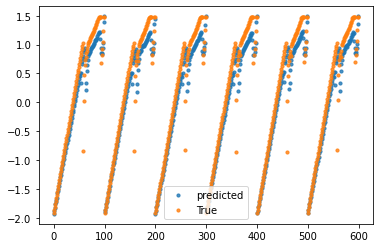

In [144]:
plt.scatter(range(prediced_scaled.shape[0]), prediced_scaled[:,0], s=10, alpha=.8, color='C0', label='predicted')
plt.scatter(range(true_scaled.shape[0]), true_scaled[:,0], s=10, alpha=.8, color='C1', label='True')
plt.legend()

In [69]:
# testing on data
test_cell_number = 5
tested_cell = [test_cells[test_cell_number]]

X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)


all_test_slopes = [y[0] for y in Y_tested_cell]
all_test_dc = np.array([y[1] for y in Y_tested_cell])
_, scaled_X_tested_cell_time_series = scale(X_tested_cell_time_series[...,1:], f_scaler)
Y_hat_tested_cell = slopes_model.predict(scaled_X_tested_cell_time_series)
Y_hat_tested_cell = l_scaler.inverse_transform(Y_hat_tested_cell)

1/1 [==============================] - 0s 47ms/step


In [70]:
Y_hat_test_cell = slopes_model.predict(scaled_X_tested_cell_time_series[0][np.newaxis,...])
# Y_hat_tested_cell = l_scaler.inverse_transform(Y_hat_tested_cell)
# Y_hat_tested_cell

1/1 [==============================] - 0s 49ms/step


In [71]:
next_scaled_X_test_time_series = scaled_X_tested_cell_time_series[0][np.newaxis,...]
for i in range(10):
    next_scaled_X_test_time_series = model.predict(next_scaled_X_test_time_series.reshape(-1,5000,2)).reshape(-1,50,100,2)
    print(next_scaled_X_test_time_series[0,0,0], next_scaled_X_test_time_series[0,10,12])

1/1 [==============================] - 1s 1s/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 377ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]
1/1 [==============================] - 0s 376ms/step
[-1.881 -0.642] [-1.346 -0.646]


In [40]:
Y_hat_test_cell

array([[0.203, 0.269]], dtype=float32)

In [42]:
l_scaler.inverse_transform(Y_hat_tested_cell).shape

(13, 2)

1/1 [==============================] - 0s 49ms/step
predicted slope: -5.4985055612633005e-05, True slope: -2.5192000000000548e-05
predicted slope: -5.769104609498754e-05, True slope: -2.3179999999998203e-05
[[50.0, 1.0806258], [74.5, 1.0792786661374905], [99.0, 1.0778652355081633]]
1/1 [==============================] - 0s 48ms/step
predicted slope: -5.4984968301141635e-05, True slope: -3.643199999999957e-05
predicted slope: -5.769094423158094e-05, True slope: -3.895599999999888e-05
[[100.0, 1.0794187], [124.5, 1.078071568276622], [149.0, 1.0766581401429483]]
1/1 [==============================] - 0s 47ms/step
predicted slope: -5.498498285305686e-05, True slope: -2.381199999999417e-05
predicted slope: -5.769095878349617e-05, True slope: -6.445600000000162e-05
[[150.0, 1.0775008], [174.5, 1.0761536679201], [199.0, 1.0747402394299044]]
1/1 [==============================] - 0s 48ms/step
predicted slope: -5.498498285305686e-05, True slope: -4.963599999999957e-05
predicted slope: -5.769095

cp: ‘media/LFP/img/gen_discharge_curve_in_50_out_50_window_test_5_0012.png’ and ‘media/LFP/img/gen_discharge_curve_in_50_out_50_window_test_5_0012.png’ are the same file
ffmpeg version 5.0.1-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxm

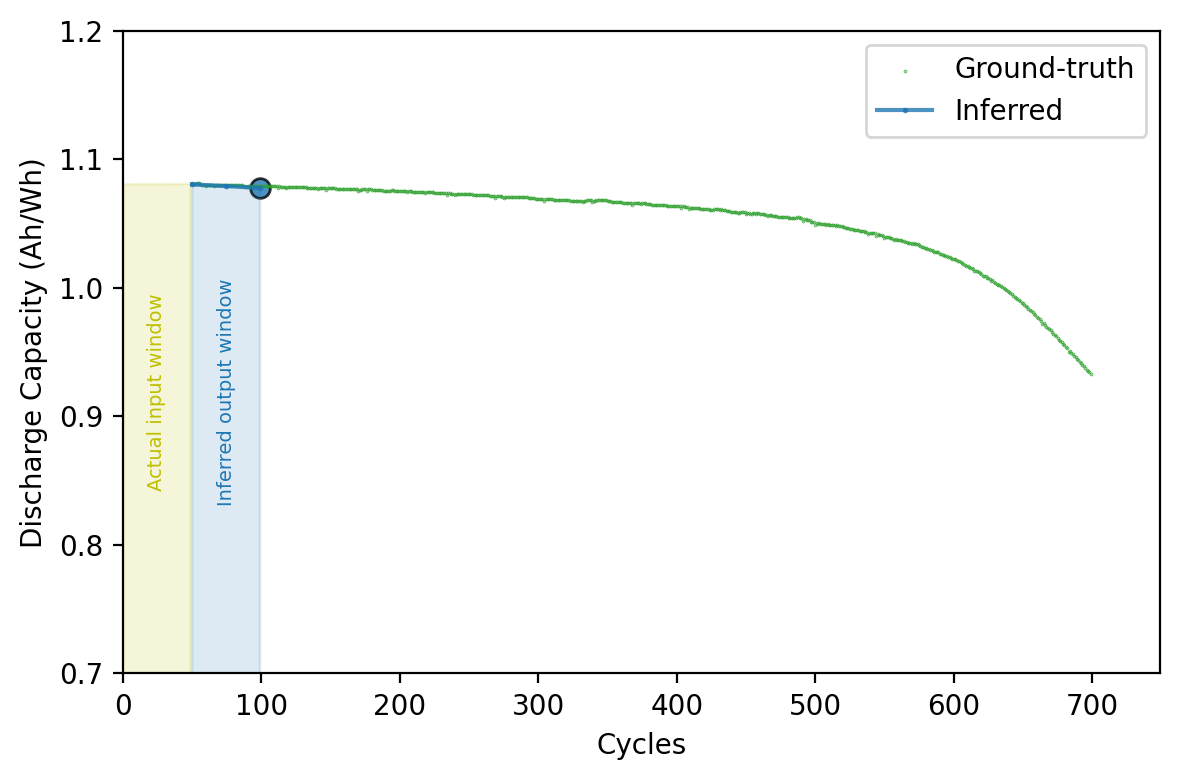

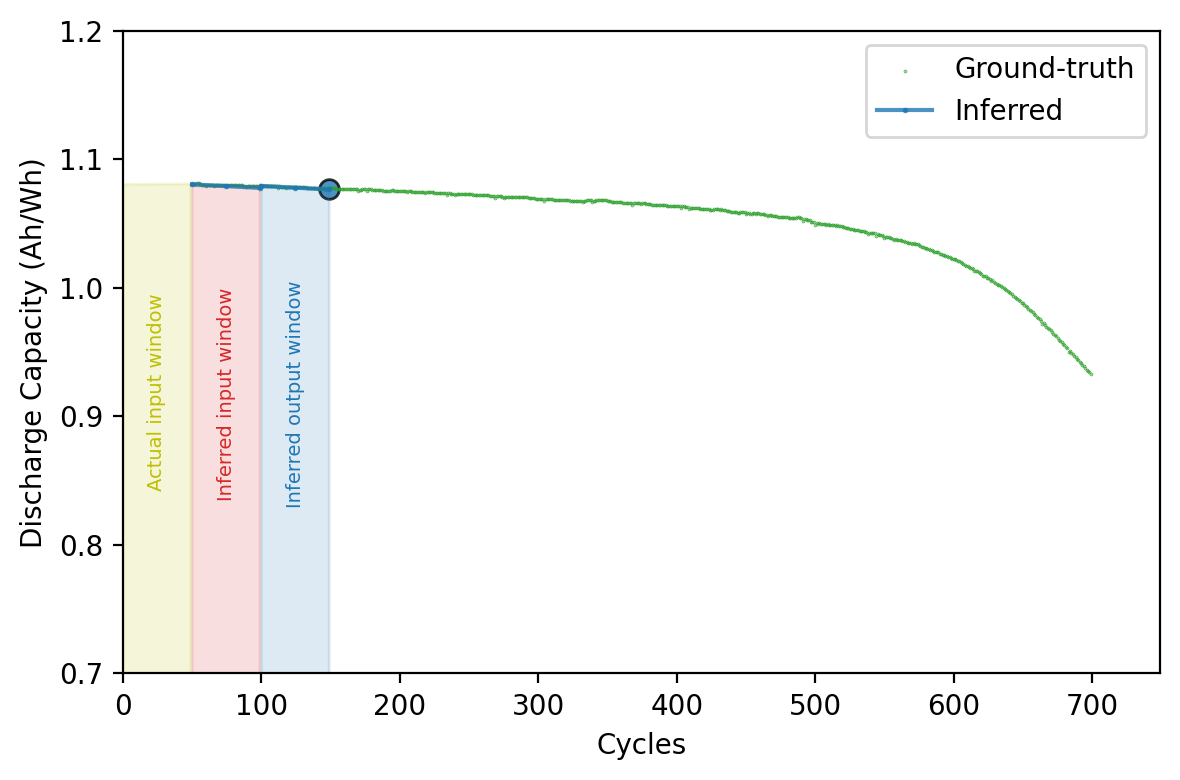

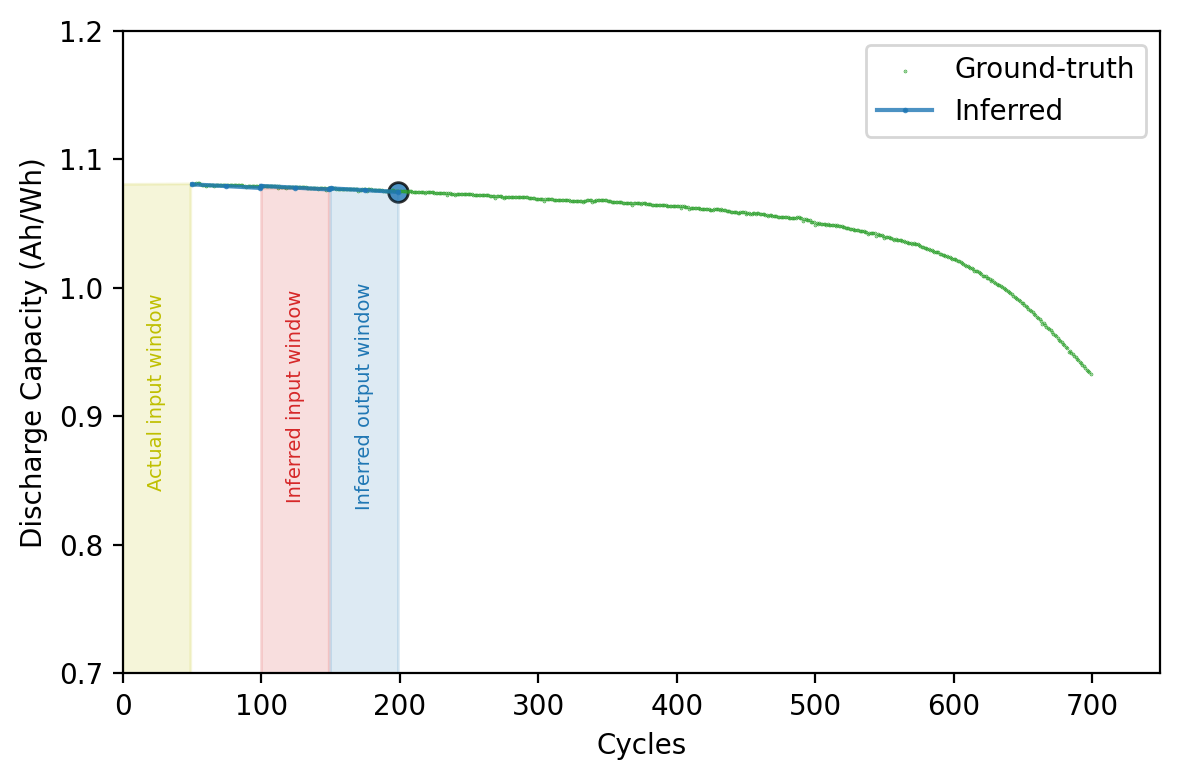

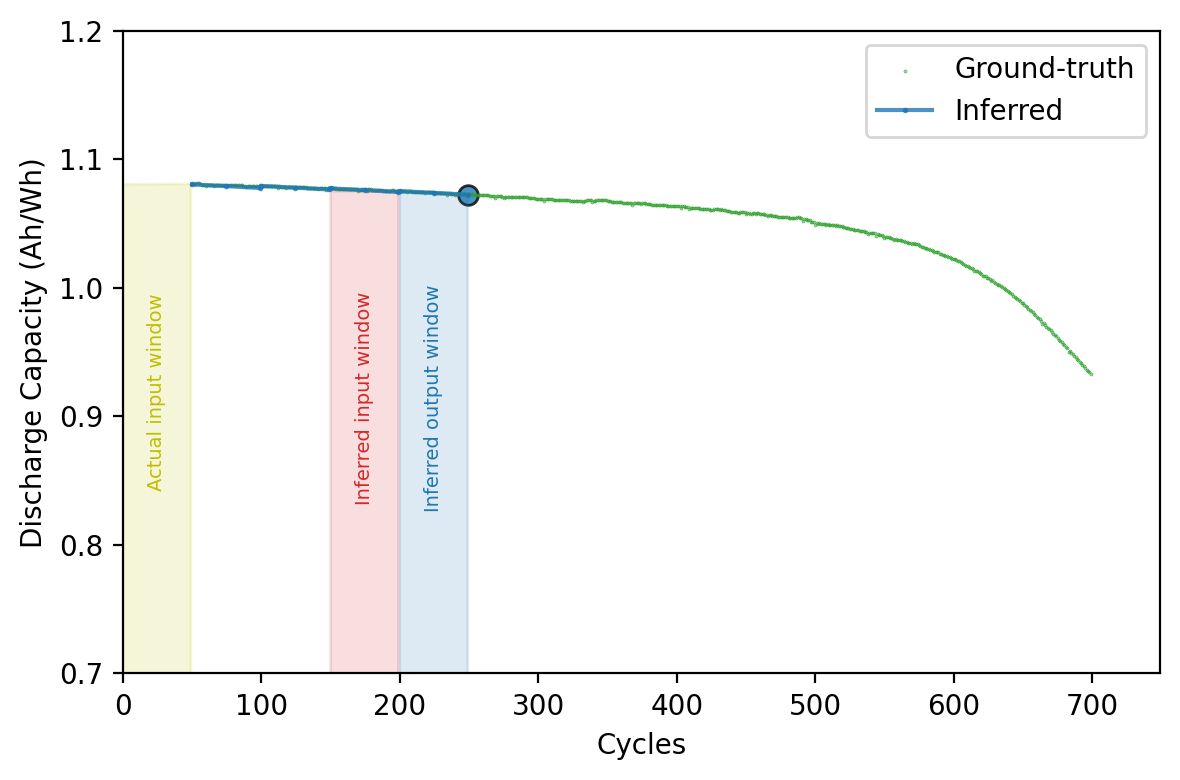

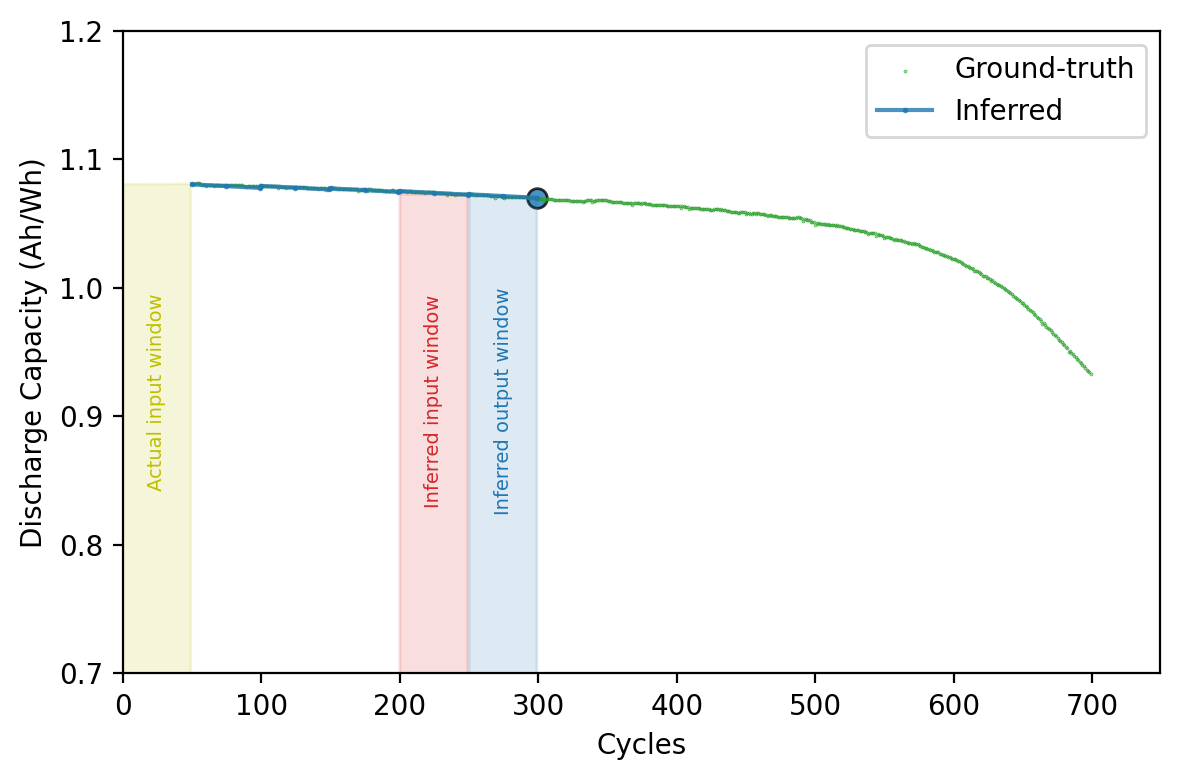

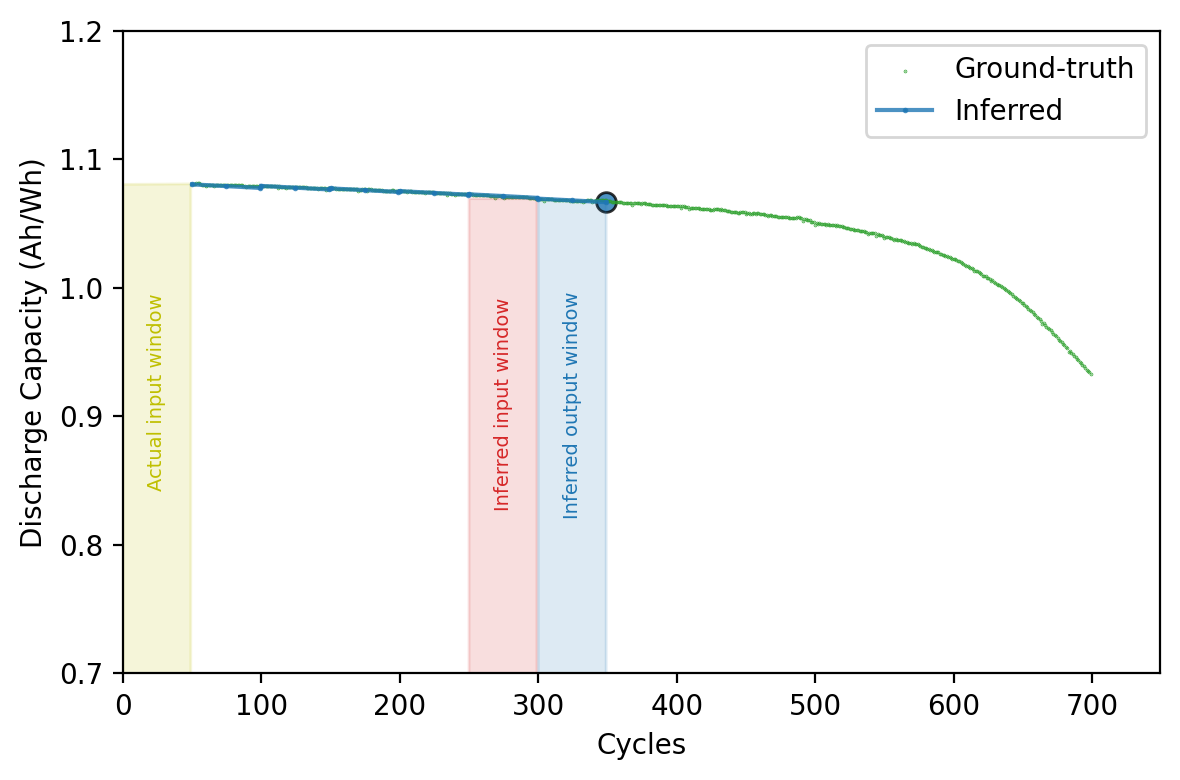

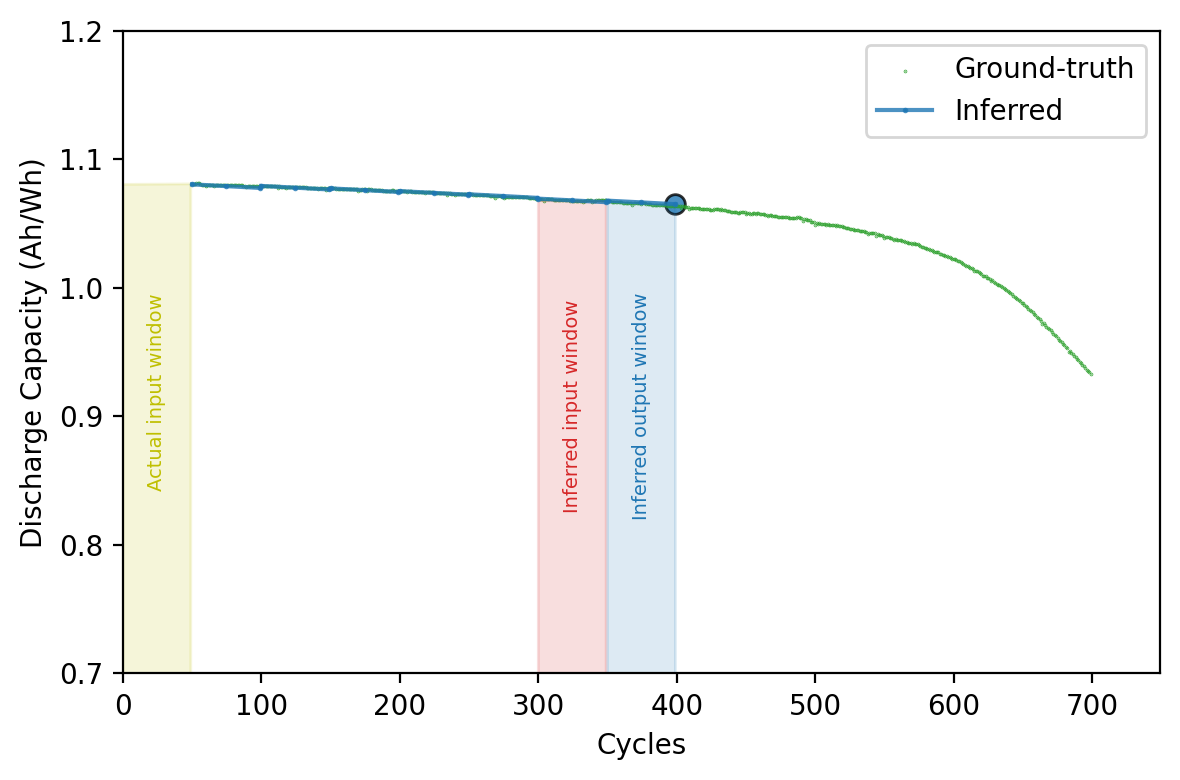

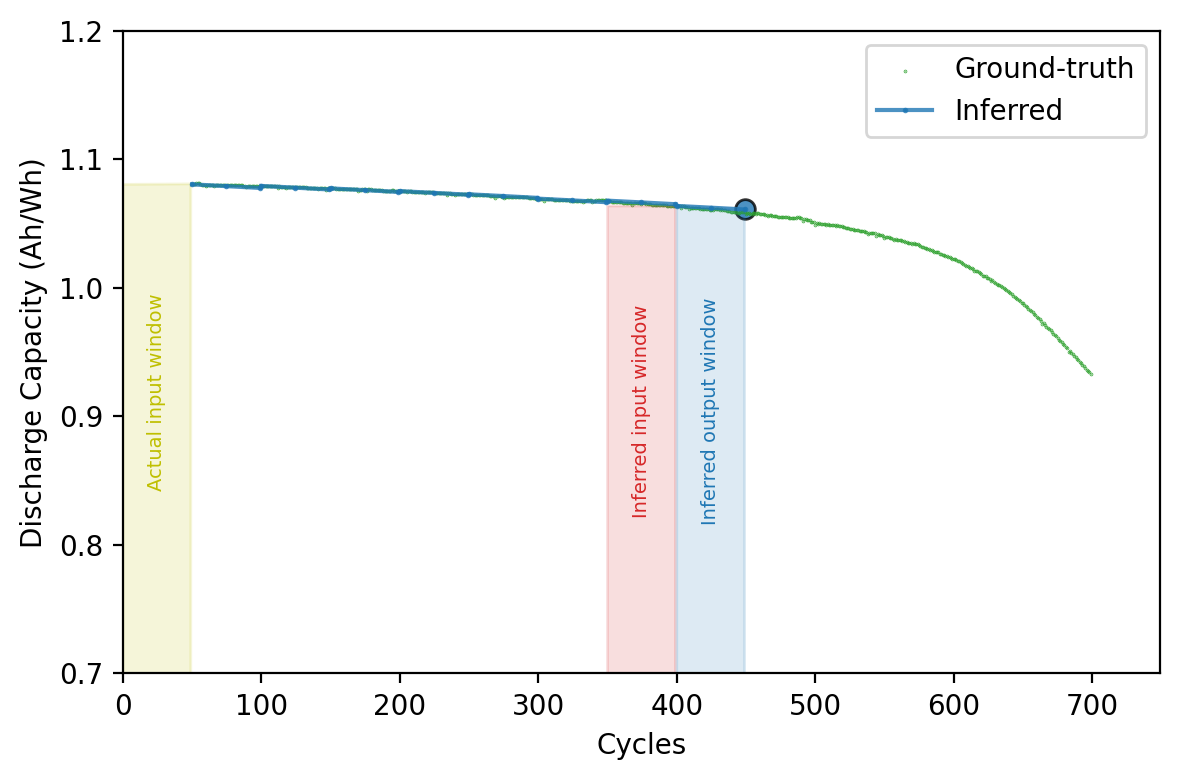

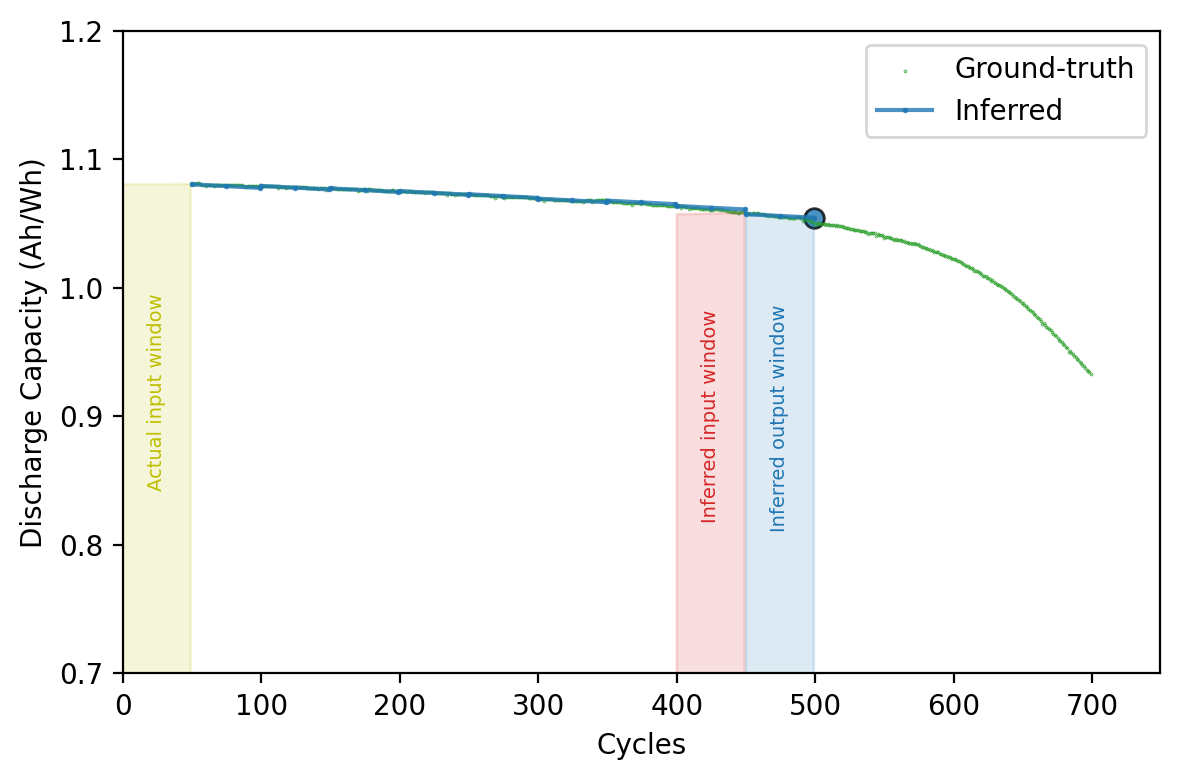

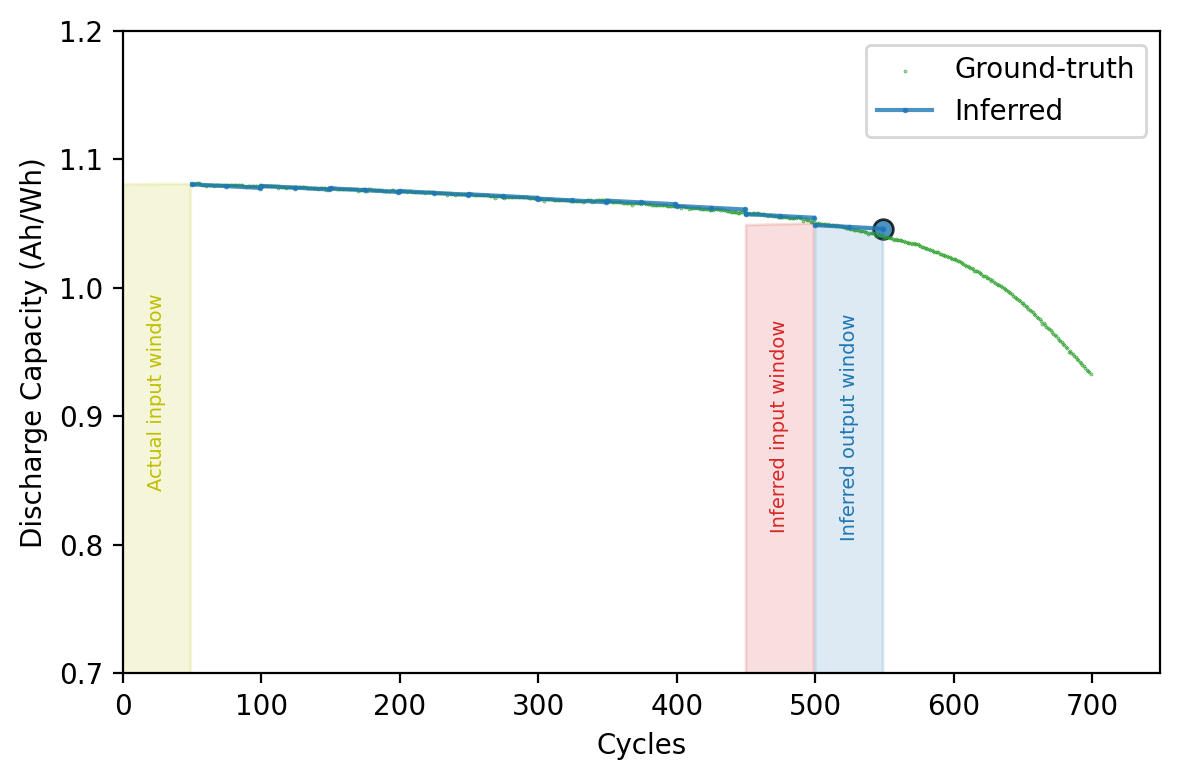

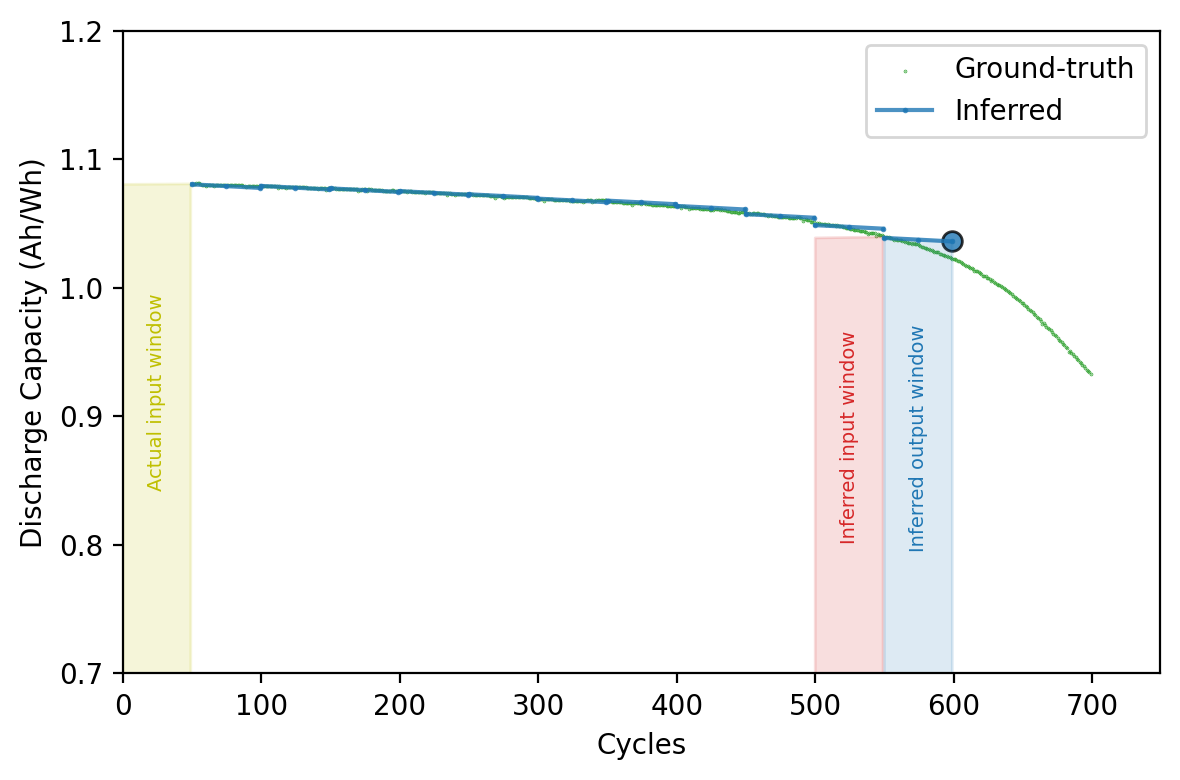

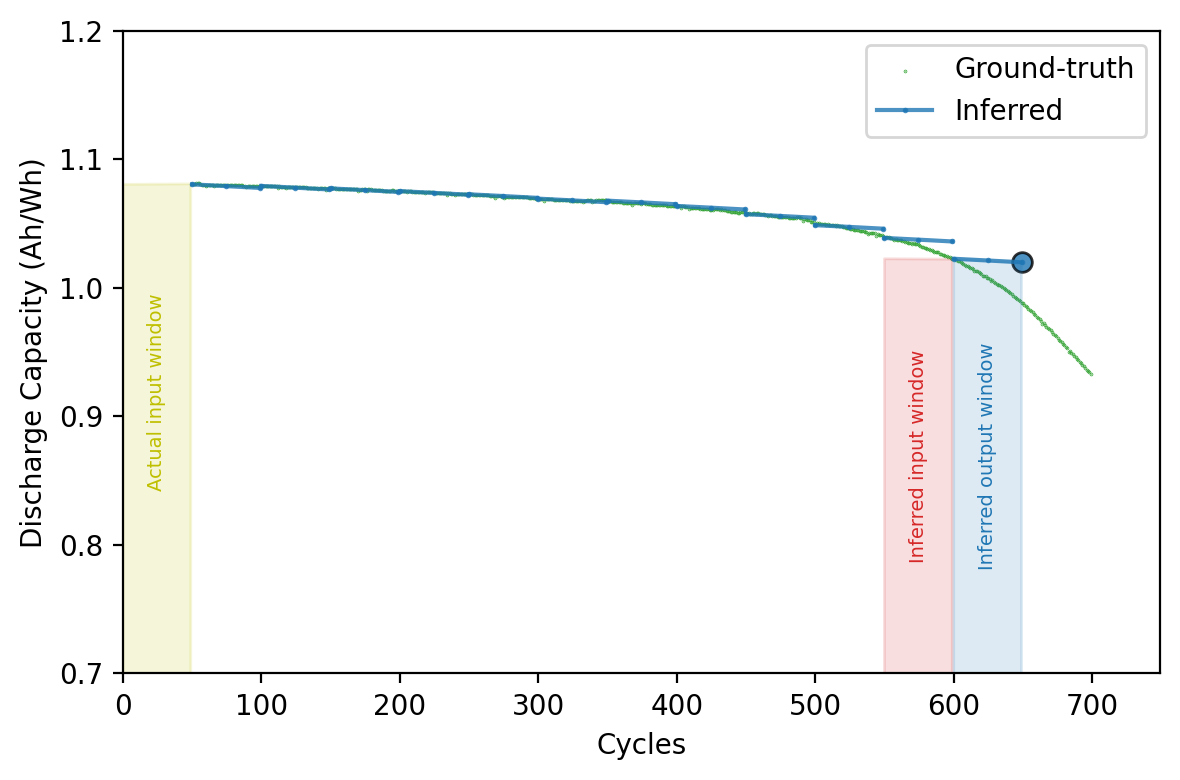

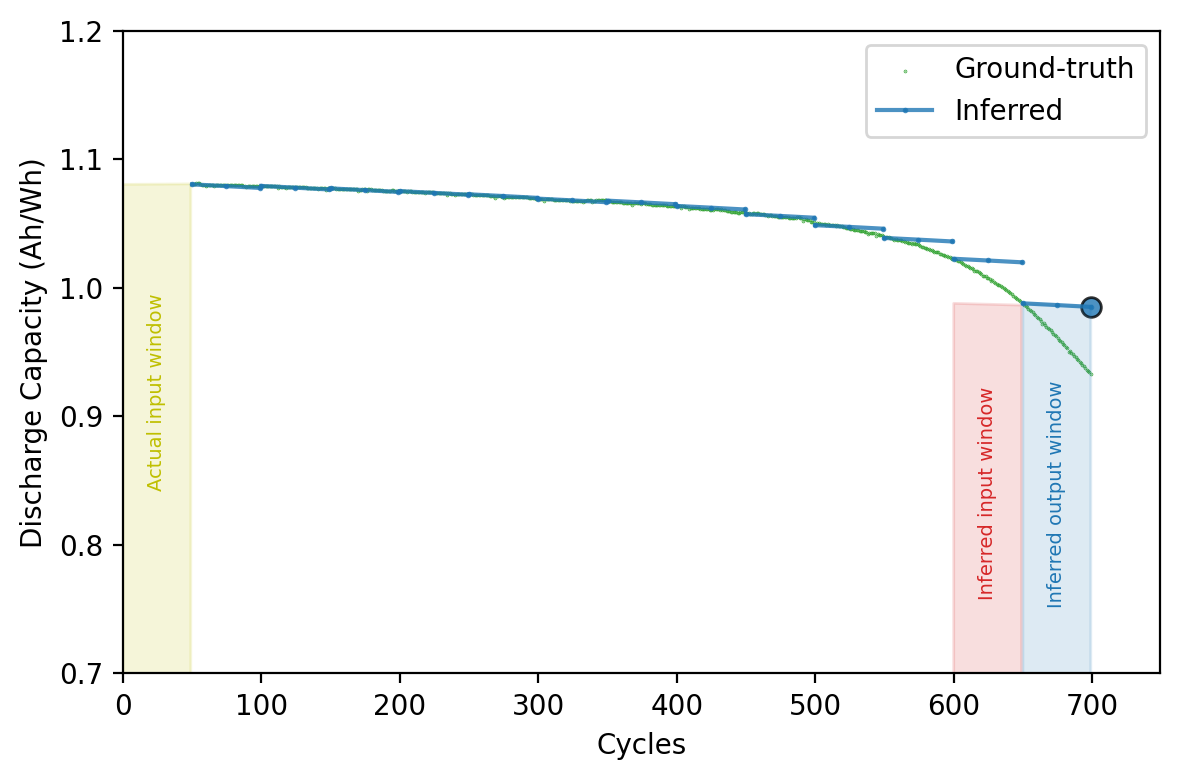

In [81]:
def linear_fit(new_x_point, slope, point_xy):
    return slope*(new_x_point-point_xy[0]) + point_xy[1]

def eval_dc_reconstruction(predicted_dc, ground_truth_dc):
    ground_truth_dc = np.unique(ground_truth_dc, axis=0)
    from scipy.interpolate import interp1d
    f = interp1d(ground_truth_dc[:,0], ground_truth_dc[:,1], kind='cubic')
    interpolated_dc_ground_truth = f(predicted_dc[:,0])
    return np.sqrt(((interpolated_dc_ground_truth - predicted_dc[:,1]) ** 2).mean())


all_predicted_dc_values = []
max_cycle_index = all_test_dc.reshape([-1,2])[-1,0]
next_scaled_X_test_time_series = scaled_X_tested_cell_time_series[0][np.newaxis,...]
for i,m in enumerate(all_test_dc):
#     print(next_scaled_X_test_time_series[0,0,0])
    next_scaled_X_test_time_series = model.predict(next_scaled_X_test_time_series.reshape(-1,5000,2)).reshape(-1,50,100,2)
    scaled_predicted_slopes = slopes_model.predict(next_scaled_X_test_time_series)
    predicted_slopes = np.squeeze(l_scaler.inverse_transform(scaled_predicted_slopes))
#     break
#     print(slopes)
    plt.figure(dpi=200, facecolor='white')
    plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=0.1, label='Ground-truth', alpha=0.8) #if i == 0 else "")
    initial_dc = m[0].tolist()
    predicted_dc_values = [initial_dc]
    new_cycle_index = m[0,0]
#     print(slopes)
    for j,slope in enumerate(predicted_slopes):
        new_cycle_index += (output_window_size-1)/2#np.floor(window_size/2)
        new_predicted_dc = linear_fit(new_cycle_index, slope, initial_dc) # slopes_tested_cell[i,j]

        print(f'predicted slope: {slope}, True slope: {np.array(slopes_tested_cell)[i,j]}')
        predicted_dc_values.append([new_cycle_index , new_predicted_dc])
        initial_dc = predicted_dc_values[-1]
#     break
    print(predicted_dc_values)

    all_predicted_dc_values.append(predicted_dc_values)
    plt.plot(*np.array(all_predicted_dc_values).T, color='C0', label='Inferred', #if i == 0 else "",
             marker='o', markersize=1, alpha=0.8)
    plt.scatter(*np.array(predicted_dc_values[-1]).T, c='C0', #if i == 0 else "",
         marker='o', s=50, edgecolor='k', linewidth=1, facecolor='C0', zorder=-1, alpha=0.8)
    plt.xlabel('Cycles')
    plt.ylabel('Discharge Capacity (Ah/Wh)')
    plt.ylim([0.7,1.2])
    plt.xlim([0 , max_cycle_index+50])
    ax = plt.gca()
    hand, labl = ax.get_legend_handles_labels()
    plt.legend(np.unique(labl))
    plt.tight_layout()
    show_input_output_windows = True
    if show_input_output_windows:

        input_window_cycle_index = [all_test_dc[0][0,0] - input_window_size, all_test_dc[0][0,0]-1]
        input_window_dc = [all_test_dc[0][0, -1], all_test_dc[0][1, -1]]
        if i > 0:
            predicted_input_window_cycle_index = [all_test_dc[i][0,0] - input_window_size, all_test_dc[i][0,0]-1]
            predicted_input_window_dc = [all_test_dc[i][0, -1], all_test_dc[i][1, -1]]
            predicted_input_fill_between = plt.fill_between(*list([predicted_input_window_cycle_index, predicted_input_window_dc]), alpha=.15,
                                              edgecolor='C3', color='C3')
            (x0, y0), (x1, y1) = predicted_input_fill_between.get_paths()[0].get_extents().get_points()
            ax.text((x0 + x1) / 2, 0.85*y1, "Inferred input window", ha='center', va='center', fontsize=7, color='C3', rotation=90)
        input_fill_between = plt.fill_between(*list([input_window_cycle_index, input_window_dc]), alpha=.15,
                                              edgecolor='y', color='y')
        (x0, y0), (x1, y1) = input_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.85*y1, "Actual input window", ha='center', va='center', fontsize=7, color='y', rotation=90)

        prediction_fill_between = plt.fill_between(*list(zip(*predicted_dc_values)), alpha=.15, edgecolor='C0', color='C0')
        (x0, y0), (x1, y1) = prediction_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.85*y1, "Inferred output window", ha='center', va='center', fontsize=7, color='C0', rotation=90)

    save_gif = True
    if save_gif:
        plt.savefig(f'media/LFP/img/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i:04d}.png', dpi=400, transparent=False)
#     if i ==20:
        
#         break
#     plt.close()
#     break
#     if i == 2:
        
#     break

# copy last frame
if save_gif:
    for j in range(10):
        os.system(f"cp media/LFP/img/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i:04d}.png media/LFP/img/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i+j:04d}.png")
    os.system(f"ffmpeg -framerate 1 -i media/LFP/img/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_%04d.png -c:v h264 -crf 14 -c:v libx264 -movflags +faststart -vf format=yuv420p -maxrate 50M -tune animation -bufsize 1MB -t 15 -y media/LFP/mp4/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}.mp4")
    os.system(f'ffmpeg -i media/LFP/mp4/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}.mp4 -framerate 1 -vf "fps=24, scale=2000:-1:flags=lanczos" -loop 0 -y media/LFP/gif/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}.gif')
# ffmpeg -i discharge_curve_50_window_test_3.mp4 -r 40 -vf "fps=20, scale=2000:-1:flags=lanczos" -f image2pipe -vcodec ppm - | convert -delay 10 -loop 0 - test.gif

In [80]:
    os.system(f'ffmpeg -i media/LFP/mp4/gen_discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}.mp4 -framerate 1 -vf "fps=24, scale=2000:-1:flags=lanczos" -loop 0 -y media/LFP/gif/gen_discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.gif')


ffmpeg version 5.0.1-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat   

256

In [49]:
predicted_slopes[0]

array([-0., -0.], dtype=float32)

In [274]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

(163, 5000, 2)

In [201]:
features_1.shape

(707, 50, 100, 3)

In [164]:
X_train_time_series[10].shape

(50, 100, 3)

In [82]:
time_series_dat_1 = X_train_time_series[10][0:10].reshape(-1,3)

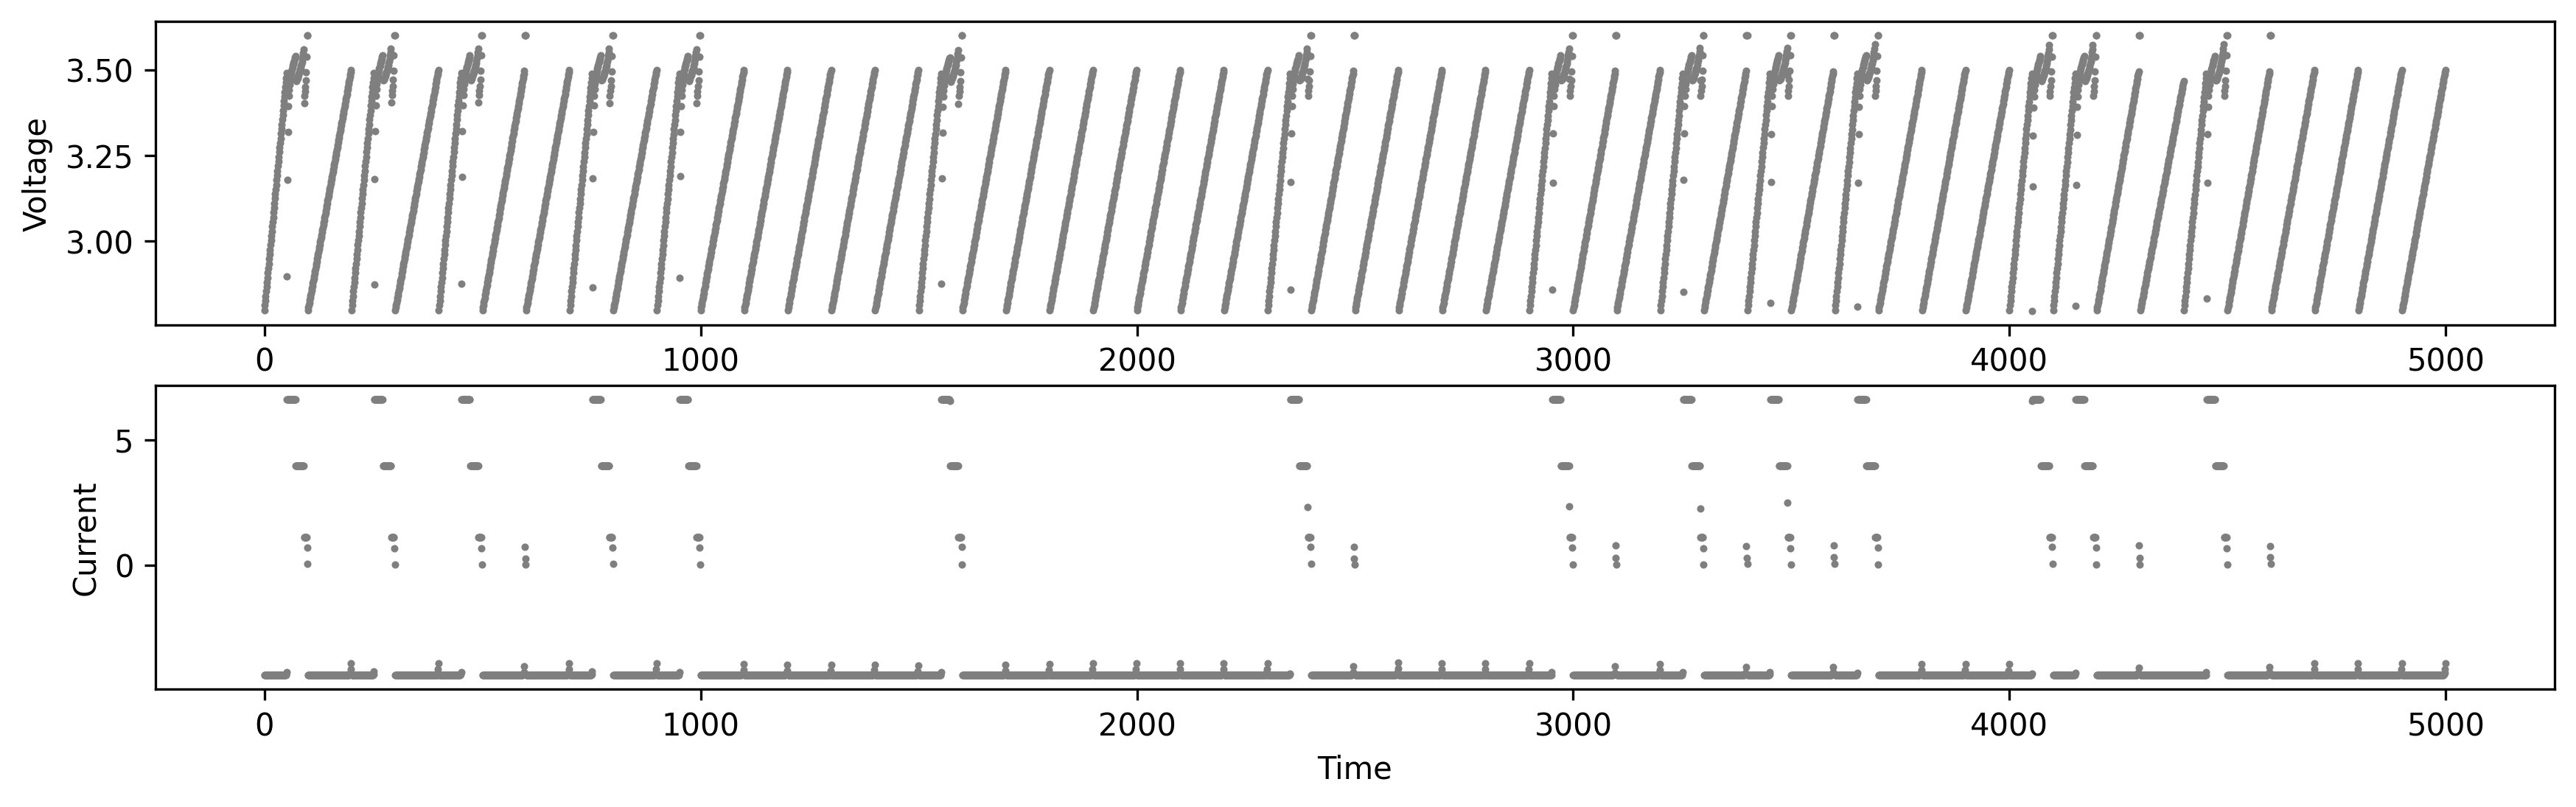

In [83]:
time_series_dat_1 = X_train_time_series[10][0:10].reshape(-1,3)
fig , ax = plt.subplots(2,1, figsize=(14,4), dpi=300, facecolor='white')
ax[0].scatter(np.arange(time_series_dat_1.shape[0]), time_series_dat_1[:,1], color='C7', s=2, marker='o')
ax[0].set_ylabel('Voltage')
ax[1].scatter(np.arange(time_series_dat_1.shape[0]) ,time_series_dat_1[:,2], color='C7', s=2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Current')
xmin, xmax = plt.xlim()
# plt.savefig(f'media/generative.png', dpi=400, transparent=False, bbox_inches="tight")

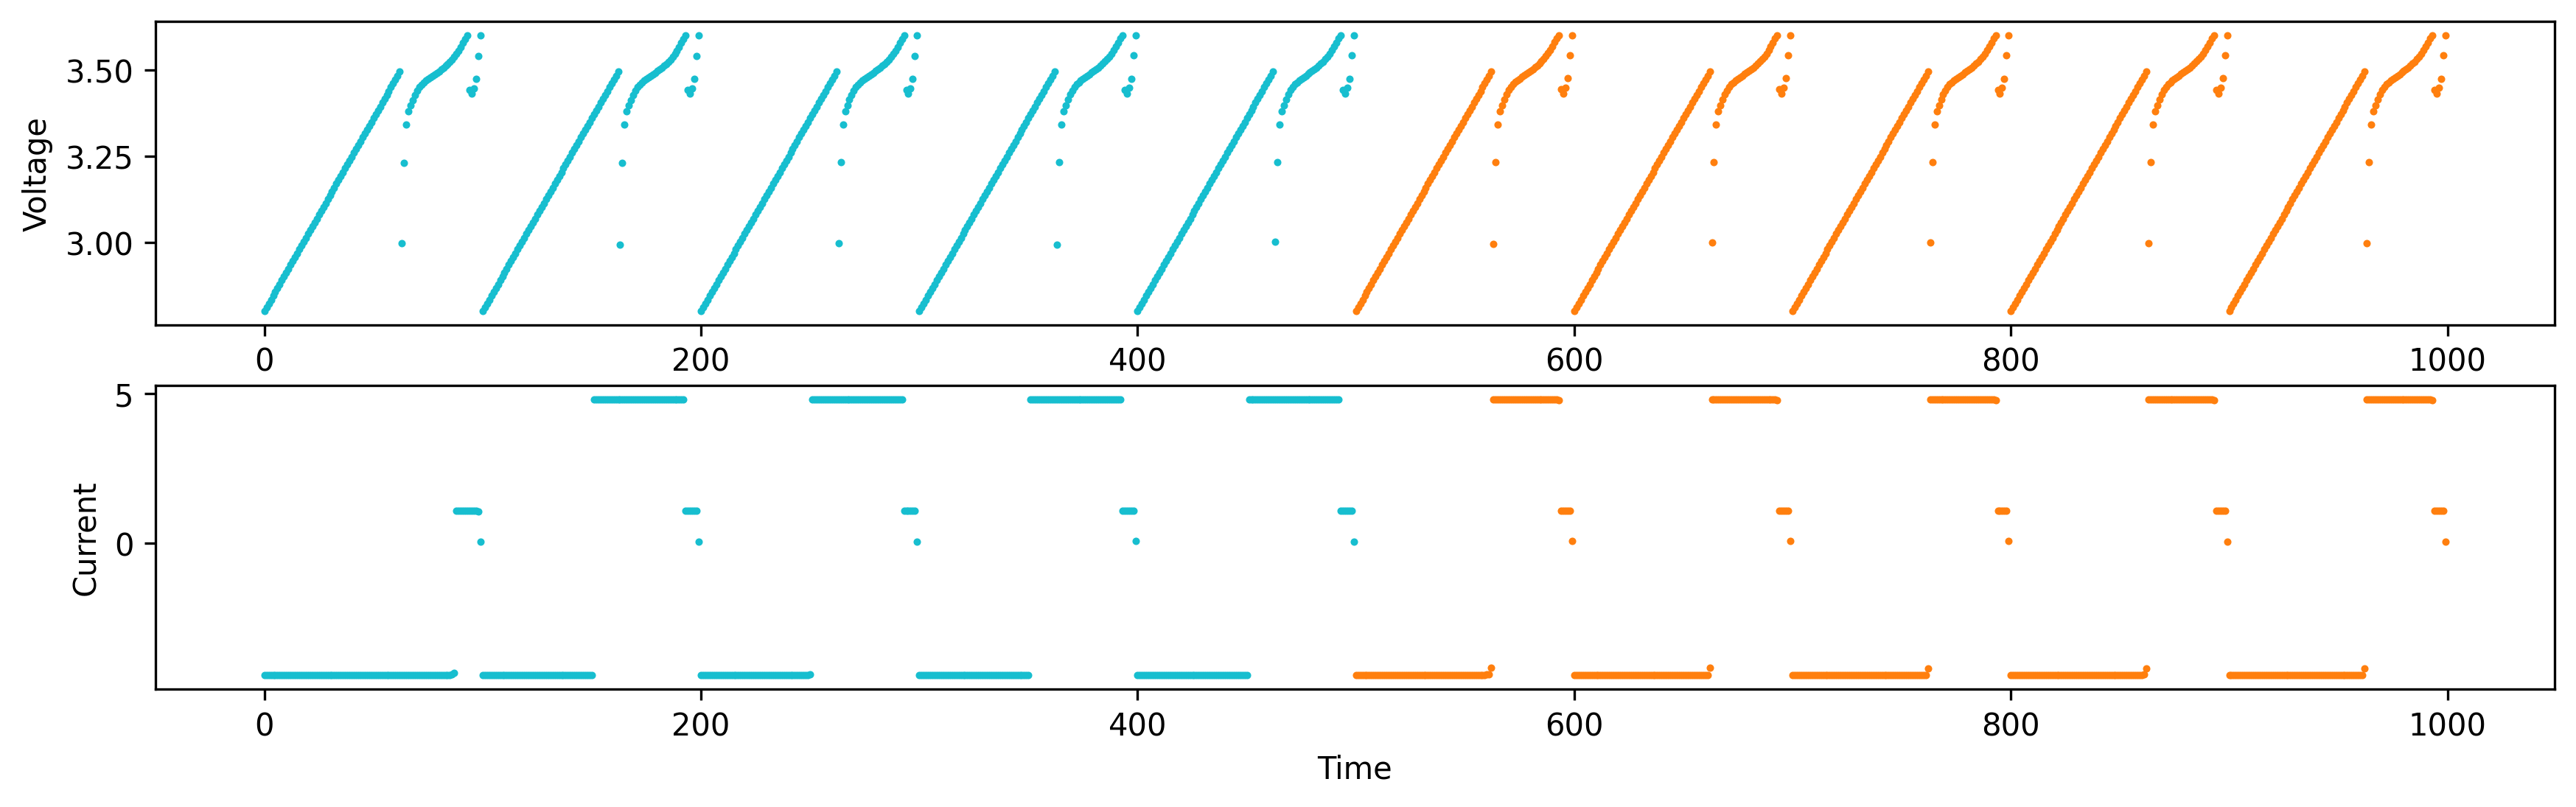

In [162]:
fig , ax = plt.subplots(2,1, figsize=(14,4), dpi=300, facecolor='white')
features_index = time_series_dat_1.shape[0]//2
ax[0].scatter(np.arange(0, features_index),time_series_dat_1[:features_index,1], label='Features', color='C9', s=2)
ax[0].scatter(np.arange(features_index, 2*features_index),time_series_dat_1[features_index:,1], label='Labels', color='C1', s=2)
ax[0].set_ylabel('Voltage')
ax[0].set_xlim([xmin, xmax])
ax[1].scatter(np.arange(0, features_index), a[:features_index,2], label='Features', color='C9', s=2)
ax[1].scatter(np.arange(features_index, 2*features_index), time_series_dat_1[features_index:,2], label='Labels', color='C1', s=2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Current')
ax[1].set_xlim([xmin, xmax])
# plt.legend(markerscale=5, bbox_to_anchor=[1.12,2])
# plt.savefig(f'media/generative_f_l.png', dpi=400, transparent=False, bbox_inches="tight")

In [15]:
scaled_slopes_val.shape

(372, 2)

In [16]:
scaled_X_val_time_series.shape

(372, 50, 100, 2)

Text(0.5, 1.0, 'slope 1')

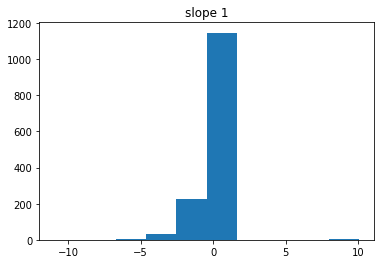

In [17]:
plt.hist(scaled_slopes_train[:,0])
plt.title('slope 1')

Text(0.5, 1.0, 'slope 2')

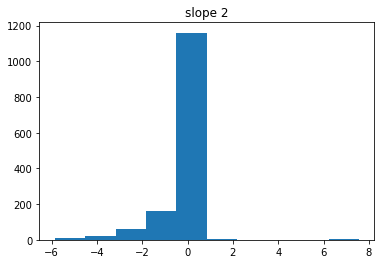

In [18]:
plt.hist(scaled_slopes_train[:,1])
plt.title('slope 2')

In [55]:
def oversample(f_time_series, f_dt, labels, oversample_label_index=1):
    counts, bins, patches = plt.hist(labels[:,oversample_label_index])
    plt.close()
    import numpy_indexed as npi
    import random
    max_samples = max(counts)
    ind = np.digitize(labels[:,oversample_label_index], bins)
    label_groups = npi.group_by(ind).split(labels[:,oversample_label_index])

    balanced_f_time_series = f_time_series
    balanced_labels = labels
    balanced_f_dt = f_dt
    for sg in tqdm(label_groups[:-2]):
        n_samples = int(max_samples - len(sg))
        # Find indices for samples
        sample_indices = npi.indices(labels[:, oversample_label_index], np.random.choice(sg, n_samples))
        balanced_f_time_series = np.append(balanced_f_time_series,
                                                     f_time_series[sample_indices], axis=0)
        balanced_labels = np.append(balanced_labels,
                                                     labels[sample_indices], axis=0)
        balanced_f_dt = np.append(balanced_f_dt,
                                                f_dt[sample_indices], axis=0)
    
#     random.seed(0)
    shuffled_indices = list(range(len(balanced_f_time_series)))
    random.shuffle(indices)
    return balanced_f_time_series[shuffled_indices], balanced_f_dt[shuffled_indices], balanced_labels[shuffled_indices]

balanced_X_train_time_series, balanced_X_train_dt, balanced_slopes_train = oversample(scaled_X_train_time_series,
                                                                                               X_train_dt,
                                                                                               scaled_slopes_train, oversample_label_index=1)
# balanced_X_train_time_series, balanced_X_train_dt, balanced_slopes_train = oversample(balanced_X_train_time_series,
#                                                                                                balanced_X_train_dt,
#                                                                                                balanced_slopes_train, oversample_label_index=1)

100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


Text(0.5, 1.0, 'slope 1')

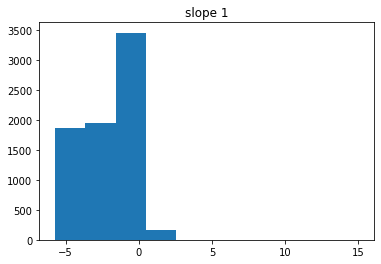

In [56]:
plt.hist(balanced_slopes_train[:,0])
plt.title('slope 1')

Text(0.5, 1.0, 'slope 2')

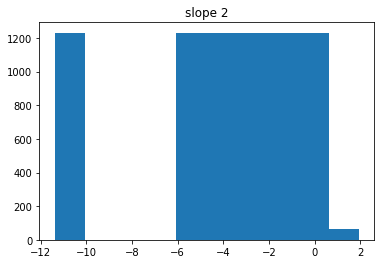

In [57]:
plt.hist(balanced_slopes_train[:,1])
plt.title('slope 2')

Text(0.5, 1.0, 'slope 2')

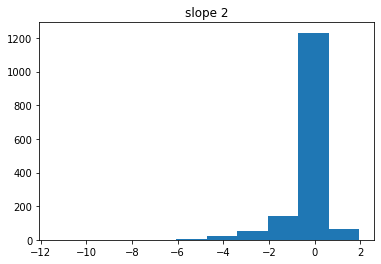

In [58]:
plt.hist(scaled_slopes_train[:,1])
plt.title('slope 2')

In [59]:
# scaled_X_train_dt, mean_X_train_dt, std_X_train_dt  = standardize_train(X_train_dt)
# scaled_X_val_dt = standardize_non_train(X_val_dt, mean_X_train_dt, std_X_train_dt)

# scaled_X_train_time_series, mean_X_train_time_series, std_X_train_time_series = standardize_train(X_train_time_series)
# scaled_X_val_time_series = standardize_non_train(X_val_time_series, mean_X_train_time_series, std_X_train_time_series)
# X_train_time_series = X_train_time_series
# print
# scaled_X_train_time_series = scaled_X_train_time_series[...,1:]
# scaled_X_val_time_series = scaled_X_val_time_series[...,1:]


# test_X_train_time_series = rev_scale(scaled_X_train_time_series[...,1:], scaler)


In [12]:
from dataclasses import dataclass
@dataclass
class Config:
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def build_model(L, T, cycle_window_size=10, reg_strength=0):
    inputs = tf.keras.Input(shape=(cycle_window_size,T,2))
    input_dt = tf.keras.Input(shape=(cycle_window_size))
    print(f'input: {inputs.shape}')
    print(f'input_dt: {input_dt.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(32, 50, activation='relu')
#     max_pooling = 
#     blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
#     x = tf.keras.layers.Embedding(100,16)(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 100), input_shape=(cycle_window_size, 100, 2))(inputs)
    print(f'output 1 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 1: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 10 ,2))(x)
#     print(f'output 2 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 2: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(cycle_window_size, 2))(x)
#     print(f'output 3 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
#     print(f'output max_pooling 3: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 10), input_shape=(cycle_window_size, 2))(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, 25), input_shape=(100, 2))(x)
#     print(f'output 3 conv: {x.shape}')
#     x = tf.keras.layers.TimeDistributed(max_pooling)(x)
#     print(f'output max_pooling 2: {x.shape}')
#     x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(config.drop_rate))(x)
    print(f'output dropout: {x.shape}')
#     x = tf.keras.layers.Reshape((cycle_window_size, 32))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     
    print(f'output GlobalAveragePooling1D: {x.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
    print(x.shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    print(f'output bilstm dist: {x.shape}')
#     x = tf.keras.layers.Concatenate()([x, input_dt])
#     x = tf.keras.layers.LayerNormalization()(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='tanh')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength), activation='tanh')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
#                                     output_dim=config.embedding_dim,
#                                     mask_zero=True)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    yhat = tf.keras.layers.Dense(2, kernel_regularizer=tf.keras.regularizers.L1(l1=reg_strength)
                                 )(x) # activation=tf.keras.layers.LeakyReLU(alpha=0.01)
#     model = tf.keras.Model(inputs=[inputs, input_dt], outputs=yhat)
    model = tf.keras.Model(inputs=inputs, outputs=yhat)
    return model
tf.keras.backend.clear_session()
L = None
T = 100

from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
model = build_model(L, T, cycle_window_size=input_window_size, reg_strength=0)
opt = tf.optimizers.Adam(1e-3)
model.compile(opt, loss='mae')  #root_mean_squared_error
#   loss='mean_absolute_error')
  
model.summary()


input: (None, 50, 100, 2)
input_dt: (None, 50)
output 1 conv: (None, 50, 1, 32)
output dropout: (None, 50, 1, 32)
output GlobalAveragePooling1D: (None, 50, 32)
(None, 50, 32)
output bilstm dist: (None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 100, 2)]      0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 1, 32)        6432      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 1, 32)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 32)           0         
 tributed)                                           

TypeError: '<=' not supported between instances of 'tuple' and 'int'

In [39]:
X_train_time_series.shape

(1414, 50, 100, 3)

In [134]:
scaled_slopes_val.shape

(397, 2)

In [13]:
# result = model.fit(
#     scaled_X_train_time_series, -np.log(-balanced_slopes_train), # standardize
# #     scaled_X_train_time_series, balanced_slopes_train,
#     validation_data=(scaled_X_val_time_series, -np.log(-slopes_val)), 
# #     validation_data=(scaled_X_val_time_series, slopes_val), 
#     callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
#             monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
#         ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)],
# # #         tf.keras.callbacks.LambdaCallback(
# # #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# # #         ),
# #         ,
#     epochs=150, batch_size=16)

result = model.fit( 
#     balanced_X_train_time_series, balanced_slopes_train, # standardize

    scaled_X_train_time_series, scaled_slopes_train, # standardize
    validation_data=(scaled_X_val_time_series, scaled_slopes_val), 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)],
# #         tf.keras.callbacks.LambdaCallback(
# #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# #         ),
#         ,
    epochs=200, batch_size=32)

Epoch 1/200


2022-08-02 14:46:43.315192: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


45/45 [==============================] - 14s 99ms/step - loss: 0.7450 - val_loss: 0.5097 - lr: 0.0010
Epoch 2/200
45/45 [==============================] - 2s 41ms/step - loss: 0.6775 - val_loss: 0.5321 - lr: 0.0010
Epoch 3/200
45/45 [==============================] - 2s 46ms/step - loss: 0.6570 - val_loss: 0.5198 - lr: 0.0010
Epoch 4/200
45/45 [==============================] - 2s 50ms/step - loss: 0.6432 - val_loss: 0.4980 - lr: 0.0010
Epoch 5/200
45/45 [==============================] - 2s 50ms/step - loss: 0.6255 - val_loss: 0.4721 - lr: 0.0010
Epoch 6/200
45/45 [==============================] - 2s 50ms/step - loss: 0.5765 - val_loss: 0.4167 - lr: 0.0010
Epoch 7/200
45/45 [==============================] - 2s 50ms/step - loss: 0.5853 - val_loss: 0.4940 - lr: 0.0010
Epoch 8/200
45/45 [==============================] - 2s 50ms/step - loss: 0.5319 - val_loss: 0.3958 - lr: 0.0010
Epoch 9/200
45/45 [==============================] - 2s 50ms/step - loss: 0.4920 - val_loss: 0.4024 - lr: 0

In [165]:
# model_json = model.to_json()
# with open(f"saved_models/LFP/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights(f"saved_models/LFP/model_window_size_inputs_window_{input_window_size}_outputs_window_{output_window_size}.h5")

Text(0.5, 0, 'Epochs')

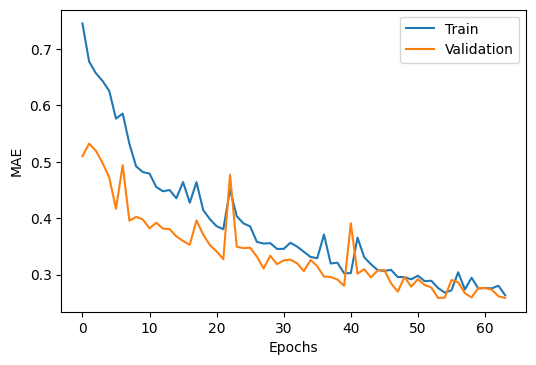

In [14]:
plt.figure(dpi=100, facecolor='white')
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')
# plt.savefig(f'media/LFP/img/loss_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

In [15]:
slope_mae = model.evaluate(scaled_X_test_time_series, scaled_slopes_test)
# test_result = model.evaluate(scaled_X_test_time_series, slopes_test)

5/5 [==============================] - 0s 24ms/step - loss: 0.3145


In [139]:
# dict_results = {'Input_window_size':cycle_window_size,
#                 'Prediction_window_size':cycle_window_size,
#                 'Test MAE':test_result
#                }
# import json
# with open(f'CACHED_DATA/results/LFP/input_window_{cycle_window_size}_output_window_{cycle_window_size}.json', 'w') as f:
#     json.dump(dict_results, f,  indent=4)

In [16]:
Y_hat_test = model.predict(scaled_X_test_time_series)
Y_hat_test = l_scaler.inverse_transform(Y_hat_test)

5/5 [==============================] - 2s 14ms/step


(array([1.000e+00, 1.000e+00, 2.000e+00, 3.400e+01, 2.260e+02, 1.147e+03,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([-10.92 ,  -8.822,  -6.723,  -4.625,  -2.527,  -0.429,   1.669,
          3.768,   5.866,   7.964,  10.062]),
 <BarContainer object of 10 artists>)

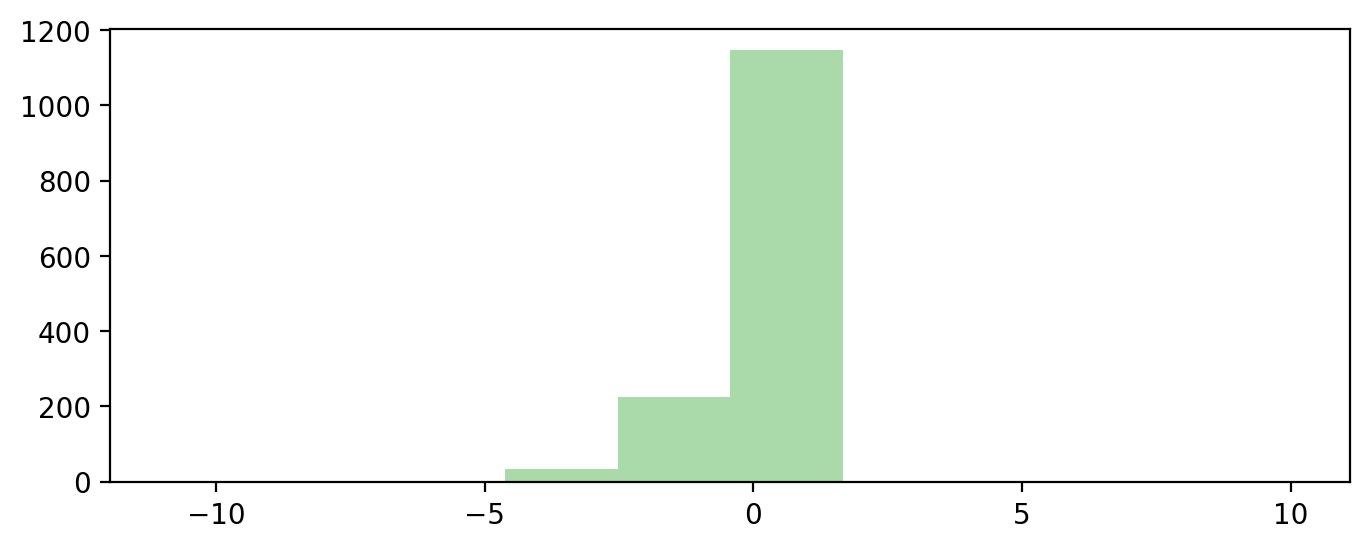

In [17]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
ax.hist(scaled_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')

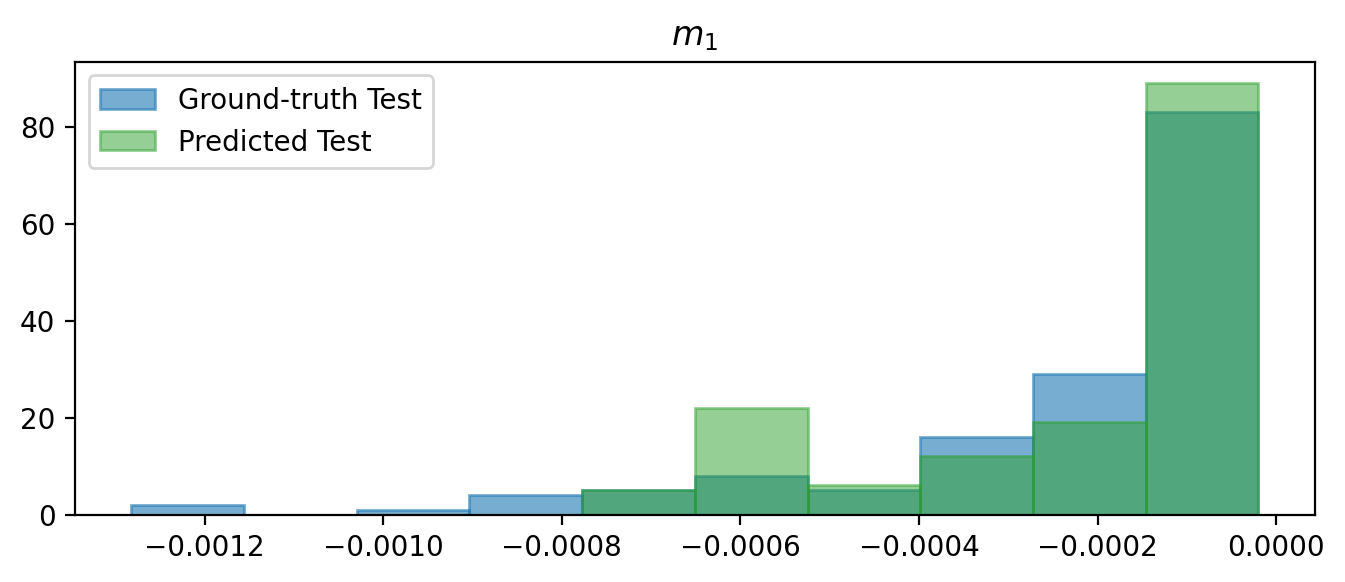

In [18]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
n, bins = np.histogram(slopes_test[:,0], bins=10)
ax.hist(slopes_test[:,0], alpha=0.6, label='Ground-truth Test', color='C0', bins=bins, edgecolor='C0')
# ax[0].set_title('True Test value m1')
ax.hist(Y_hat_test[:,0],  alpha=0.5, label='Predicted Test', color='C2', bins=bins, edgecolor='C2')
# ax[0].set_title('Predicted Test value m1')
# ax.hist(balanced_slopes_train[:,0], alpha=0.4, label='True Train', color='C2')
ax.set_title(r'$m_1$')
plt.legend()
# plt.savefig(f'media/LFP/img/m1_hist_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

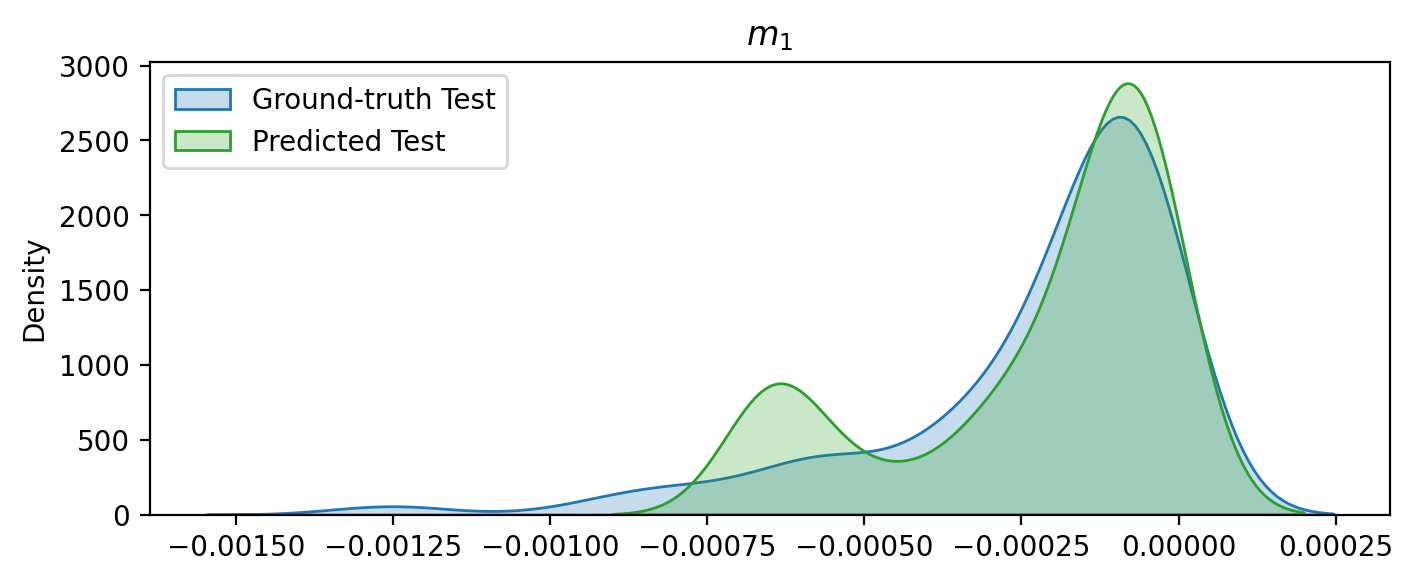

In [19]:
import seaborn as sns
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
sns.kdeplot(slopes_test[:,0], alpha=0.25, label='Ground-truth Test', color='C0', fill=True)
sns.kdeplot(Y_hat_test[:,0],  alpha=0.25, label='Predicted Test', color='C2', fill=True)
ax.set_title(r'$m_1$')
plt.legend(loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
# plt.savefig(f'media/LFP/img/m1_kde_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

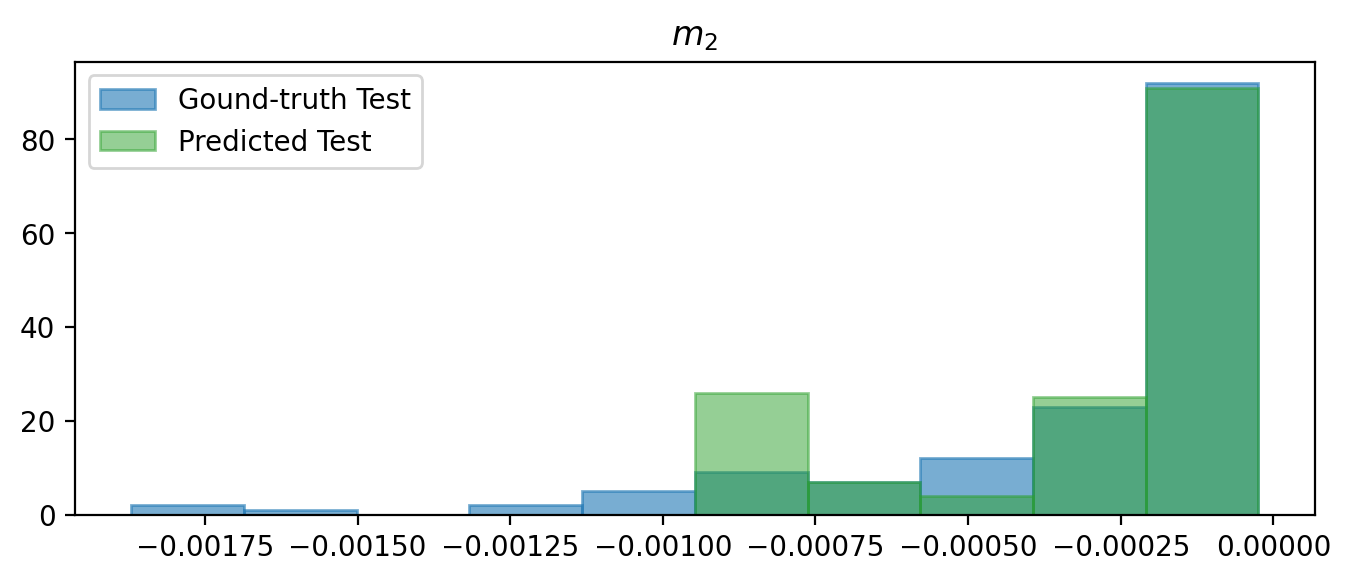

In [20]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
n, bins = np.histogram(slopes_test[:,1], bins=10)
ax.hist(slopes_test[:,1], alpha=0.6, label='Gound-truth Test', color='C0', bins=bins, edgecolor='C0')
# ax[0].set_title('True Test value m1')
ax.hist(Y_hat_test[:,1],  alpha=0.5, label='Predicted Test', color='C2', bins=bins, edgecolor='C2')
# ax.hist(balanced_slopes_train[:,1], alpha=0.4, label='True Train', color='C2')
ax.set_title(r'$m_2$')
plt.legend()
# plt.savefig(f'media/LFP/img/m2_hist_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

(0.0, 3026.42428259138)

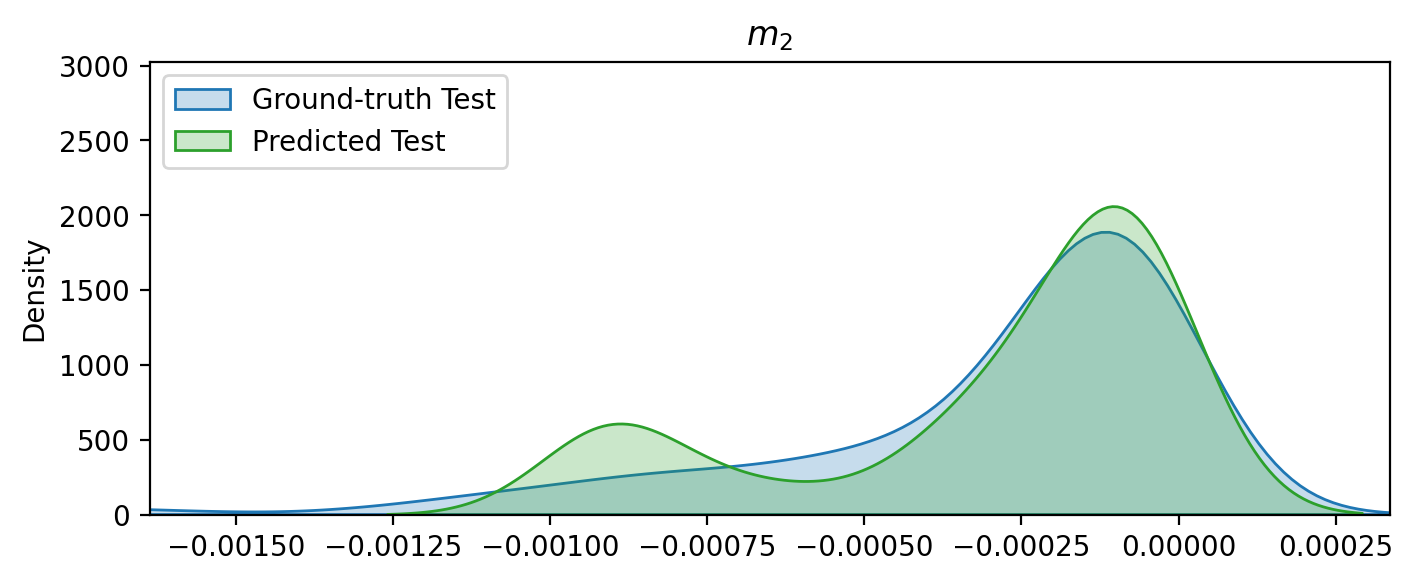

In [21]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
sns.kdeplot(slopes_test[:,1], alpha=0.25, label='Ground-truth Test', color='C0', fill=True)
sns.kdeplot(Y_hat_test[:,1],  alpha=0.25, label='Predicted Test', color='C2', fill=True)
ax.set_title(r'$m_2$')
plt.legend(loc='upper left')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
# plt.savefig(f'media/LFP/img/m2_kde_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False)

Text(0, 0.5, 'Predicted Value')

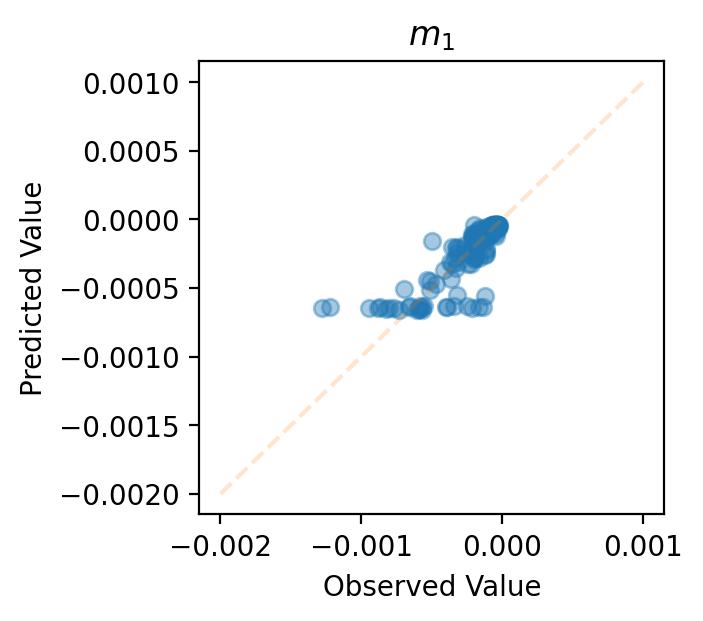

In [22]:
from sklearn.metrics import r2_score
plt.figure(figsize=(3, 3), dpi=200, facecolor='white')
plt.scatter(slopes_test[:,0], Y_hat_test[:,0], alpha=0.4)
# plt.scatter(-slopes_test[:,0], -Y_hat_test[:,0], alpha=0.4)
# plt.plot([2,8], [2,8], color='C1', alpha=0.2, linestyle='--')
plt.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
plt.title(r'$m_1$')
plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
# plt.savefig(f'media/LFP/img/m1_parity_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False, bbox_inches="tight")

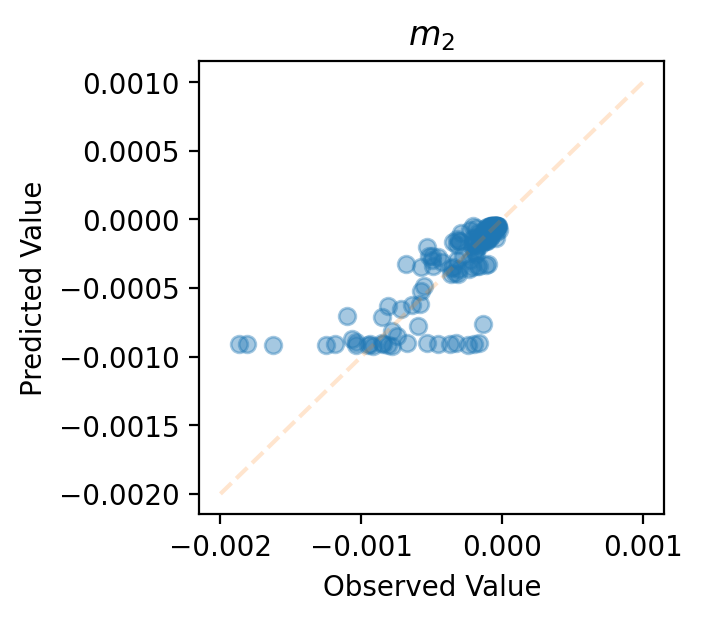

In [23]:
from sklearn.metrics import r2_score
plt.figure(figsize=(3, 3), dpi=200, facecolor='white')
plt.scatter(slopes_test[:,1], Y_hat_test[:,1], alpha=0.4)
# plt.scatter(-slopes_test[:,0], -Y_hat_test[:,0], alpha=0.4)
# plt.plot([2,8], [2,8], color='C1', alpha=0.2, linestyle='--')
plt.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
plt.title(r'$m_2$')
plt.xlabel('Observed Value')
plt.ylabel('Predicted Value')
ax=plt.gca()
# plt.savefig(f'media/LFP/img/m2_parity_in_{input_window_size}_out_{output_window_size}_window.png', dpi=400, transparent=False, bbox_inches="tight")
# import matplotlib.ticker as mtick
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.2e'))
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.2e'))

In [24]:
# testing on data
test_cell_number = 5
tested_cell = [test_cells[test_cell_number]]
# X_train_tested_cell = [x for xs in train_cells for x in xs[0]]
# Y_train = np.array([x for xs in train_cells for x in xs[1]])
# Y_train_tested_cell = [x for xs in train_cells for x in xs[1]]
X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
# Y_test = [x for xs in test_cells for x in xs[1]]
Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)

# scaled_X_tested_cell_dt = standardize_non_train(X_tested_cell_dt, mean_X_train_dt, std_X_train_dt)
# scaled_X_tested_cell_time_series = standardize_non_train(X_tested_cell_time_series, mean_X_train_time_series, std_X_train_time_series)[...,1:]

# std_X_tested_cell_time_series = standardize(X_tested_cell_time_series[...,1:])
all_test_slopes = [y[0] for y in Y_tested_cell]
all_test_dc = np.array([y[1] for y in Y_tested_cell])
# Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
_, scaled_X_tested_cell_time_series = scale(X_tested_cell_time_series[...,1:], f_scaler)
Y_hat_tested_cell = model.predict(scaled_X_tested_cell_time_series)
Y_hat_tested_cell = l_scaler.inverse_transform(Y_hat_tested_cell)


1/1 [==============================] - 0s 148ms/step


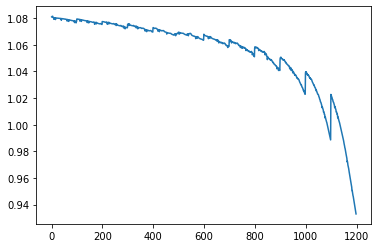

In [25]:
plt.plot(all_test_dc.reshape([-1,2])[1:,1])

In [148]:
output_window_size

50

predicted slope: -4.881869244854897e-05, True slope: -2.414200000000033e-05
predicted slope: -5.595751281362027e-05, True slope: -3.769399999999923e-05
[[50.0, 1.0806258], [99.5, 1.0782092747237968], [149.0, 1.0754393778395226]]
predicted slope: -5.146875628270209e-05, True slope: -3.835800000000056e-05
predicted slope: -5.979606066830456e-05, True slope: -4.4133999999997894e-05
[[100.0, 1.0794187], [149.5, 1.0768709965640062], [199.0, 1.0739110915609251]]
predicted slope: -5.1353927119635046e-05, True slope: -4.268600000000067e-05
predicted slope: -5.95596939092502e-05, True slope: -5.0755999999996246e-05
[[150.0, 1.0775008], [199.5, 1.074958780607578], [249.0, 1.07201057575907]]
predicted slope: -5.589869397226721e-05, True slope: -4.913399999999957e-05
predicted slope: -6.573407154064626e-05, True slope: -6.627999999999634e-05
[[200.0, 1.0753665], [249.5, 1.0725995146483727], [299.0, 1.0693456781071107]]
predicted slope: -6.628681148868054e-05, True slope: -6.77419999999973e-05
pred

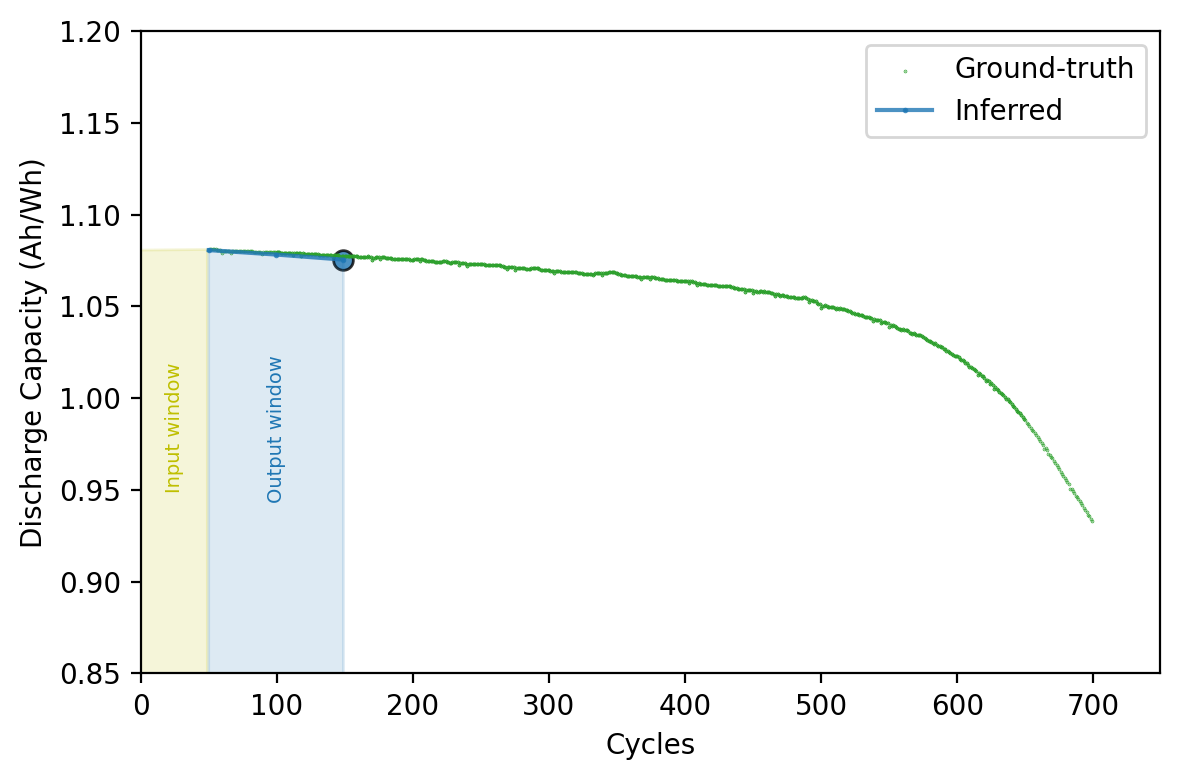

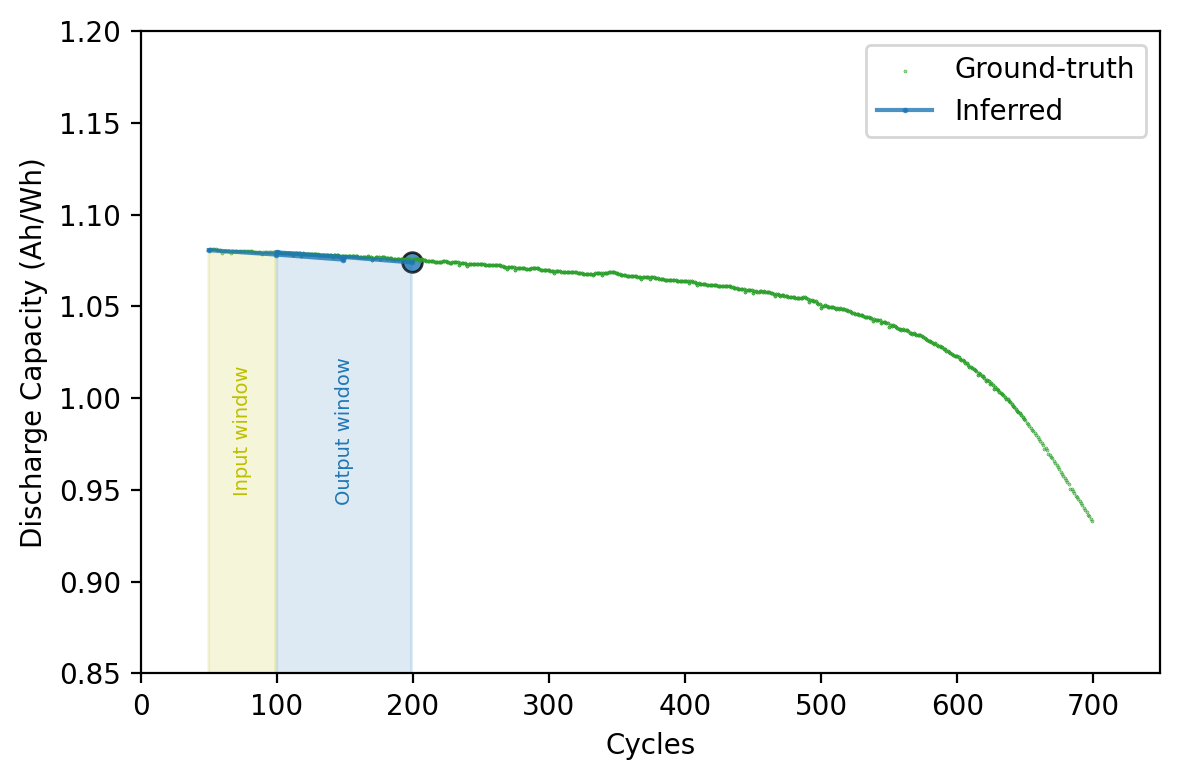

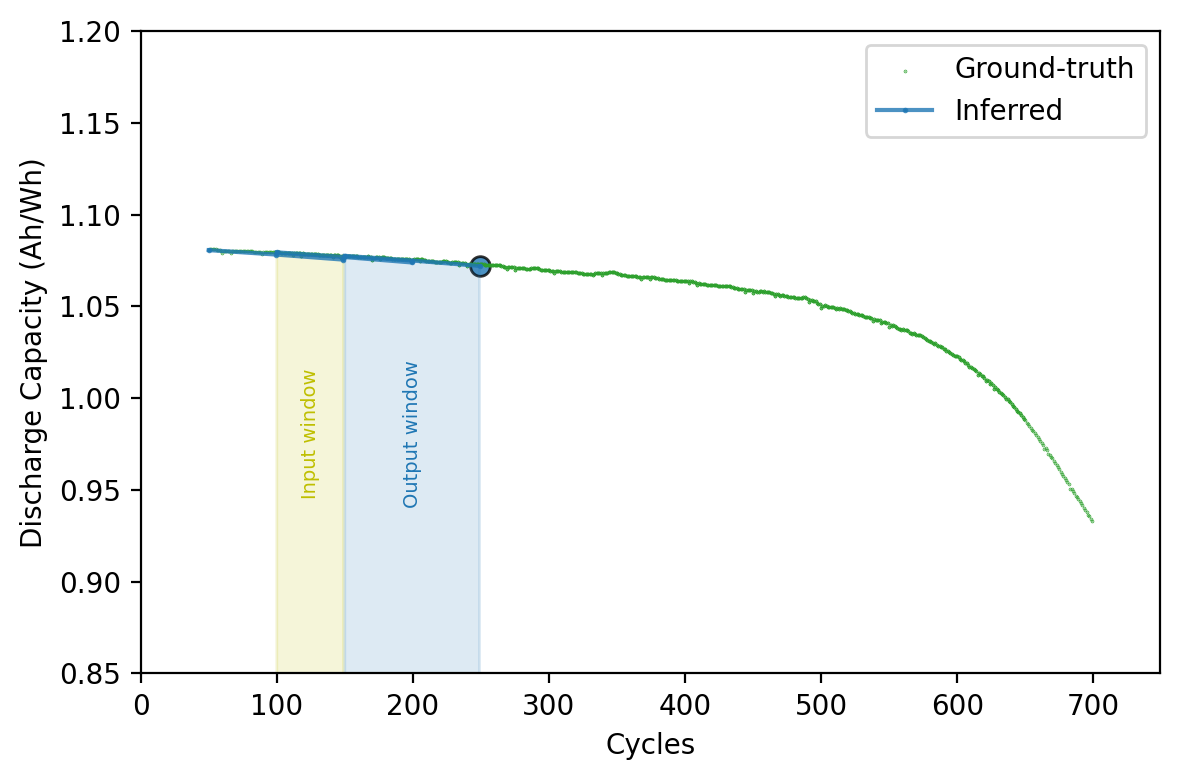

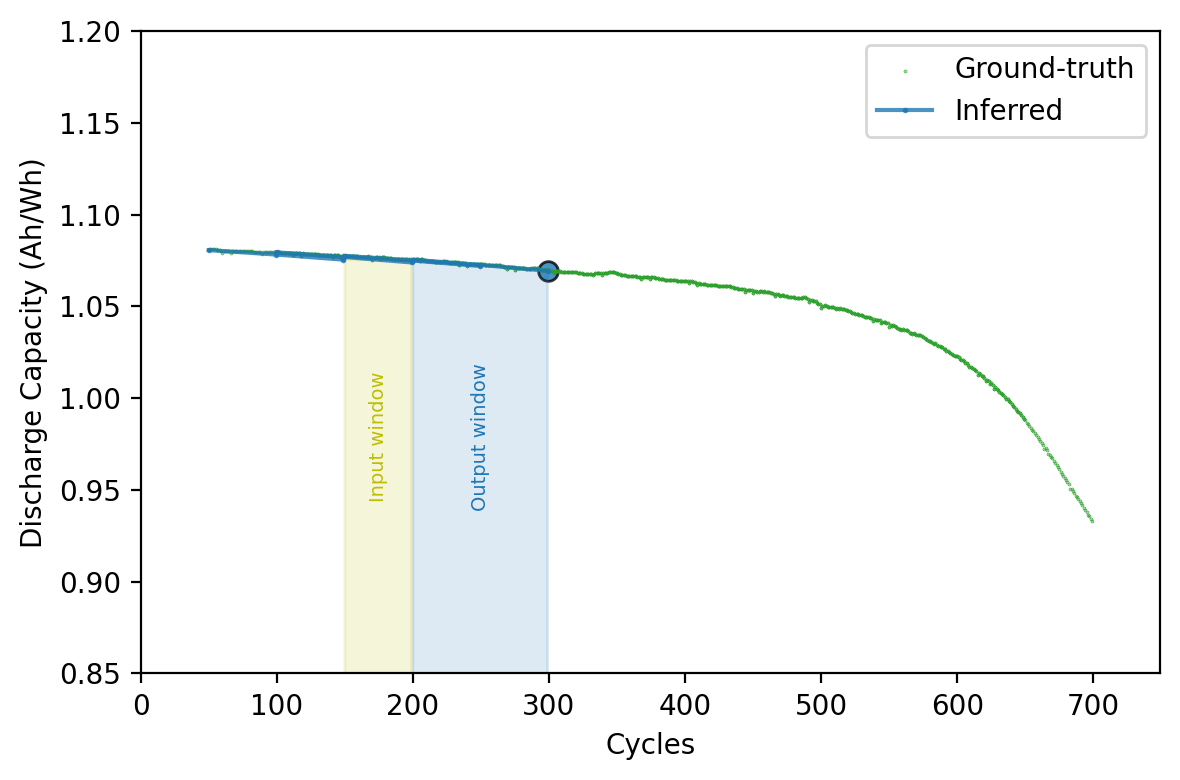

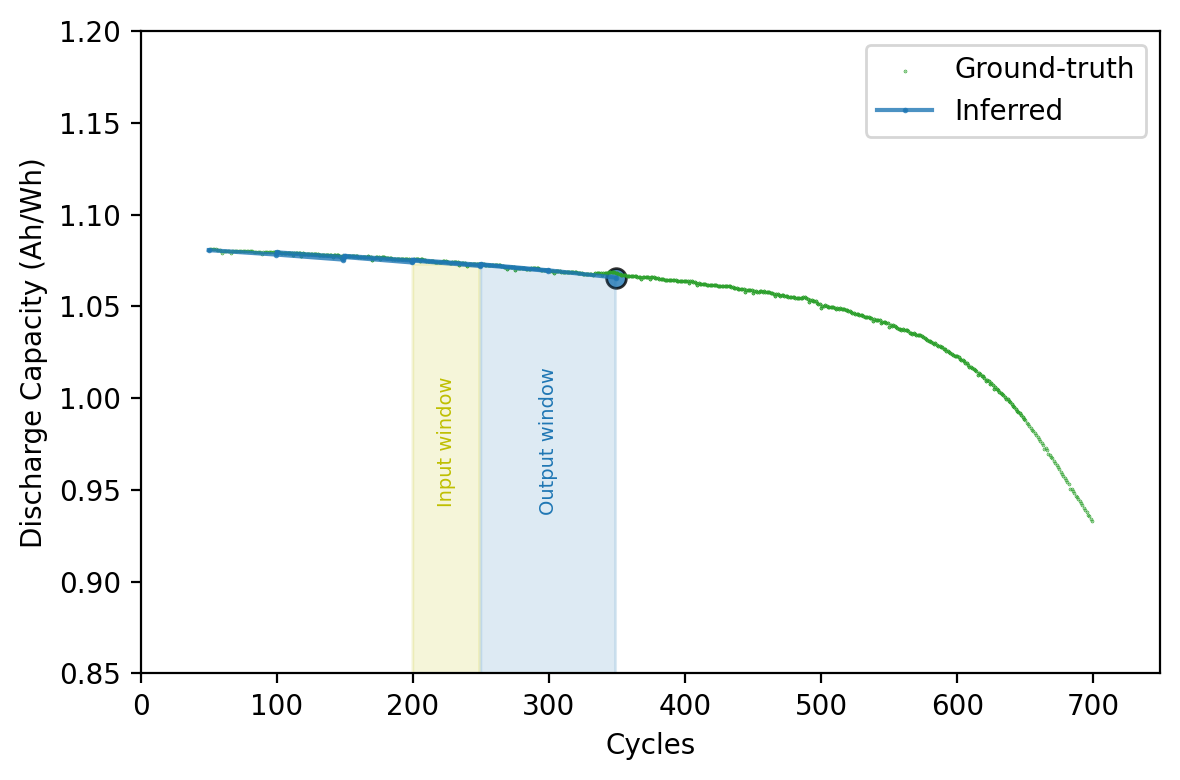

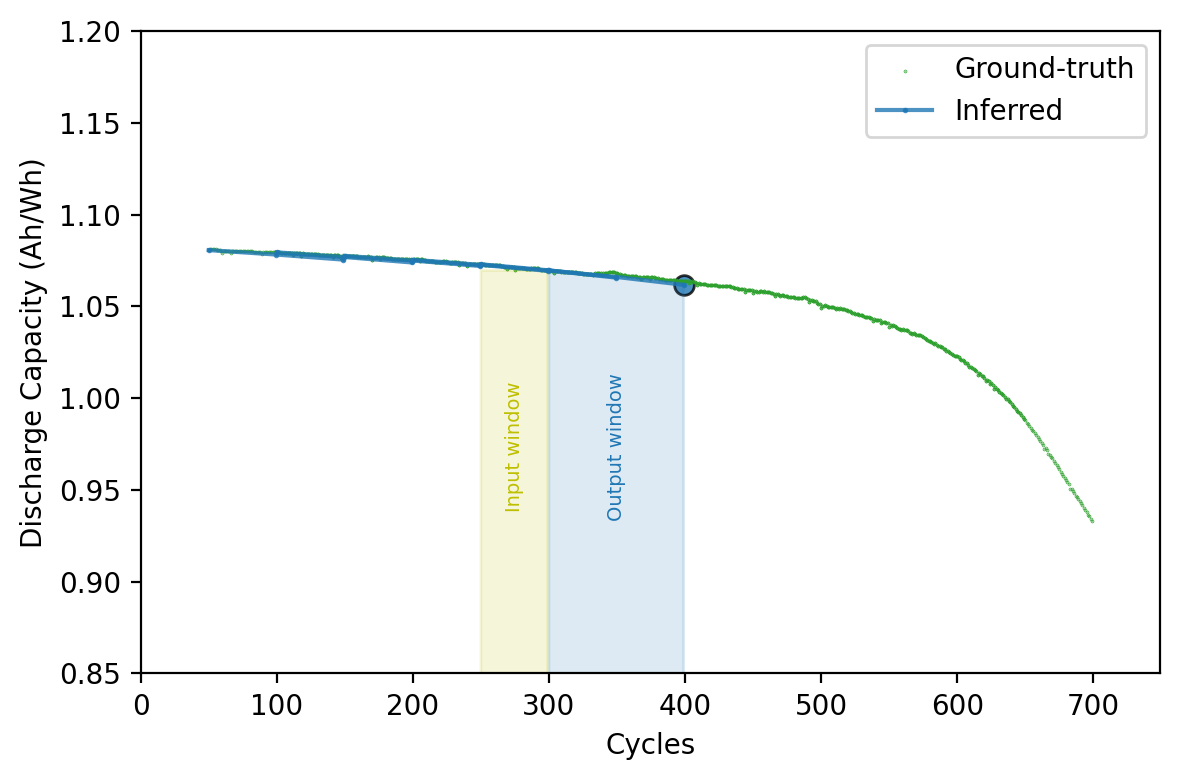

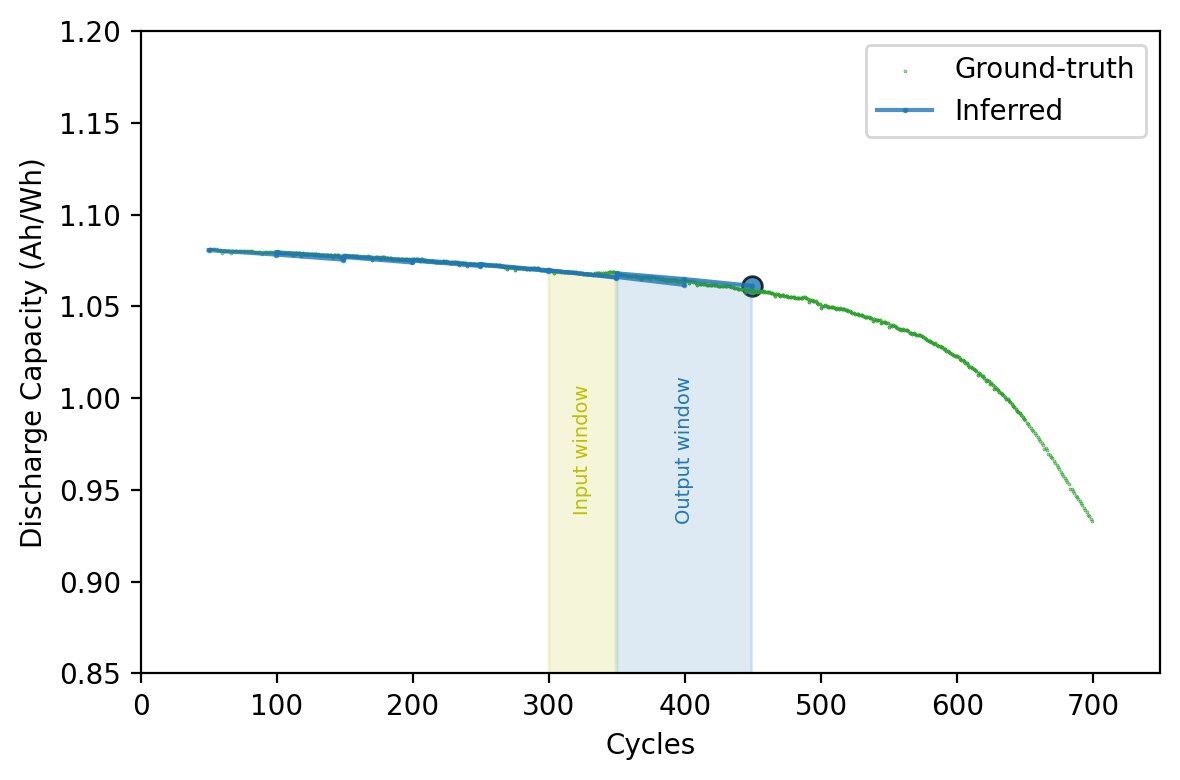

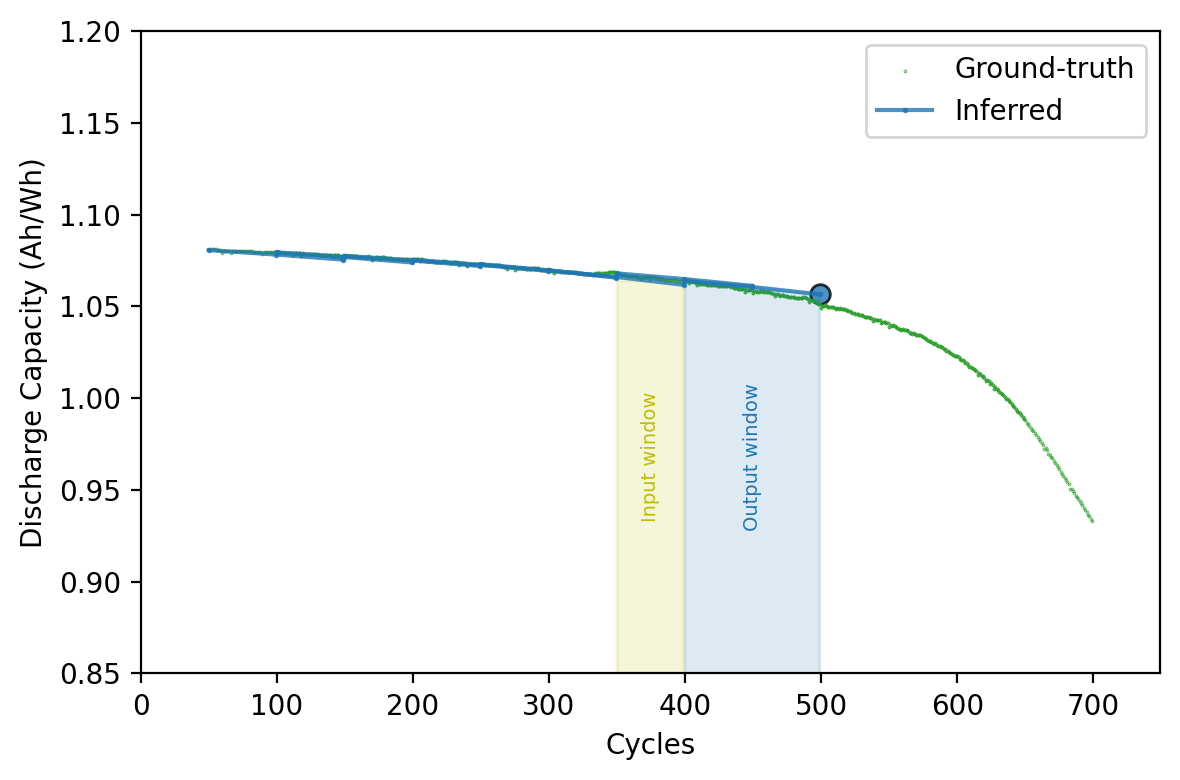

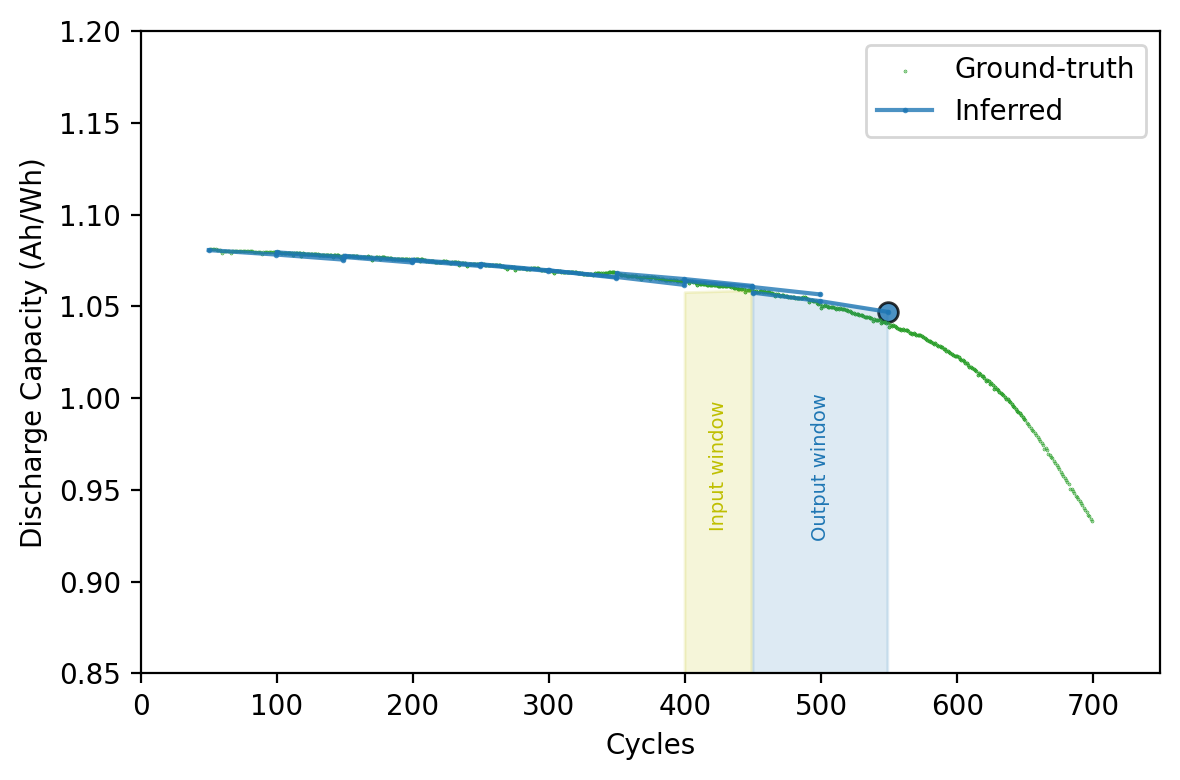

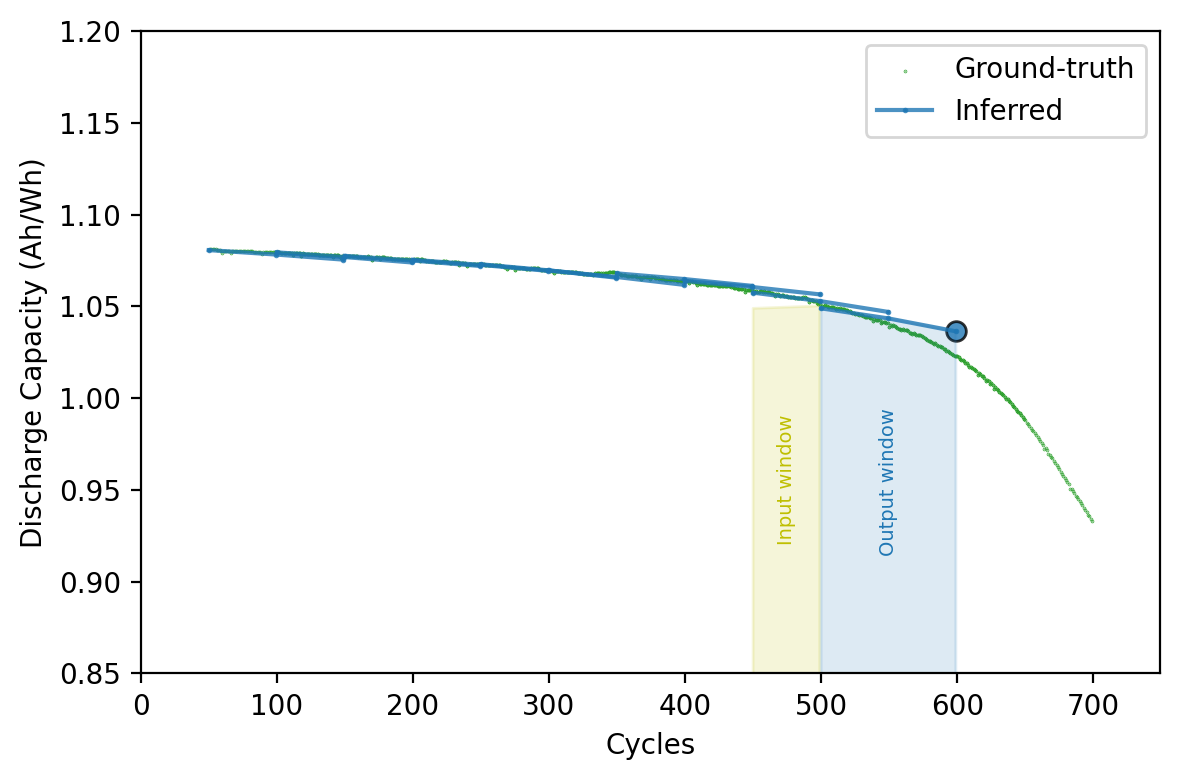

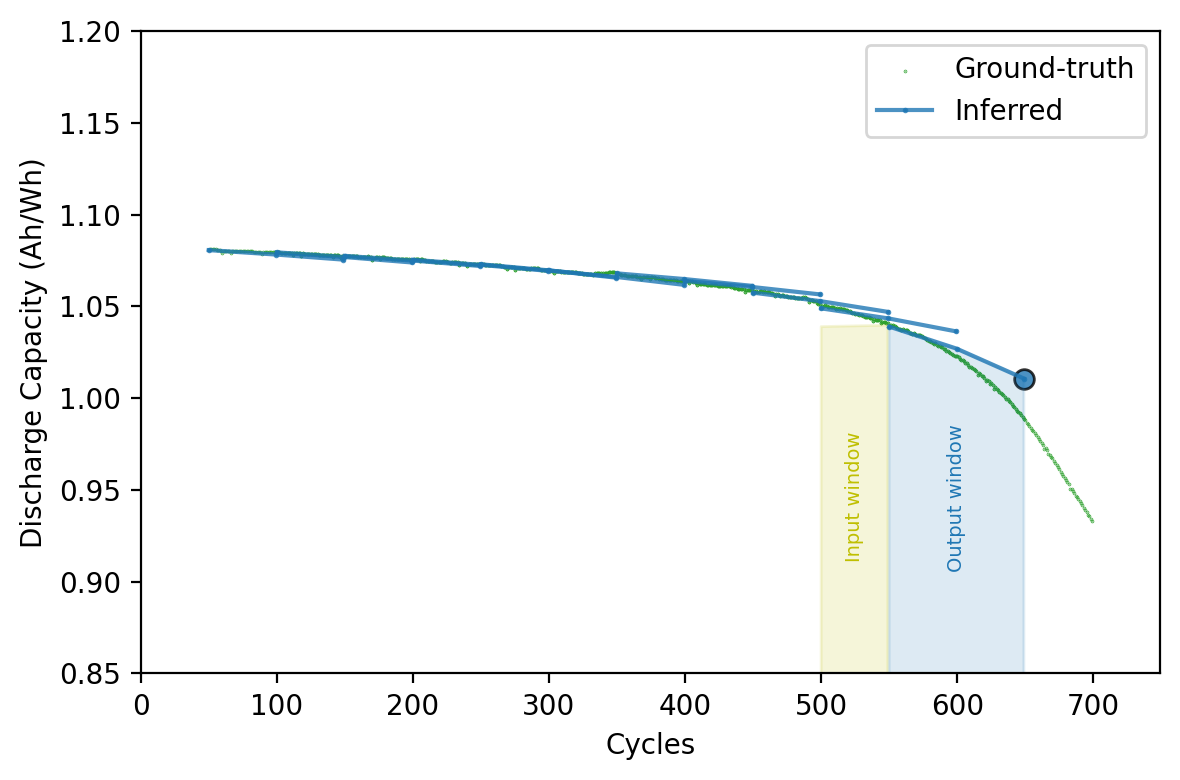

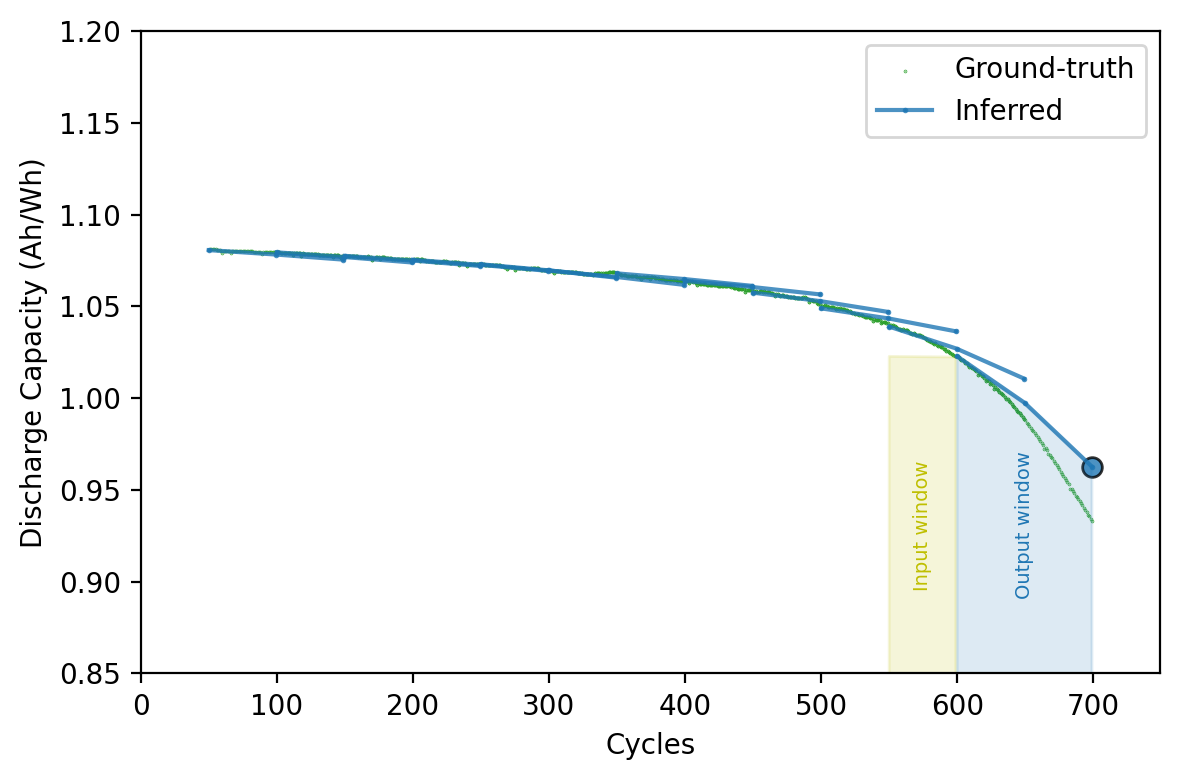

In [54]:
def linear_fit(new_x_point, slope, point_xy):
    return slope*(new_x_point-point_xy[0]) + point_xy[1]

def eval_dc_reconstruction(predicted_dc, ground_truth_dc):
    ground_truth_dc = np.unique(ground_truth_dc, axis=0)
    from scipy.interpolate import interp1d
    f = interp1d(ground_truth_dc[:,0], ground_truth_dc[:,1], kind='cubic')
    interpolated_dc_ground_truth = f(predicted_dc[:,0])
    return np.sqrt(((interpolated_dc_ground_truth - predicted_dc[:,1]) ** 2).mean())


# testing on data
# tested_cell = [test_cells[3]]
# # X_train_tested_cell = [x for xs in train_cells for x in xs[0]]
# # Y_train = np.array([x for xs in train_cells for x in xs[1]])
# # Y_train_tested_cell = [x for xs in train_cells for x in xs[1]]
# X_tested_cell = [x for cycle in tested_cell for x in cycle[0]]
# # Y_test = [x for xs in test_cells for x in xs[1]]
# Y_tested_cell = [y for cycle in tested_cell for y in cycle[1]]
# dc_tested_cell, slopes_tested_cell = make_label_arrays(Y_tested_cell)
# X_tested_cell_time_series, X_tested_cell_dt = make_feature_arrays(X_tested_cell)

# # scaled_X_tested_cell_dt = standardize_non_train(X_tested_cell_dt, mean_X_train_dt, std_X_train_dt)
# # scaled_X_tested_cell_time_series = standardize_non_train(X_tested_cell_time_series, mean_X_train_time_series, std_X_train_time_series)[...,1:]

# # std_X_tested_cell_time_series = standardize(X_tested_cell_time_series[...,1:])
# all_test_slopes = [y[0] for y in Y_tested_cell]
# all_test_dc = np.array([y[1] for y in Y_tested_cell])
# # Y_hat_tested_cell = model.predict([scaled_X_tested_cell_time_series, scaled_X_tested_cell_dt])
# Y_hat_tested_cell = model.predict(X_tested_cell_time_series[...,1:])

# initial_dc = all_test_dc.reshape([-1, 2])[cycle_indices[0]]
# index_0 = initial_dc[0]
# for i,m in enumerate(all_test_dc.reshape([-1,2])):
#     plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=2, label='Ground-truth' if i == 0 else "")

# window_size = 100
all_predicted_dc_values = []
max_cycle_index = all_test_dc.reshape([-1,2])[-1,0]
for i,m in enumerate(all_test_dc):
    plt.figure(dpi=200, facecolor='white')
#     print(m[0,0], m[5,0], m[9,0])
    plt.scatter(*list(zip(*all_test_dc.reshape([-1,2]))), color = 'C2', s=0.1, label='Ground-truth', alpha=0.8) #if i == 0 else "")
#     if i == 0:
#         initial_dc = m[0]
    initial_dc = m[0].tolist()
#     print(m)
#     print(m)
#     break
    predicted_dc_values = [initial_dc]
#     print(initial_dc)
#     if i%2 == 0:
    new_cycle_index = m[0,0]
#         print(f'hi {i}')
    for j,slope in enumerate(Y_hat_tested_cell[i]):
        new_cycle_index += (output_window_size-1)/2#np.floor(window_size/2)
        new_predicted_dc = linear_fit(new_cycle_index, slope, initial_dc) # slopes_tested_cell[i,j]
#         new_predicted_dc = linear_fit(new_cycle_index, -np.exp(-slope), initial_dc)

        print(f'predicted slope: {slope}, True slope: {np.array(slopes_tested_cell)[i,j]}')
        predicted_dc_values.append([new_cycle_index , new_predicted_dc])
        initial_dc = predicted_dc_values[-1]
#         print(initial_dc)
      # 
    print(predicted_dc_values)
#     break
#     initial_dc = np.array([new_cycle_index, new_predicted_dc]) 
    
#     print(i)
#     print(predicted_dc_values)
#     initial_dc = predicted_dc_values[-1]
    
#     if i==2 or i==1:
#         print(m)
#         break
#     if i ==2:
#         break
    all_predicted_dc_values.append(predicted_dc_values)
#     print(np.array(scatters).T)
    plt.plot(*np.array(all_predicted_dc_values).T, color='C0', label='Inferred', #if i == 0 else "",
             marker='o', markersize=1, alpha=0.8)
    plt.scatter(*np.array(predicted_dc_values[-1]).T, c='C0', #if i == 0 else "",
         marker='o', s=50, edgecolor='k', linewidth=1, facecolor='C0', zorder=-1, alpha=0.8)
    plt.xlabel('Cycles')
    plt.ylabel('Discharge Capacity (Ah/Wh)')
    plt.ylim([0.85,1.2])
    plt.xlim([0 , max_cycle_index+50])
    ax = plt.gca()
    hand, labl = ax.get_legend_handles_labels()
    plt.legend(np.unique(labl))
    plt.tight_layout()
    show_input_output_windows = True
    if show_input_output_windows:
#         print(*list(zip([all_test_dc[i][0] - output_window_size, all_test_dc[i][0]-1], all_test_dc[i][-1])))
#         print(all_test_dc[i][-1])
#         print(all_test_dc[i][0,0])
#         print(all_test_dc[i][0,0])
        input_window_cycle_index = [all_test_dc[i][0,0] - input_window_size, all_test_dc[i][0,0]-1]
#         print(input_window_cycle_index)
        input_window_dc = [all_test_dc[i][0, -1], all_test_dc[i][1, -1]]
#         print(f'input_window: {all_test_dc[i][0,0]}')
#         print(f'dcvalues {input_window_dc}')
#         print(*list(zip(input_window, input_window_dc)))
#         print(predicted_dc_values)
#         break
        input_fill_between = plt.fill_between(*list([input_window_cycle_index, input_window_dc]), alpha=.15,
                                              edgecolor='y', color='y')
        (x0, y0), (x1, y1) = input_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.91*y1, "Input window", ha='center', va='center', fontsize=7, color='y', rotation=90)

        prediction_fill_between = plt.fill_between(*list(zip(*predicted_dc_values)), alpha=.15, edgecolor='C0', color='C0')
        (x0, y0), (x1, y1) = prediction_fill_between.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, 0.91*y1, "Output window", ha='center', va='center', fontsize=7, color='C0', rotation=90)

#     break
    save_gif = False
    if save_gif:
        plt.savefig(f'media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i:04d}.png', dpi=400, transparent=False)
#     if i ==20:
        
#         break
#     plt.close()
#     break
#     if i == 2:
        
#     break

# copy last frame
if save_gif:
    for j in range(10):
        os.system(f"cp media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i:04d}.png media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_{i+j:04d}.png")
    os.system(f"ffmpeg -framerate 1 -i media/LFP/img/discharge_curve_in_{input_window_size}_out_{output_window_size}_window_test_{test_cell_number}_%04d.png -c:v h264 -crf 14 -c:v libx264 -movflags +faststart -vf format=yuv420p -maxrate 50M -tune animation -bufsize 1MB -t 15 -y media/LFP/mp4/discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.mp4")
    os.system(f'ffmpeg -i media/LFP/mp4/discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.mp4 -framerate 1 -vf "fps=24, scale=2000:-1:flags=lanczos" -loop 0 -y media/LFP/gif/discharge_curve_in_{input_window_size}_out{output_window_size}_window_test_{test_cell_number}.gif')
# ffmpeg -i discharge_curve_50_window_test_3.mp4 -r 40 -vf "fps=20, scale=2000:-1:flags=lanczos" -f image2pipe -vcodec ppm - | convert -delay 10 -loop 0 - test.gif

In [55]:
dc_rmse = eval_dc_reconstruction(np.array(all_predicted_dc_values).reshape(-1,2), all_test_dc.reshape([-1,2]))
dict_results = {'input_window_size':input_window_size,
                'prediction_window_size':output_window_size,
                'test_slope_MAE':slope_mae,
                'test_dc_RMSE': dc_rmse
               }
import json
# with open(f'CACHED_DATA/results/LFP/input_window_{input_window_size}_output_window_{output_window_size}.json', 'w') as f:
#     json.dump(dict_results, f,  indent=4)
dict_results

{'input_window_size': 50,
 'prediction_window_size': 100,
 'test_slope_MAE': 0.3145107626914978,
 'test_dc_RMSE': 0.007027829769639767}

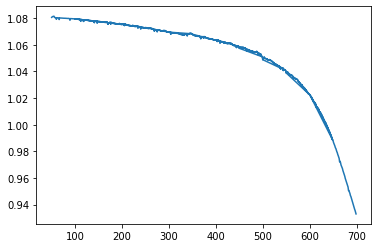

In [51]:
plt.plot(all_test_dc.reshape([-1,2])[:,0],all_test_dc.reshape([-1,2])[:,1])

In [53]:
np.unique(all_test_dc.reshape([-1,2]), axis=0).shape

(650, 2)

In [52]:
np.unique(all_test_dc.reshape([-1,2])[:,0]).shape

(650,)

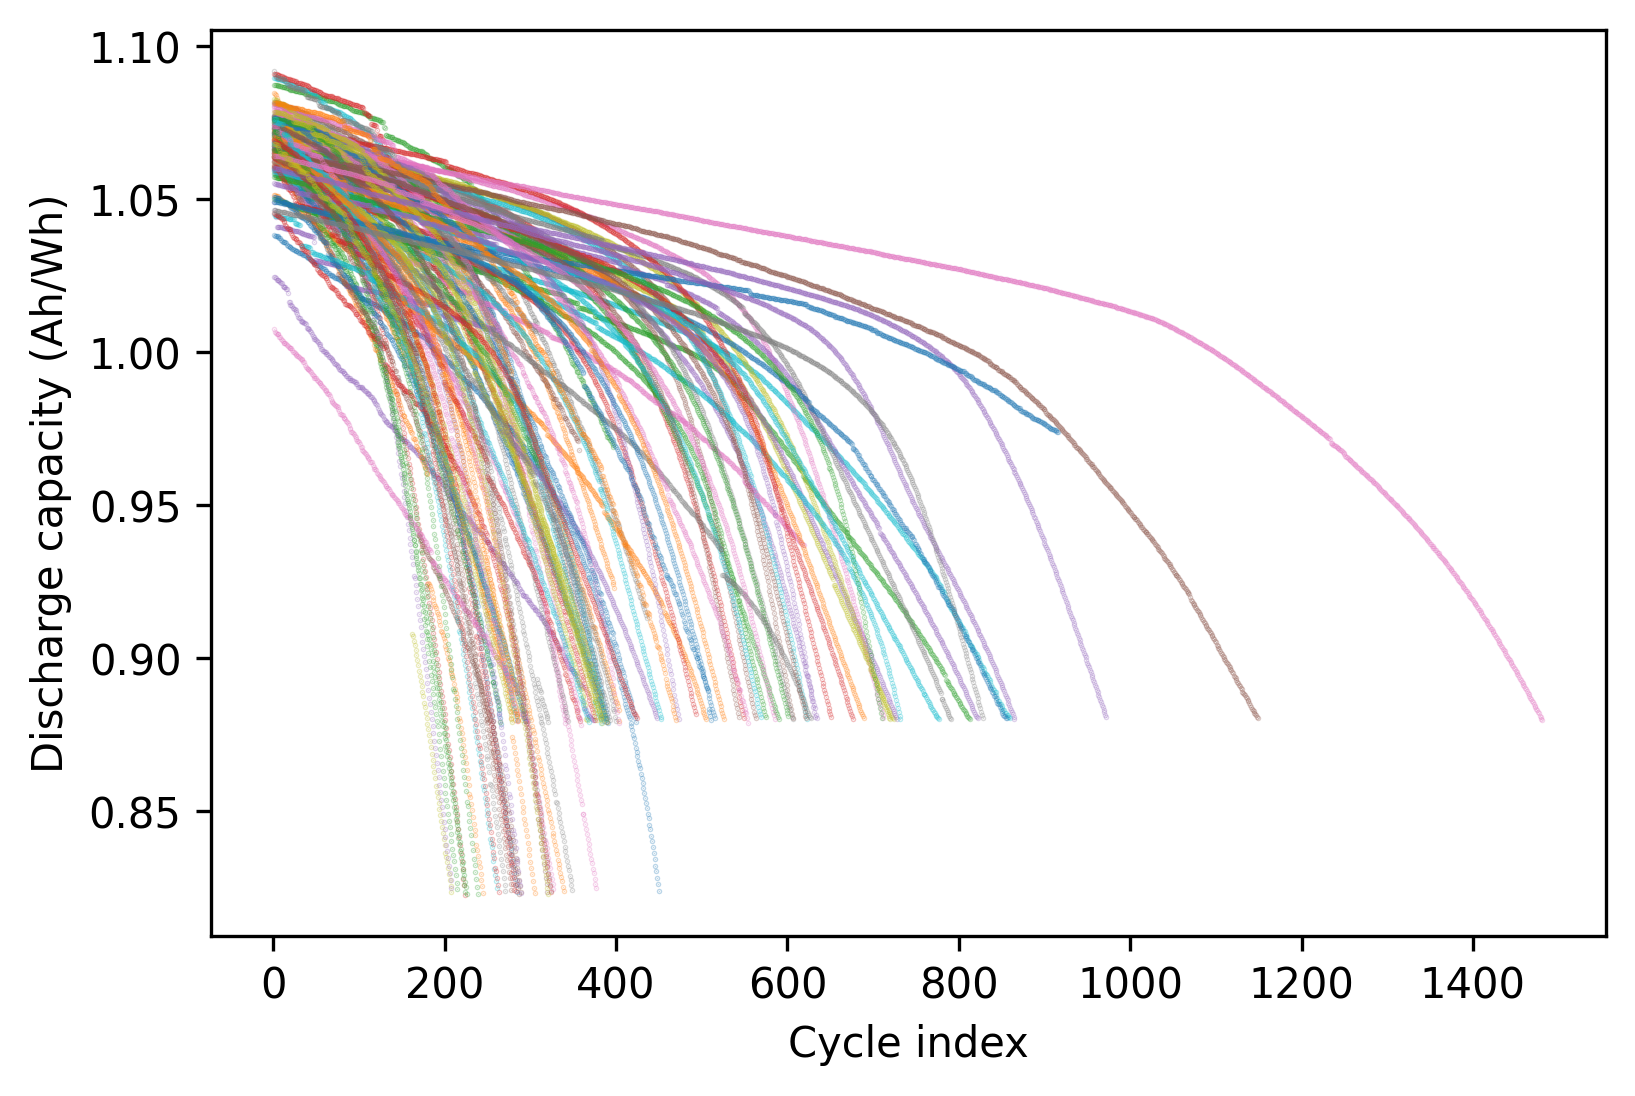

In [33]:
plt.figure(dpi=300, facecolor='white')
for i,c in enumerate(summary_data_list):
    plt.scatter(c['cycle_index'][1:], c['discharge_capacity'][1:], 
                s=0.1, color=f'C{i}', label='actual cycle_index', alpha=0.3)
plt.xlabel('Cycle index')
plt.ylabel('Discharge capacity (Ah/Wh)')
# plt.savefig(f'LFP_dataset.png', dpi=400, transparent=False)